# <center>Freesound General-Purpose Audio Tagging Challenge</center>

![Logo](https://upload.wikimedia.org/wikipedia/commons/3/3c/Freesound_project_website_logo.png)

Freesound is a collaborative database of Creative Commons Licensed sounds. The aim of this competition is to classify audio files that cover real-world sounds from musical instruments, humans, animals, machines, etc. Few of the labels are: `Trumpet`, `Squeak`, `Meow`, `Applause` and `Finger_sapping`.  One of the challenges is that not all labels are manually verified. A creative solution should be able to partially rely on these *weak* annotations.

Let's take a tour of the data visualization and model building through this kernel. If you like this work, please show your support by upvotes. Happy Kaggling!

### Contents
1. [Exploratory Data Analysis](#eda)
    * [Loading data](#loading_data)
    * [Distribution of Categories](#distribution)
    * [Reading Audio Files](#audio_files)
    * [Audio Length](#audio_length)
2. [Building a Model using Raw Wave](#1d_model_building)
    * [Model Discription](#1d_discription)
    * [Configuration](#configuration)
    * [DataGenerator class](#data_generator)
    * [Normalization](#1d_normalization)
    * [Training 1D Conv](#1d_training)
    * [Ensembling 1D Conv Predictions](#1d_ensembling)
3. [Introduction to MFCC](#intro_mfcc)
    * [Generating MFCC using Librosa](#librosa_mfcc)
4. [Building a Model using MFCC](#2d_model_building)
    * [Preparing Data](#2d_data)
    * [Normalization](#2d_normalization)
    * [Training 2D Conv on MFCC](#2d_training)
    * [Ensembling 2D Conv Predictions](#2d_ensembling)
5. [Ensembling 1D Conv and 2D Conv Predictions](#1d_2d_ensembling)
6. [Results and Conclusion](#conclusion)


<a id="eda"></a>
## <center>1. Exploratory Data Analysis</center>

In [2]:
# Change this to True to replicate the result
COMPLETE_RUN = False

<a id="loading_data"></a>
### Loading data

In [4]:
import numpy as np
np.random.seed(1001)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold
import h5py

%matplotlib inline
matplotlib.style.use('ggplot')

/Users/henryhargreaves/Documents/University/Year_3/CMPS119/SunWork/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/henryhargreaves/Documents/University/Year_3/CMPS119/SunWork/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
test = pd.read_csv("./input/sample_submission.csv")
train = pd.read_csv("./input/train.csv")

In [8]:
train.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fname</th>
      <th>label</th>
      <th>manually_verified</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>00044347.wav</td>
      <td>Hi-hat</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>001ca53d.wav</td>
      <td>Saxophone</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2</th>
      <td>002d256b.wav</td>
      <td>Trumpet</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0033e230.wav</td>
      <td>Glockenspiel</td>
      <td>1</td>
    </tr>
    <tr>
      <th>4</th>
      <td>00353774.wav</td>
      <td>Cello</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

In [9]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 9473   Number of classes= 41


In [10]:
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


<a id="distribution"></a>
### Distribution of Categories

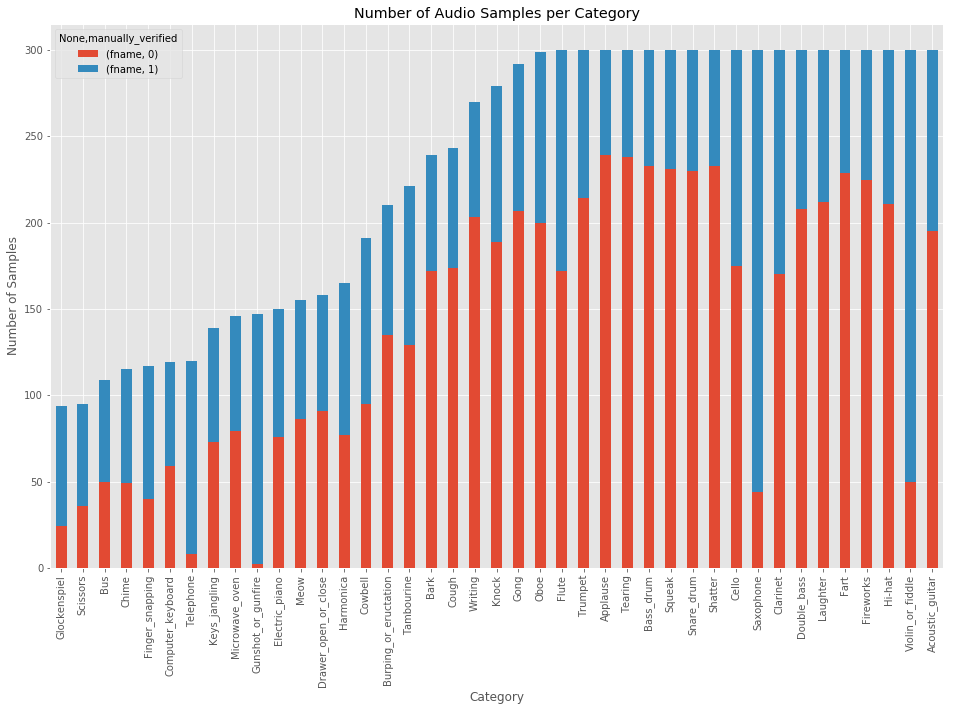

In [11]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [10]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


We observe that:
1. The number of audio samples per category is **non-nform**. The minimum number of audio samples in a category is `94` while the maximum is `300`
2. Also, the proportion of `maually_verified` labels per category is non-uniform.
<a id="audio_files"></a>
### Reading Audio Files

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz

![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.

Let's listen to an audio file in our dataset and load it to a numpy array

In [12]:
import IPython.display as ipd  # To play sound in the notebook
fname = './input/audio_train/' + '00044347.wav'   # Hi-hat
ipd.Audio(fname)

<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRpTXEgBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YXDXEgAAABoA+//0//j/8P/i//f/AwARAEMAjAC5AK4AlgBtAEgAEgDX/6P/lP+s/9j/1/+f/37/lf/c/0kAmwCNAGYAYgCFAIgAPQDq/9z/+//+//b/8f8HABUAPQBwAFsARQAcANj/5/8VAMv/Uf9N/3//Qf9M/9z/zv91/6T/IQA8AP3/8f8GAB4AHADl/23/1v8UAO//kv96AJMA5QCY/7D/gv0uAOL/oAYVB38B7f/19/vvV9rqBK4tBg4L7qvwWgAhAKHw5+qL7rL9QAmbBKnx1Or/AesJgfUb83QGFw9rD0UUswkN54bnrAPJCHkMExBs/SL+tgfrAhH45/nRAg4HMwx3BkEEvAcdAFH+kwwPFpYfuhvjCcsFOQH57b7wEgEVEdoIeQQ6Cwbz8OOF+EoA2QLIB6cTBxGcAEICFRFDFuoAmepr+XUCqe8v7h/p1OtvDTELSe+L+0T8+ezP+w39MvKx8+zvZfL6AWf+QOfi5mP7g/sa+qj6GPFc+18SAxrPBqXqjeBr8WEEnQ1f/sD0MAK2EcwQcg7ZIaISygPcE/QJ+ACNA4UBP/xPBtoF0P3jAJUJxQiKBnUMFBFFAIPtEQsDGyH6QPChC8MF6wP6DEz5hPS8C7YNTwI/HJcNiebD4Fb3O/1T6dfjCusn9toD9BSoE9sDV+vk3XgE6hyA9Y/clAWCEPnnuPDtASDsZfHCAx35xPuUBin0IO6tAXr5jvg+EPcF2O3t7EDiy+0qFmgUPRLQIQARGQOuCNH3iO+wDwkhBRMvEosWkgOYBKoeXhaiCIcSYBHwC+QNUQDkAtQSSApyAm0P8Qc5+EkA9hObGHcAHO54/xQQ+vbT7qLroPGQBpgCUgV6Cwbw5uP861HwjgYTBTT48f4l6mfW7uRo6kfcsOLI7GvtH/YW/eLtEdqQ5h3w0uLB64P/CvlY7hTsOfXS+nXt8Pm7ER0MXvuB7mn0HA7oFf8NFwSN/OwBUA3uBO3v/vjNHrE3+S2eIsEcBxJ2Jkkvow2TFoM63j/FJ08ZcCv3Mg0SMAy9E9X7O/hJDowU+gno87rgufbtElUCaP32DAQHTvlj7T/0gv7/6SPuUxOYDiDaPs/j47v3/fs/7RPfNu/p9Q/ZVs715DDt4d8M8ZPzpdD7yY/snPiJ6bbkS+W74X3b0diO0ufOXef58r3Zrd3r7/bpn+5ICD0KMgSlEj8SjQ88FGUPXiF7MQsrESr6JIQcrSrINdsa+hr5PSdF8S39HCMVFwgGEPIo4xqSBSEalRnWEkgRk/Fm4Ib6BhlSEBn97RG8FKT2JPjSAU79evId+awGfg3jAMbyPvuNE4wJNPcu+lAHlSZ9GcX4nQI6AAb3v/ll//v0kuQF53rsVfjQ81nastV44i3X3r3ZvLfDeN3c4m3ZcsvH0HHgEeI25PHpOut1/nEHY/DI18TjZAY8CdbuUeOf5DL74Q/s+zX2bBdLJF8etyd5H6P2bPAnF0ohTxgGEv0dKTgkMLghICZtOj08GiDhD7kGygd8Fr8XihgCE8/8E+73GXc+Az5rNiAoVDi2Ny4xXCxoLto4fx+h+/Xsc+n2/OMQYCHVFtTyxgE7COTPisyd8ZrW3r446FX/HNIZuFDP9eOoz0fGS9LqxfTGhM52wBfCOMEywgXB6MLzwVDDBsPH1HPv7AEd5Drmeyrf/tAW1DvV5W3FFRMYEFjKGNLQKso+VihkBqwPXRVYDj0tgyWBC0jy+hOv+gvkBC5AOq0MQBRwOVw4Exj8H7o+WDwnPnw4wxxEJT4q3x3vFmoV5A4zMho/typZHOgdWyLCKjoTageU+hnzJ+xb4p/9EwcDA/j9wQUf+tXyahH9HksLTgdO2EHCtMOGvW8Aziq45li5itKq4XfAIsDpywvjHumF5IjGE8f12lfNKvNy/ezZpw/XGgjGsNeBKzUCP8OY9JAgnwiE5R/kEPDJ4+fe3A27FoTzDf10FjfbU8J7BW0FoekPE4obMg+WKGIe2ShhFy/rmS1+Pno/wDIeKiI4fS2QLSMnPRMfAAcwmjxfFPEFegSeLJw+IDdFEQ8vEj5wI+oFctAQyZbrYv6W/G/+WvTM4UHzR/Exyyq8CNBKz1DAJL911WTuj81hzX0MXyR17Me+dOwDCBUBfgTNzn3NJvFezrDAKOWJBurm0+Pc8e7qfusMAUEC2/LBGtgN1uCLI/wpnhYJNf0+/QP3EWQ7pv9zzdvt0hDl/ibyHCQmFsccPERjEiMP5UR6B/EgZUFFPG1AOToYH6cjHhhF/rwG+iTlPrQuxPvf+mb+zuKY7jQCbvxA4mfWbtN01S7j0d+A3af2hPif5W7XtuEg4BTcE/9X2sS9TdRzzY2/csHS03zPLL025/D7I9R38oT5IPjxH4YZ0/Ah5bIojDi66VDfrh4EEAPgNw64KeQ4AUBKIH3wK+e8A3D8hQH7G+MbISYN/df8qgv2E6AtQT+IOP8iazf8ImMTyzNMRPsNMOQpITM1zRkFBwvzABA7QasQ+96yBjMcl+qnytr0dzOiOUD7i+iKBqn7s9W+ugLJYs27vebckQSj66rN+dJi4//Tv7/Q3B/reuqE9pv7qePD7E7m2NoaEI0FUehu8e3lEN0DBaELJ+uV9XwYlTIsCWv2MvZ+6CD1CgnAG9EeewbMAcMtgylh9Sj4TBpD/kHY+w9+NZHem9hvMBAQOOER5+n8NBI2MYQY2xsIQHQwdRP5N3A5xxgCGJEl3C/BIDM0Ryx97TkPLCdf+nwQDyXa21TdGQzK+PMBIQ2g/LYakRAmzu64r9Tx32DQ5hwGJeHySPG19a/V69Bw1SDKUNHl5878r/oIBobufNbZ35ThHgO5Dirh//xqLXMISMupxgfiW+q79HUDdN9tw7jfweLB7p8Z1SZrJbMxOwBbxfrLRv+ACifzag7KG94SJTROFAcBEDrdOFgTpyIWK2kQiBs3NgM+QiwGPJ4yxv6rDLgvuBuxC58lqi+LKq0MIO01/P8De+cn9d0DsOj38Fz9KPer/A4SPAT/6lcU+hXryQzNPhlPB9HkWQ+ND4jWJNHE/sMHLutjzFH1gxcL+OXgaQBP7N6/fcSB98nnmsiWAFgZ8fk+DvoRw/Ce7BHtGtd75sYc2vA0umfV6/gR5K4Izw13zdLTW/WY8Uv09QwLOrMn/xkIKS/3buReHts+Uj+NLcIQShzXNYsQJ+9aF2MTROzJ9kz53+ZyAK0V+yC0D0YB2QXx/JoIPQQe9hAcjgs65a4NVhCy+IsbxyFBCusSqAjBAV0Okx1kEmoLxSs3L/n5ROMu5Ov9qhYl/rIBKxwrBE/P9wC/MkH5dcPs0/b4wd9Xt7DoqA140FvDuuiv3kfRxOhK7ckHKwvW0Te/0+EH7+HE4fF7EQ0DigLjEKb+nO0R6UnmDxGlHJn32AgwCWv15weyFwYsvCz5OGI8+xqxGrAmZBJk/GoNrxUyEnocff4q3JbwkPdfHc4rBQC7Gu4m+P3CFgQZP+fI92cmPiBAHTYTF/ifAqYoyhaf9jsEyBuG5/TH8uCq5B7fI/nD/PXzkf4G2m28ldzu8IbgNQnd+DffCgncD8DYWb1bw17mcPDL0tHWi/kq+DLXIQP6G57pQ9Vp7+79mPMu8yAknh+77wUhWChu7ZP97SGeJFkc5iBIN2Uw2ftS+QEgHjE4LwEFh9tP/2gsXwTX+sEp5SRcGRQemxLd8iXk9urk7nzyoQEZFBMQsQWGFJwJEeEa0VLcH/29ClcBFRP0HD0DkOHH7nYX4fAX2TwXMCa27WrTZ90r8DLr2wPvFvztoM834KzdYMpJ35X2nAEoGGP7wOJ7/TL9bO038ODlzxANOVoHeAaBG/0F/O

In [13]:
# Using wave library
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  617400
Duration =  14.0


In [14]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (617400,)
[ 0 26 -5 ...  1  0  0]


Let's plot the audio frames

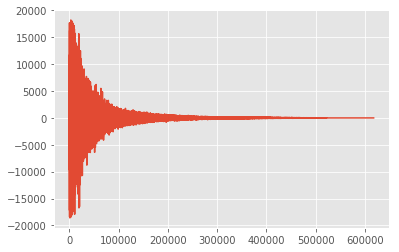

In [21]:
plt.plot(data, '-', )

Let's zoom in on first 1000 frames

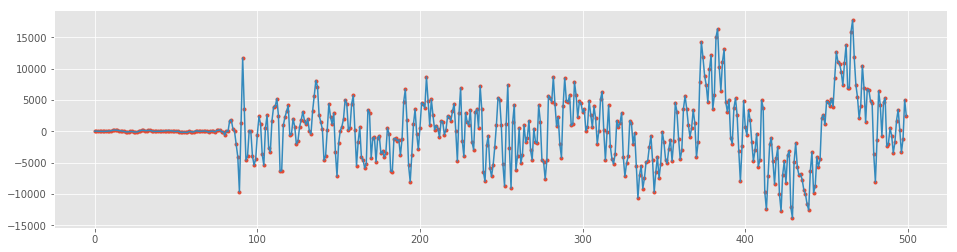

In [22]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

<a id="audio_length"></a>
### Audio Length

We shall now analyze the lengths of the audio files in our dataset

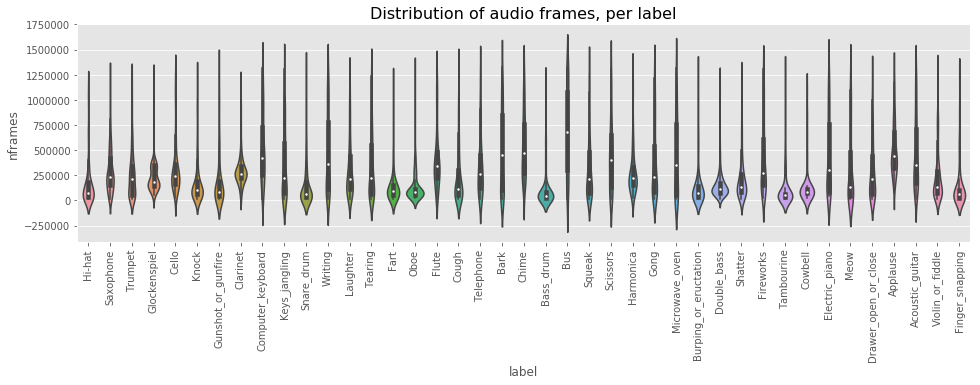

In [24]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('./input/audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('./input/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

We observe:
1. The distribution of audio length across labels is non-uniform and has high variance.

Let's now analyze the frame length distribution in Train and Test.

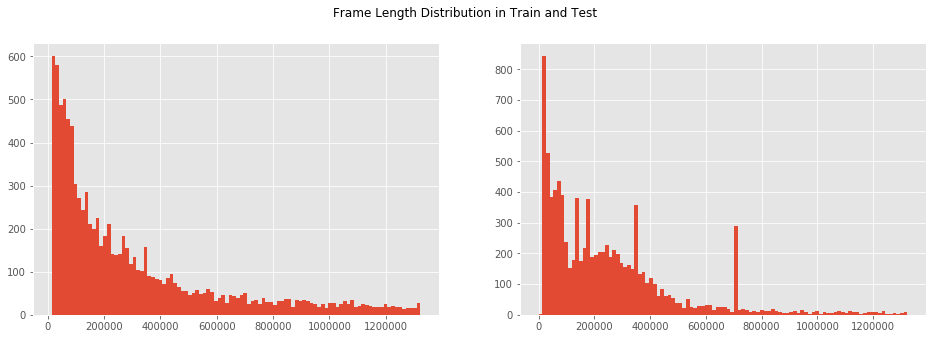

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');

We observe:
1. Majority of the audio files are short.
1. There are four `abnormal` length in the test histogram. Let's analyze them.

In [26]:
abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    print("Frame length = ", length, " Number of files = ", abnormal_fnames.shape[0], end="   ")
    fname = np.random.choice(abnormal_fnames)
    print("Playing ", fname)
    IPython.display.display(ipd.Audio( './input/audio_test/' + fname))

Frame length =  707364  Number of files =  210   Playing  87f52da2.wav


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRmyWFQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YUiWFQAAAP//AQD+/wAA//8BAP//AQD//wAA/v///wEAAAABAAAAAQABAP3/AQAAAAEA/v8AAP///f///////////wAA//8BAP///v8AAAAAAAD+//7/AQAAAP//AQD//wEAAQAAAP7///8AAP7//////wIAAAD+/wAA/////wEA///+/wAA////////AAD/////AAD//wAAAAAAAP7/AAD+/wAAAAD//wAA//8AAP7/AgD///////8AAP////8CAP///v8AAAAA////////AwD///7/AAD//wAAAAD//////////wEAAAD9/wAA//////////8BAAAA/f8AAAAAAAD+//7/AQAAAP//AQAAAP7/AQD/////AAD+/wEAAAD//wAA/v///wAA///+///////+/wAAAQD//wAAAgAAAAEA/v//////AAD/////AAAAAP////8BAP//AAABAP//AAAAAAEAAgD//////v/+//7//v8AAP//AQAAAAAAAAD//////v8AAP7///8AAAAAAgABAAEA//8BAAEAAAD//wAA//8AAAEAAAABAAAAAAD//wAAAAAAAAAAAAAAAAAA/v///////f/+////AAD///////////7/AQD9/wAAAAAAAAAA//////3//v8AAAIAAAD/////AAD///7////+//3//v8AAP7//////wEA/////wAAAAAAAAEA/v///wAA//8AAP//AQABAP///v8AAAEAAAD+/wAA/f///////v/9/wEAAQACAAEAAAAAAP7//////////f/+/wEAAgACAP//AAD/////AQAAAP3//v8AAAAA//8AAAAAAAAAAAAAAAAAAP//AAD+/wAAAQAAAAEA//8AAP///v8AAAEAAgACAP///f8BAP///v///wAAAgD+/wAAAAABAP//AAAAAP7//f/+//3/AAAAAAEAAgABAP///////wAAAQD//wEAAAAAAAEA///+/wEAAgAAAP//AgD//wEAAAD+//////8AAP//AgAAAP////8AAAIA//8AAAIA/f8AAP7////+////AQD+/wAAAAD+/wIA/f8BAP////8BAP7/AAD+////AQD//wIAAgABAAMAAQD//wAAAQD///3/AgD//wIAAQABAAIA/v8BAP7//v8AAPz///8AAAEAAQAAAP7//v/+//7//f8AAP//AQD+/wIAAQAAAP7///8BAPz//v////7/AQD+/wAA/f/+//3//v/+/wAA/////wEA/f/9/wEAAQD+//v/AAAAAAEAAQD+/wEA//8BAAUA/v8BAAAAAQACAP7/AAD//wEAAAD7/wEAAAABAAEAAAD///7//f/+//3//f////3//f8CAPv////+//3//f8BAAAA///+////AAD////////9//3/+//9/wEABAAEAP7//f/9//z//f////z//P8BAP7///8AAPv/+/8CAAEA/v8AAAEAAAACAAAAAAAAAP7///8BAP3/AgD+//7/AAD8//////8CAAMA/f/+/wEAAgD9//7//v/7//7//f/9///////8//z////9//7//P8BAAEA/f8AAP//+/8AAP7//f8AAAIA/v/+//////8AAP7/AAD///////8AAP7///8AAAIAAAACAAEA/f/8//7/AQD9//r//v8DAAEA/v8AAP7//v////7///////3//////wAAAAABAP7////+/wIA/f8BAAcA//8CAAAAAAD//wEA///+////AAD+////AQAAAP///P8BAAEA/v8AAAAAAQD//wUAAwACAAAAAQABAPz//f8AAAMAAwADAAAAAAAAAAQAAQD//wQAAAAFAAMAAAADAAIAAQABAP//BQD+/wMABQD9/wUAAAD6////AwD9/wIA/f8AAAMAAQAAAP//AQD+////+v/7//z/+P/7//3//f/+/wAAAAACAP///P/8//7/AAD//wAAAAABAP7/BAABAAUAAAD9/wEA/f/7////AgD9//z/AgD///7/AQACAAIAAwD7////AwD+////AAD//wAAAAAAAP///P8BAP7//v/9/wEA/f8AAAAA+v/+//r/+v/8//r/+f/6///////9//r////8/wAA///8//3/AAAEAPz////7//n/AQAAAP7/AAAFAP7//v8CAP//AgAAAP//AAD+//3/AwD+//3/AQD+/wAAAAAEAAEA/v8DAP3/AAAAAP7/BAD9/wIAAAD9////AAABAAMA///8/wEABAACAP///v////7/AAABAP//AAACAAAAAAAAAAMAAAABAP7///8CAP3/AgAAAAAAAQABAPv///8AAAEAAgD8/wAAAgACAAEA/P8BAPz//P/+//7////9//7/AgD7//v///8AAP///f/+/wAA+/////3//v/+////AAD9/wQAAQD7/wMAAQACAAEAAQADAP//AQAAAAIAAAACAAIA//////v////9//z/BAABAP3///8BAP///f/+//7//P8BAP3///8AAAAAAwD9/wYAAgADAAEAAAD8////AAD6/wEA+/8BAP7/AQABAP7/BAACAP//AAABAAQA//8AAAEAAQD///7/AgD8/wEA/v/+/wEA/f8AAP/////9/wEA+/8BAP///f8FAP//AgAAAP7/AwD9//z//v/9/wAA/v////7//P8BAAEA/P8CAPr/AgADAPv/4P+x/7D/e/+I/z7/Av8K/9/+qf5R/qb+zv22/f39Nv3x/Wf95Pxj/Wn80PzT/a785vyA/Vj9k/3A/eT+af4N//v/0f7K/qf+BP8U/qj+tQAWAGkA8f9+AMsBgAG7ARUCowFuAKABCwGTATADrwGGArMCaQJiAQUBMAL8AaQB0wAKAQABVgFmAfwAdQAXAEEA0/5xALIAVP4R/8n9o/yj/br9e/43/mb9rPxT/BT8R/vU/IT8qfsI/Dj6YPtC/Mn68fuO+z37z/s4+wz83vvR+7b8Rv1a/BD9Gv5l/OX9e/6R/vP+eP4J/z3/Bf+M/2kAtf6n/6P/aQA8AgYAGQFfAVoB7AEuAS4B3wEPAqwBAgJ8AdYBoQHDAaUCxQEdASQB6QDDAaEDEAPAAYUBoAH9AZIB0v+V/4UAEgA4AAP/0P2Y/iH9X/yJ/Zb95v1c/en7Z/z//Cz9NP1J/PX8KvzE+yr9Qfz0/NL8cvyO/aT8B/3I/Zr9//0v/7n/W/58/gf+fv1Z/8v/dwD4/93/fABY/4kAvwApAX0CHQHJAK8B9AEdAtICIgOQAjEDbQO5AwMEWwPpBAoFpQSIBDkEnwSmA70D+wKOA+oDbwLGArMBIgHQANoAKgEgAHUAYv9K/jH/oP6H/nL/vf5c/YP9bP0P/cH9L/2Q/HX9xvxy+4L8Nvt7+3H+1fz9/NT8efuu/HD95v2i/Yj/qf+//ZP9pv01/wH/VP92/4f+BgDV/5YAYQELAXoBwQA7AtkCZQJZA9IDWQWqBIADSwWDBV8FPQVdBYUGTAUWBf8FygVKBRwF7wVRBbsEVgQ2BX4F+wPKBXoFGwNkAwYDEAMgA4EC0wKJAbEBcgK0AOb+3/5cAaH/ov6qAID/gv6G/aj+SP+8/jf/mf2d/U7+hP2d/KX8pP1b/dD8L/wJ/Y39G/w0/NL8zf7s/k7+oP95/gT/HwDu/yUBEwHhAF8CmgKiAqsDiwNnA68CuAIIBC0FvgXSA6QDWQUsBZUFAgY1BRwFAQVUBWkFrwTUBAoFWwQ+AyYDhgLUAjgDoQFqAeoAWQDIAN0AoABJAHj/ZP/w/mT+AP8o/Xf9uv39/Cz+Rfz/+8D73/pn+yT7Gvxz/BH9NP0l/Un+hf0V/mkAAQDg/zkAKg

Frame length =  353682  Number of files =  127   Playing  1819a7b7.wav


<a id="1d_model_building"></a>
## <center>2. Building a Model using Raw Wave</center>
We will build two models:
1. The first model will take the raw audio (1D array) as input and the primary operation will be Conv1D
2. The second model will take the MFCCs as input. (We will explain MFCC later)

<a id="1d_discription"></a>
### Keras Model using raw wave

Our model has the architecture as follows:
![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

**Important:**
Due to the time limit on Kaggle Kernels, it is not possible to perform 10-fold training of a large model. I have trained the model locally and uploaded its output files as a dataset. If you wish to train the bigger model, change `COMPLETE_RUN = True` at the beginning of the kernel.

#### Some sssential imports

In [28]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

<a id="configuration"></a>
#### Configuration

The Configuration object stores those learning parameters that are shared between data generators, models, and training functions. Anything that is `global` as far as the training is concerned can become the part of Configuration object.

In [11]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

<a id="data_generator"></a>
#### DataGenerator Class

The DataGenerator class inherits from **`keras.utils.Sequence`** . It is useful for preprocessing and feeding the data to a Keras model. 
* Once initialized with a batch_size, it computes the number of batches in an epoch. The **`__len__`** method tells Keras how many batches to draw in each epoch. 
* The **`__getitem__`** method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only `X` is returned.
* If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the **`on_epoch_end`** method.

Note:
**`Sequence`** are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [30]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

<a id="1d_normalization"></a>
#### Normalization

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1]. 

In [31]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

* The dummy model is just for debugging purpose.
* Our 1D Conv model is fairly deep and is trained using Adam Optimizer with a learning rate of 0.0001

In [32]:
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="1d_training"></a>
#### Training 1D Conv

It is important to convert raw labels to integer indices

In [33]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])

# train = train[:2000]
# test = test[:2000]

Here is the code for 10-fold training:
* We use **`from sklearn.cross_validation.StratifiedKFold`** for splitting the trainig data into 10 folds.
* We use some Keras callbacks to monitor the training.
    * **`ModelCheckpoint`** saves the best weight of our model (using validation data). We use this weight to make test predictions.
    * **`EarlyStopping`** stops the training once validation loss ceases to decrease
    * **`TensorBoard`** helps us visualize training and validation loss and accuracy.
* We fit the model using **`DataGenerator`** for training and validation splits. 
* We get both training and test predictions and save them as .npy format. We also generate a submission file. For 10-fold CV, the number of prediction files should be 10. We will ensemble these predictions later.

```python
PREDICTION_FOLDER = "predictions_1d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)

for i, (train_split, val_split) in enumerate(skf):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("Fold: ", i)
    print("#"*50)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)

    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)
    
    model.load_weights('best_%d.h5'%i)
    
    # Save train predictions
    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    # Save test predictions
    test_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
    ```

<a id="1d_ensembling"></a>
#### Ensembling 1D Conv Predictions
Now that we have trained our model, it is time average the predictions of 10-folds. We will try Geometric Mean averaging and see what will be our Public LB score.

pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)

<a id="intro_mfcc"></a>
## <center> 3. Introuction to MFCC

As we have seen in the previous section, our Deep Learning models are powerful enough to classify sounds from the raw audio. We do not require any complex feature engineering. But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the MFCC (Mel Frquency Cepstral Coefficients) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.

If we just want to classify some sound, we should build features that are **speaker independent**. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale. 

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

![http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png](http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png)

<a id="librosa_mfcc"></a>
#### Generating MFCC using Librosa
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

In [1]:
import librosa
SAMPLE_RATE = 44100
fname = './input/audio_train/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

In [5]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

(40, 173)

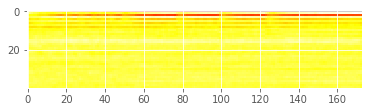

In [6]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

<a id="2d_model_building"></a>
## <center>4. Building a Model using MFCC

We will build now build a 2D Convolutional model using MFCC. 

In [7]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

Using TensorFlow backend.


In [8]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="2d_data"></a>
### Preparing data

In [9]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [12]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
# if not COMPLETE_RUN:
#     config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
#                     max_epochs=1, use_mfcc=True, n_mfcc=40)

In [15]:

X_train = prepare_data(train, config, './input/audio_train/')
X_test = prepare_data(test, config, './input/audio_test/')
y_train = to_categorical(train.label_idx, num_classes=config.n_classes)

TypeError: must be str, not int

<a id="2d_normalization"></a>
#### Normalization


In [47]:

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


<a id="2d_training"></a>
#### Training 2D Conv on MFCC

In [ ]:
PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)
for i, (train_split, val_split) in enumerate(skf):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)


Instructions for updating:
Use the retry module or similar alternatives.


##################################################
Fold:  0


Train on 4729 samples, validate on 4744 samples


Epoch 1/50


  64/4729 [..............................] - ETA: 2:28 - loss: 3.9624 - acc: 0.0156

 128/4729 [..............................] - ETA: 1:57 - loss: 3.9449 - acc: 0.0234

 192/4729 [>.............................] - ETA: 1:47 - loss: 3.8980 - acc: 0.0312

 256/4729 [>.............................] - ETA: 1:41 - loss: 3.8714 - acc: 0.0273

 320/4729 [=>............................] - ETA: 1:37 - loss: 3.8572 - acc: 0.0312

 384/4729 [=>............................] - ETA: 1:34 - loss: 3.8049 - acc: 0.0417

 448/4729 [=>............................] - ETA: 1:32 - loss: 3.7512 - acc: 0.0513

 512/4729 [==>...........................] - ETA: 1:31 - loss: 3.7155 - acc: 0.0625

 576/4729 [==>...........................] - ETA: 1:30 - loss: 3.6852 - acc: 0.0712

 640/4729 [===>..........................] - ETA: 1:32 - loss: 3.6606 - acc: 0.0750

 704/4729 [===>..........................] - ETA: 1:33 - loss: 3.6262 - acc: 0.0824

 768/4729 [===>..........................] - ETA: 1:33 - loss: 3.6090 - acc: 0.0833

 832/4729 [====>.........................] - ETA: 1:32 - loss: 3.5845 - acc: 0.0865

 896/4729 [====>.........................] - ETA: 1:31 - loss: 3.5665 - acc: 0.0904

 960/4729 [=====>........................] - ETA: 1:29 - loss: 3.5557 - acc: 0.0958

1024/4729 [=====>........................] - ETA: 1:27 - loss: 3.5333 - acc: 0.1045

1088/4729 [=====>........................] - ETA: 1:26 - loss: 3.5120 - acc: 0.1094

1152/4729 [======>.......................] - ETA: 1:24 - loss: 3.5049 - acc: 0.1094

1216/4729 [======>.......................] - ETA: 1:22 - loss: 3.4997 - acc: 0.1127

1280/4729 [=======>......................] - ETA: 1:21 - loss: 3.4877 - acc: 0.1156

1344/4729 [=======>......................] - ETA: 1:19 - loss: 3.4753 - acc: 0.1168

1408/4729 [=======>......................] - ETA: 1:18 - loss: 3.4558 - acc: 0.1229

1472/4729 [========>.....................] - ETA: 1:16 - loss: 3.4540 - acc: 0.1236

1536/4729 [========>.....................] - ETA: 1:14 - loss: 3.4485 - acc: 0.1243

1600/4729 [=========>....................] - ETA: 1:13 - loss: 3.4410 - acc: 0.1231

1664/4729 [=========>....................] - ETA: 1:11 - loss: 3.4310 - acc: 0.1238

1728/4729 [=========>....................] - ETA: 1:09 - loss: 3.4273 - acc: 0.1227

1792/4729 [==========>...................] - ETA: 1:08 - loss: 3.4159 - acc: 0.1272

1856/4729 [==========>...................] - ETA: 1:06 - loss: 3.4064 - acc: 0.1293

1920/4729 [===========>..................] - ETA: 1:04 - loss: 3.3991 - acc: 0.1297

1984/4729 [===========>..................] - ETA: 1:03 - loss: 3.3863 - acc: 0.1300

2048/4729 [===========>..................] - ETA: 1:01 - loss: 3.3816 - acc: 0.1289

2112/4729 [============>.................] - ETA: 1:00 - loss: 3.3787 - acc: 0.1288

2176/4729 [============>.................] - ETA: 58s - loss: 3.3697 - acc: 0.1296 

2240/4729 [=============>................] - ETA: 57s - loss: 3.3620 - acc: 0.1295

2304/4729 [=============>................] - ETA: 55s - loss: 3.3521 - acc: 0.1319

2368/4729 [==============>...............] - ETA: 54s - loss: 3.3457 - acc: 0.1322

2432/4729 [==============>...............] - ETA: 52s - loss: 3.3359 - acc: 0.1361

2496/4729 [==============>...............] - ETA: 51s - loss: 3.3274 - acc: 0.1382

2560/4729 [===============>..............] - ETA: 49s - loss: 3.3244 - acc: 0.1383

2624/4729 [===============>..............] - ETA: 48s - loss: 3.3171 - acc: 0.1406

2688/4729 [================>.............] - ETA: 46s - loss: 3.3072 - acc: 0.1421

2752/4729 [================>.............] - ETA: 45s - loss: 3.2975 - acc: 0.1443

2816/4729 [================>.............] - ETA: 43s - loss: 3.2920 - acc: 0.1445

2880/4729 [=================>............] - ETA: 41s - loss: 3.2894 - acc: 0.1455

2944/4729 [=================>............] - ETA: 40s - loss: 3.2813 - acc: 0.1478

3008/4729 [==================>...........] - ETA: 38s - loss: 3.2740 - acc: 0.1486

3072/4729 [==================>...........] - ETA: 37s - loss: 3.2685 - acc: 0.1491

3136/4729 [==================>...........] - ETA: 35s - loss: 3.2632 - acc: 0.1508

3200/4729 [===================>..........] - ETA: 34s - loss: 3.2579 - acc: 0.1512

3264/4729 [===================>..........] - ETA: 33s - loss: 3.2504 - acc: 0.1526

3328/4729 [====================>.........] - ETA: 31s - loss: 3.2447 - acc: 0.1547

3392/4729 [====================>.........] - ETA: 30s - loss: 3.2388 - acc: 0.1562

3456/4729 [====================>.........] - ETA: 28s - loss: 3.2315 - acc: 0.1589

3520/4729 [=====================>........] - ETA: 27s - loss: 3.2274 - acc: 0.1602

3584/4729 [=====================>........] - ETA: 25s - loss: 3.2244 - acc: 0.1602

3648/4729 [======================>.......] - ETA: 24s - loss: 3.2188 - acc: 0.1617

3712/4729 [======================>.......] - ETA: 22s - loss: 3.2136 - acc: 0.1619

3776/4729 [======================>.......] - ETA: 21s - loss: 3.2082 - acc: 0.1629

3840/4729 [=======================>......] - ETA: 20s - loss: 3.2050 - acc: 0.1630

3904/4729 [=======================>......] - ETA: 18s - loss: 3.2036 - acc: 0.1627

3968/4729 [========================>.....] - ETA: 17s - loss: 3.1970 - acc: 0.1646

4032/4729 [========================>.....] - ETA: 15s - loss: 3.1915 - acc: 0.1654

4096/4729 [========================>.....] - ETA: 14s - loss: 3.1851 - acc: 0.1672

4160/4729 [=========================>....] - ETA: 12s - loss: 3.1811 - acc: 0.1678

4224/4729 [=========================>....] - ETA: 11s - loss: 3.1745 - acc: 0.1686

4288/4729 [==========================>...] - ETA: 10s - loss: 3.1690 - acc: 0.1702

4352/4729 [==========================>...] - ETA: 8s - loss: 3.1659 - acc: 0.1700 

4416/4729 [===========================>..] - ETA: 7s - loss: 3.1615 - acc: 0.1710

4480/4729 [===========================>..] - ETA: 5s - loss: 3.1591 - acc: 0.1714

4544/4729 [===========================>..] - ETA: 4s - loss: 3.1550 - acc: 0.1732

4608/4729 [============================>.] - ETA: 2s - loss: 3.1494 - acc: 0.1743

4672/4729 [============================>.] - ETA: 1s - loss: 3.1455 - acc: 0.1759

4729/4729 [==============================] - 143s 30ms/step - loss: 3.1431 - acc: 0.1755 - val_loss: 2.7906 - val_acc: 0.2300



Epoch 00001: val_loss improved from inf to 2.79060, saving model to best_0.h5


Epoch 2/50


  64/4729 [..............................] - ETA: 1:49 - loss: 2.7538 - acc: 0.3125

 128/4729 [..............................] - ETA: 1:50 - loss: 2.7852 - acc: 0.2812

 192/4729 [>.............................] - ETA: 1:47 - loss: 2.6900 - acc: 0.3073

 256/4729 [>.............................] - ETA: 1:44 - loss: 2.7206 - acc: 0.2891

 320/4729 [=>............................] - ETA: 1:42 - loss: 2.7146 - acc: 0.2875

 384/4729 [=>............................] - ETA: 1:40 - loss: 2.7045 - acc: 0.2917

 448/4729 [=>............................] - ETA: 1:39 - loss: 2.7067 - acc: 0.2857

 512/4729 [==>...........................] - ETA: 1:38 - loss: 2.6695 - acc: 0.2949

 576/4729 [==>...........................] - ETA: 1:36 - loss: 2.6762 - acc: 0.2951

 640/4729 [===>..........................] - ETA: 1:35 - loss: 2.6682 - acc: 0.2953

 704/4729 [===>..........................] - ETA: 1:33 - loss: 2.6444 - acc: 0.3068

 768/4729 [===>..........................] - ETA: 1:32 - loss: 2.6593 - acc: 0.2956

 832/4729 [====>.........................] - ETA: 1:32 - loss: 2.6766 - acc: 0.2885

 896/4729 [====>.........................] - ETA: 1:32 - loss: 2.6658 - acc: 0.2891

 960/4729 [=====>........................] - ETA: 1:33 - loss: 2.6672 - acc: 0.2885

1024/4729 [=====>........................] - ETA: 1:33 - loss: 2.6794 - acc: 0.2822

1088/4729 [=====>........................] - ETA: 1:32 - loss: 2.6676 - acc: 0.2858

1152/4729 [======>.......................] - ETA: 1:30 - loss: 2.6633 - acc: 0.2856

1216/4729 [======>.......................] - ETA: 1:30 - loss: 2.6606 - acc: 0.2870

1280/4729 [=======>......................] - ETA: 1:32 - loss: 2.6619 - acc: 0.2859

1344/4729 [=======>......................] - ETA: 1:33 - loss: 2.6515 - acc: 0.2939

1408/4729 [=======>......................] - ETA: 1:33 - loss: 2.6526 - acc: 0.2919

1472/4729 [========>.....................] - ETA: 1:33 - loss: 2.6488 - acc: 0.2921

1536/4729 [========>.....................] - ETA: 1:32 - loss: 2.6499 - acc: 0.2943

1600/4729 [=========>....................] - ETA: 1:30 - loss: 2.6431 - acc: 0.2981

1664/4729 [=========>....................] - ETA: 1:29 - loss: 2.6459 - acc: 0.2981

1728/4729 [=========>....................] - ETA: 1:28 - loss: 2.6458 - acc: 0.2975

1792/4729 [==========>...................] - ETA: 1:27 - loss: 2.6433 - acc: 0.2991

1856/4729 [==========>...................] - ETA: 1:25 - loss: 2.6449 - acc: 0.2990

1920/4729 [===========>..................] - ETA: 1:24 - loss: 2.6552 - acc: 0.2958

1984/4729 [===========>..................] - ETA: 1:23 - loss: 2.6525 - acc: 0.2949

2048/4729 [===========>..................] - ETA: 1:21 - loss: 2.6520 - acc: 0.2939

2112/4729 [============>.................] - ETA: 1:20 - loss: 2.6541 - acc: 0.2936

2176/4729 [============>.................] - ETA: 1:19 - loss: 2.6544 - acc: 0.2923

2240/4729 [=============>................] - ETA: 1:18 - loss: 2.6535 - acc: 0.2942

2304/4729 [=============>................] - ETA: 1:18 - loss: 2.6488 - acc: 0.2951

2368/4729 [==============>...............] - ETA: 1:16 - loss: 2.6453 - acc: 0.2956

2432/4729 [==============>...............] - ETA: 1:14 - loss: 2.6512 - acc: 0.2944

2496/4729 [==============>...............] - ETA: 1:12 - loss: 2.6542 - acc: 0.2945

2560/4729 [===============>..............] - ETA: 1:10 - loss: 2.6519 - acc: 0.2949

2624/4729 [===============>..............] - ETA: 1:08 - loss: 2.6480 - acc: 0.2965

2688/4729 [================>.............] - ETA: 1:05 - loss: 2.6429 - acc: 0.2965

2752/4729 [================>.............] - ETA: 1:03 - loss: 2.6522 - acc: 0.2932

2816/4729 [================>.............] - ETA: 1:01 - loss: 2.6507 - acc: 0.2930

2880/4729 [=================>............] - ETA: 58s - loss: 2.6533 - acc: 0.2917 

2944/4729 [=================>............] - ETA: 56s - loss: 2.6524 - acc: 0.2918

3008/4729 [==================>...........] - ETA: 54s - loss: 2.6529 - acc: 0.2919

3072/4729 [==================>...........] - ETA: 52s - loss: 2.6489 - acc: 0.2936

3136/4729 [==================>...........] - ETA: 49s - loss: 2.6479 - acc: 0.2934

3200/4729 [===================>..........] - ETA: 47s - loss: 2.6442 - acc: 0.2953

3264/4729 [===================>..........] - ETA: 45s - loss: 2.6427 - acc: 0.2953

3328/4729 [====================>.........] - ETA: 43s - loss: 2.6412 - acc: 0.2942

3392/4729 [====================>.........] - ETA: 41s - loss: 2.6378 - acc: 0.2954

3456/4729 [====================>.........] - ETA: 38s - loss: 2.6362 - acc: 0.2960

3520/4729 [=====================>........] - ETA: 36s - loss: 2.6328 - acc: 0.2980

3584/4729 [=====================>........] - ETA: 34s - loss: 2.6313 - acc: 0.2983

3648/4729 [======================>.......] - ETA: 32s - loss: 2.6317 - acc: 0.2980

3712/4729 [======================>.......] - ETA: 30s - loss: 2.6273 - acc: 0.2998

3776/4729 [======================>.......] - ETA: 28s - loss: 2.6289 - acc: 0.3001

3840/4729 [=======================>......] - ETA: 26s - loss: 2.6240 - acc: 0.3021

3904/4729 [=======================>......] - ETA: 24s - loss: 2.6223 - acc: 0.3017

3968/4729 [========================>.....] - ETA: 22s - loss: 2.6207 - acc: 0.3009

4032/4729 [========================>.....] - ETA: 21s - loss: 2.6155 - acc: 0.3016

4096/4729 [========================>.....] - ETA: 19s - loss: 2.6142 - acc: 0.3020

4160/4729 [=========================>....] - ETA: 17s - loss: 2.6133 - acc: 0.3017

4224/4729 [=========================>....] - ETA: 15s - loss: 2.6104 - acc: 0.3035

4288/4729 [==========================>...] - ETA: 13s - loss: 2.6052 - acc: 0.3053

4352/4729 [==========================>...] - ETA: 11s - loss: 2.6038 - acc: 0.3065

4416/4729 [===========================>..] - ETA: 9s - loss: 2.6028 - acc: 0.3068 

4480/4729 [===========================>..] - ETA: 7s - loss: 2.5992 - acc: 0.3083

4544/4729 [===========================>..] - ETA: 5s - loss: 2.5973 - acc: 0.3079

4608/4729 [============================>.] - ETA: 3s - loss: 2.5940 - acc: 0.3095

4672/4729 [============================>.] - ETA: 1s - loss: 2.5917 - acc: 0.3089

4729/4729 [==============================] - 182s 38ms/step - loss: 2.5887 - acc: 0.3092 - val_loss: 2.7107 - val_acc: 0.2601



Epoch 00002: val_loss improved from 2.79060 to 2.71070, saving model to best_0.h5
Epoch 3/50


  64/4729 [..............................] - ETA: 1:58 - loss: 2.3626 - acc: 0.3281

 128/4729 [..............................] - ETA: 1:57 - loss: 2.4252 - acc: 0.3438

 192/4729 [>.............................] - ETA: 1:55 - loss: 2.4135 - acc: 0.3594

 256/4729 [>.............................] - ETA: 1:53 - loss: 2.4119 - acc: 0.3516

 320/4729 [=>............................] - ETA: 1:54 - loss: 2.3847 - acc: 0.3781

 384/4729 [=>............................] - ETA: 1:52 - loss: 2.3735 - acc: 0.3750

 448/4729 [=>............................] - ETA: 1:49 - loss: 2.3521 - acc: 0.3951

 512/4729 [==>...........................] - ETA: 1:47 - loss: 2.3399 - acc: 0.4004

 576/4729 [==>...........................] - ETA: 1:44 - loss: 2.3485 - acc: 0.3976

 640/4729 [===>..........................] - ETA: 1:42 - loss: 2.3304 - acc: 0.4047

 704/4729 [===>..........................] - ETA: 1:40 - loss: 2.3138 - acc: 0.4034

 768/4729 [===>..........................] - ETA: 1:37 - loss: 2.3000 - acc: 0.4128

 832/4729 [====>.........................] - ETA: 1:35 - loss: 2.3087 - acc: 0.4111

 896/4729 [====>.........................] - ETA: 1:33 - loss: 2.3075 - acc: 0.4051

 960/4729 [=====>........................] - ETA: 1:32 - loss: 2.3151 - acc: 0.4010

1024/4729 [=====>........................] - ETA: 1:30 - loss: 2.3261 - acc: 0.3965

1088/4729 [=====>........................] - ETA: 1:28 - loss: 2.3254 - acc: 0.3943

1152/4729 [======>.......................] - ETA: 1:26 - loss: 2.3284 - acc: 0.3915

1216/4729 [======>.......................] - ETA: 1:24 - loss: 2.3258 - acc: 0.3931

1280/4729 [=======>......................] - ETA: 1:23 - loss: 2.3229 - acc: 0.3914

1344/4729 [=======>......................] - ETA: 1:21 - loss: 2.3177 - acc: 0.3943

1408/4729 [=======>......................] - ETA: 1:19 - loss: 2.3165 - acc: 0.4006

1472/4729 [========>.....................] - ETA: 1:17 - loss: 2.3075 - acc: 0.4035

1536/4729 [========>.....................] - ETA: 1:16 - loss: 2.3074 - acc: 0.4036

1600/4729 [=========>....................] - ETA: 1:14 - loss: 2.2987 - acc: 0.4050

1664/4729 [=========>....................] - ETA: 1:12 - loss: 2.2988 - acc: 0.4038

1728/4729 [=========>....................] - ETA: 1:11 - loss: 2.2897 - acc: 0.4051

1792/4729 [==========>...................] - ETA: 1:09 - loss: 2.2964 - acc: 0.4023

1856/4729 [==========>...................] - ETA: 1:08 - loss: 2.2982 - acc: 0.4003

1920/4729 [===========>..................] - ETA: 1:06 - loss: 2.2947 - acc: 0.4000

1984/4729 [===========>..................] - ETA: 1:05 - loss: 2.2974 - acc: 0.3977

2048/4729 [===========>..................] - ETA: 1:03 - loss: 2.3038 - acc: 0.3960

2112/4729 [============>.................] - ETA: 1:01 - loss: 2.3013 - acc: 0.3958

2176/4729 [============>.................] - ETA: 1:00 - loss: 2.3004 - acc: 0.3938

2240/4729 [=============>................] - ETA: 58s - loss: 2.2975 - acc: 0.3924 

2304/4729 [=============>................] - ETA: 57s - loss: 2.2899 - acc: 0.3932

2368/4729 [==============>...............] - ETA: 55s - loss: 2.2920 - acc: 0.3944

2432/4729 [==============>...............] - ETA: 54s - loss: 2.2950 - acc: 0.3927

2496/4729 [==============>...............] - ETA: 52s - loss: 2.2863 - acc: 0.3950

2560/4729 [===============>..............] - ETA: 50s - loss: 2.2905 - acc: 0.3945

2624/4729 [===============>..............] - ETA: 49s - loss: 2.2898 - acc: 0.3937

2688/4729 [================>.............] - ETA: 47s - loss: 2.2841 - acc: 0.3958

2752/4729 [================>.............] - ETA: 46s - loss: 2.2878 - acc: 0.3946

2816/4729 [================>.............] - ETA: 44s - loss: 2.2824 - acc: 0.3970

2880/4729 [=================>............] - ETA: 43s - loss: 2.2847 - acc: 0.3958

2944/4729 [=================>............] - ETA: 41s - loss: 2.2825 - acc: 0.3964

3008/4729 [==================>...........] - ETA: 40s - loss: 2.2786 - acc: 0.3983

3072/4729 [==================>...........] - ETA: 38s - loss: 2.2755 - acc: 0.3981

3136/4729 [==================>...........] - ETA: 37s - loss: 2.2748 - acc: 0.3970

3200/4729 [===================>..........] - ETA: 35s - loss: 2.2703 - acc: 0.3981

3264/4729 [===================>..........] - ETA: 34s - loss: 2.2666 - acc: 0.3989

3328/4729 [====================>.........] - ETA: 32s - loss: 2.2664 - acc: 0.3984

3392/4729 [====================>.........] - ETA: 31s - loss: 2.2671 - acc: 0.3995

3456/4729 [====================>.........] - ETA: 29s - loss: 2.2678 - acc: 0.3987

3520/4729 [=====================>........] - ETA: 28s - loss: 2.2699 - acc: 0.3980

3584/4729 [=====================>........] - ETA: 26s - loss: 2.2694 - acc: 0.3979

3648/4729 [======================>.......] - ETA: 25s - loss: 2.2702 - acc: 0.3991

3712/4729 [======================>.......] - ETA: 23s - loss: 2.2658 - acc: 0.3998

3776/4729 [======================>.......] - ETA: 22s - loss: 2.2621 - acc: 0.4010

3840/4729 [=======================>......] - ETA: 20s - loss: 2.2592 - acc: 0.4026

3904/4729 [=======================>......] - ETA: 19s - loss: 2.2638 - acc: 0.4014

3968/4729 [========================>.....] - ETA: 17s - loss: 2.2655 - acc: 0.4010

4032/4729 [========================>.....] - ETA: 16s - loss: 2.2659 - acc: 0.4013

4096/4729 [========================>.....] - ETA: 14s - loss: 2.2665 - acc: 0.4001

4160/4729 [=========================>....] - ETA: 13s - loss: 2.2645 - acc: 0.4014

4224/4729 [=========================>....] - ETA: 11s - loss: 2.2637 - acc: 0.4025

4288/4729 [==========================>...] - ETA: 10s - loss: 2.2630 - acc: 0.4021

4352/4729 [==========================>...] - ETA: 8s - loss: 2.2605 - acc: 0.4023 

4416/4729 [===========================>..] - ETA: 7s - loss: 2.2580 - acc: 0.4033

4480/4729 [===========================>..] - ETA: 5s - loss: 2.2585 - acc: 0.4029

4544/4729 [===========================>..] - ETA: 4s - loss: 2.2557 - acc: 0.4034

4608/4729 [============================>.] - ETA: 2s - loss: 2.2555 - acc: 0.4034

4672/4729 [============================>.] - ETA: 1s - loss: 2.2533 - acc: 0.4037

4729/4729 [==============================] - 142s 30ms/step - loss: 2.2539 - acc: 0.4035 - val_loss: 2.4354 - val_acc: 0.3478



Epoch 00003: val_loss improved from 2.71070 to 2.43535, saving model to best_0.h5
Epoch 4/50


  64/4729 [..............................] - ETA: 1:47 - loss: 2.0536 - acc: 0.5469

 128/4729 [..............................] - ETA: 1:46 - loss: 2.0277 - acc: 0.5312

 192/4729 [>.............................] - ETA: 1:45 - loss: 2.1111 - acc: 0.4948

 256/4729 [>.............................] - ETA: 1:42 - loss: 2.0491 - acc: 0.4922

 320/4729 [=>............................] - ETA: 1:40 - loss: 2.0707 - acc: 0.4750

 384/4729 [=>............................] - ETA: 1:38 - loss: 2.0680 - acc: 0.4661

 448/4729 [=>............................] - ETA: 1:37 - loss: 2.0879 - acc: 0.4643

 512/4729 [==>...........................] - ETA: 1:35 - loss: 2.0946 - acc: 0.4648

 576/4729 [==>...........................] - ETA: 1:33 - loss: 2.0715 - acc: 0.4705

 640/4729 [===>..........................] - ETA: 1:32 - loss: 2.0709 - acc: 0.4719

 704/4729 [===>..........................] - ETA: 1:30 - loss: 2.0806 - acc: 0.4673

 768/4729 [===>..........................] - ETA: 1:29 - loss: 2.0996 - acc: 0.4583

 832/4729 [====>.........................] - ETA: 1:28 - loss: 2.0932 - acc: 0.4639

 896/4729 [====>.........................] - ETA: 1:27 - loss: 2.0723 - acc: 0.4721

 960/4729 [=====>........................] - ETA: 1:27 - loss: 2.0590 - acc: 0.4719

1024/4729 [=====>........................] - ETA: 1:27 - loss: 2.0799 - acc: 0.4590

1088/4729 [=====>........................] - ETA: 1:27 - loss: 2.0557 - acc: 0.4688

1152/4729 [======>.......................] - ETA: 1:27 - loss: 2.0615 - acc: 0.4661

1216/4729 [======>.......................] - ETA: 1:28 - loss: 2.0718 - acc: 0.4638

1280/4729 [=======>......................] - ETA: 1:28 - loss: 2.0698 - acc: 0.4648

1344/4729 [=======>......................] - ETA: 1:26 - loss: 2.0798 - acc: 0.4591

1408/4729 [=======>......................] - ETA: 1:26 - loss: 2.0864 - acc: 0.4581

1472/4729 [========>.....................] - ETA: 1:25 - loss: 2.1017 - acc: 0.4545

1536/4729 [========>.....................] - ETA: 1:25 - loss: 2.1061 - acc: 0.4505

1600/4729 [=========>....................] - ETA: 1:25 - loss: 2.0975 - acc: 0.4519

1664/4729 [=========>....................] - ETA: 1:25 - loss: 2.1002 - acc: 0.4489

1728/4729 [=========>....................] - ETA: 1:24 - loss: 2.0986 - acc: 0.4485

1792/4729 [==========>...................] - ETA: 1:23 - loss: 2.0989 - acc: 0.4459

1856/4729 [==========>...................] - ETA: 1:21 - loss: 2.0951 - acc: 0.4445

1920/4729 [===========>..................] - ETA: 1:20 - loss: 2.0903 - acc: 0.4469

1984/4729 [===========>..................] - ETA: 1:18 - loss: 2.0915 - acc: 0.4476

2048/4729 [===========>..................] - ETA: 1:16 - loss: 2.0880 - acc: 0.4473

2112/4729 [============>.................] - ETA: 1:13 - loss: 2.0813 - acc: 0.4503

2176/4729 [============>.................] - ETA: 1:11 - loss: 2.0817 - acc: 0.4513

2240/4729 [=============>................] - ETA: 1:09 - loss: 2.0817 - acc: 0.4518

2304/4729 [=============>................] - ETA: 1:07 - loss: 2.0741 - acc: 0.4562

2368/4729 [==============>...............] - ETA: 1:06 - loss: 2.0714 - acc: 0.4557

2432/4729 [==============>...............] - ETA: 1:04 - loss: 2.0695 - acc: 0.4560

2496/4729 [==============>...............] - ETA: 1:02 - loss: 2.0652 - acc: 0.4563

2560/4729 [===============>..............] - ETA: 1:00 - loss: 2.0602 - acc: 0.4566

2624/4729 [===============>..............] - ETA: 58s - loss: 2.0598 - acc: 0.4566 

2688/4729 [================>.............] - ETA: 56s - loss: 2.0588 - acc: 0.4568

2752/4729 [================>.............] - ETA: 54s - loss: 2.0590 - acc: 0.4564

2816/4729 [================>.............] - ETA: 52s - loss: 2.0537 - acc: 0.4588

2880/4729 [=================>............] - ETA: 50s - loss: 2.0472 - acc: 0.4611

2944/4729 [=================>............] - ETA: 48s - loss: 2.0466 - acc: 0.4606

3008/4729 [==================>...........] - ETA: 47s - loss: 2.0453 - acc: 0.4604

3072/4729 [==================>...........] - ETA: 45s - loss: 2.0429 - acc: 0.4613

3136/4729 [==================>...........] - ETA: 43s - loss: 2.0401 - acc: 0.4611

3200/4729 [===================>..........] - ETA: 41s - loss: 2.0405 - acc: 0.4612

3264/4729 [===================>..........] - ETA: 40s - loss: 2.0408 - acc: 0.4611

3328/4729 [====================>.........] - ETA: 38s - loss: 2.0395 - acc: 0.4615

3392/4729 [====================>.........] - ETA: 36s - loss: 2.0377 - acc: 0.4629

3456/4729 [====================>.........] - ETA: 35s - loss: 2.0362 - acc: 0.4621

3520/4729 [=====================>........] - ETA: 33s - loss: 2.0336 - acc: 0.4642

3584/4729 [=====================>........] - ETA: 31s - loss: 2.0347 - acc: 0.4640

3648/4729 [======================>.......] - ETA: 30s - loss: 2.0292 - acc: 0.4657

3712/4729 [======================>.......] - ETA: 28s - loss: 2.0278 - acc: 0.4663

3776/4729 [======================>.......] - ETA: 26s - loss: 2.0298 - acc: 0.4656

3840/4729 [=======================>......] - ETA: 24s - loss: 2.0300 - acc: 0.4646

3904/4729 [=======================>......] - ETA: 23s - loss: 2.0236 - acc: 0.4672

3968/4729 [========================>.....] - ETA: 21s - loss: 2.0164 - acc: 0.4695

4032/4729 [========================>.....] - ETA: 19s - loss: 2.0161 - acc: 0.4695

4096/4729 [========================>.....] - ETA: 17s - loss: 2.0132 - acc: 0.4695

4160/4729 [=========================>....] - ETA: 16s - loss: 2.0117 - acc: 0.4707

4224/4729 [=========================>....] - ETA: 14s - loss: 2.0065 - acc: 0.4723

4288/4729 [==========================>...] - ETA: 12s - loss: 2.0048 - acc: 0.4718

4352/4729 [==========================>...] - ETA: 10s - loss: 2.0071 - acc: 0.4713

4416/4729 [===========================>..] - ETA: 8s - loss: 2.0027 - acc: 0.4721 

4480/4729 [===========================>..] - ETA: 7s - loss: 2.0045 - acc: 0.4712

4544/4729 [===========================>..] - ETA: 5s - loss: 2.0059 - acc: 0.4707

4608/4729 [============================>.] - ETA: 3s - loss: 2.0050 - acc: 0.4709

4672/4729 [============================>.] - ETA: 1s - loss: 2.0021 - acc: 0.4715

4729/4729 [==============================] - 166s 35ms/step - loss: 2.0009 - acc: 0.4709 - val_loss: 2.1491 - val_acc: 0.4195



Epoch 00004: val_loss improved from 2.43535 to 2.14908, saving model to best_0.h5
Epoch 5/50


  64/4729 [..............................] - ETA: 1:58 - loss: 1.8502 - acc: 0.4844

 128/4729 [..............................] - ETA: 1:53 - loss: 1.8637 - acc: 0.4844

 192/4729 [>.............................] - ETA: 1:50 - loss: 1.8754 - acc: 0.4948

 256/4729 [>.............................] - ETA: 1:48 - loss: 1.8326 - acc: 0.5273

 320/4729 [=>............................] - ETA: 1:45 - loss: 1.8691 - acc: 0.4969

 384/4729 [=>............................] - ETA: 1:42 - loss: 1.8844 - acc: 0.4896

 448/4729 [=>............................] - ETA: 1:40 - loss: 1.8674 - acc: 0.4911

 512/4729 [==>...........................] - ETA: 1:39 - loss: 1.8562 - acc: 0.4941

 576/4729 [==>...........................] - ETA: 1:37 - loss: 1.8225 - acc: 0.5069

 640/4729 [===>..........................] - ETA: 1:35 - loss: 1.8123 - acc: 0.5109

 704/4729 [===>..........................] - ETA: 1:33 - loss: 1.7846 - acc: 0.5270

 768/4729 [===>..........................] - ETA: 1:31 - loss: 1.7948 - acc: 0.5208

 832/4729 [====>.........................] - ETA: 1:30 - loss: 1.7860 - acc: 0.5180

 896/4729 [====>.........................] - ETA: 1:29 - loss: 1.7914 - acc: 0.5190

 960/4729 [=====>........................] - ETA: 1:27 - loss: 1.7888 - acc: 0.5167

1024/4729 [=====>........................] - ETA: 1:26 - loss: 1.7719 - acc: 0.5225

1088/4729 [=====>........................] - ETA: 1:24 - loss: 1.7823 - acc: 0.5211

1152/4729 [======>.......................] - ETA: 1:23 - loss: 1.7935 - acc: 0.5208

1216/4729 [======>.......................] - ETA: 1:21 - loss: 1.8032 - acc: 0.5181

1280/4729 [=======>......................] - ETA: 1:20 - loss: 1.7956 - acc: 0.5219

1344/4729 [=======>......................] - ETA: 1:19 - loss: 1.7902 - acc: 0.5231

1408/4729 [=======>......................] - ETA: 1:17 - loss: 1.7885 - acc: 0.5241

1472/4729 [========>.....................] - ETA: 1:16 - loss: 1.7900 - acc: 0.5190

1536/4729 [========>.....................] - ETA: 1:14 - loss: 1.7923 - acc: 0.5169

1600/4729 [=========>....................] - ETA: 1:13 - loss: 1.7971 - acc: 0.5150

1664/4729 [=========>....................] - ETA: 1:11 - loss: 1.7935 - acc: 0.5156

1728/4729 [=========>....................] - ETA: 1:10 - loss: 1.7918 - acc: 0.5208

1792/4729 [==========>...................] - ETA: 1:09 - loss: 1.7999 - acc: 0.5190

1856/4729 [==========>...................] - ETA: 1:07 - loss: 1.8015 - acc: 0.5183

1920/4729 [===========>..................] - ETA: 1:06 - loss: 1.7948 - acc: 0.5219

1984/4729 [===========>..................] - ETA: 1:04 - loss: 1.7944 - acc: 0.5212

2048/4729 [===========>..................] - ETA: 1:03 - loss: 1.7956 - acc: 0.5205

2112/4729 [============>.................] - ETA: 1:01 - loss: 1.7931 - acc: 0.5218

2176/4729 [============>.................] - ETA: 1:00 - loss: 1.7868 - acc: 0.5239

2240/4729 [=============>................] - ETA: 58s - loss: 1.7866 - acc: 0.5237 

2304/4729 [=============>................] - ETA: 57s - loss: 1.7881 - acc: 0.5208

2368/4729 [==============>...............] - ETA: 55s - loss: 1.7896 - acc: 0.5207

2432/4729 [==============>...............] - ETA: 54s - loss: 1.7912 - acc: 0.5201

2496/4729 [==============>...............] - ETA: 52s - loss: 1.7855 - acc: 0.5224

2560/4729 [===============>..............] - ETA: 51s - loss: 1.7951 - acc: 0.5191

2624/4729 [===============>..............] - ETA: 49s - loss: 1.7918 - acc: 0.5194

2688/4729 [================>.............] - ETA: 48s - loss: 1.7964 - acc: 0.5179

2752/4729 [================>.............] - ETA: 46s - loss: 1.7893 - acc: 0.5214

2816/4729 [================>.............] - ETA: 45s - loss: 1.7868 - acc: 0.5231

2880/4729 [=================>............] - ETA: 43s - loss: 1.7946 - acc: 0.5215

2944/4729 [=================>............] - ETA: 42s - loss: 1.7908 - acc: 0.5228

3008/4729 [==================>...........] - ETA: 40s - loss: 1.7855 - acc: 0.5236

3072/4729 [==================>...........] - ETA: 39s - loss: 1.7885 - acc: 0.5234

3136/4729 [==================>...........] - ETA: 37s - loss: 1.7896 - acc: 0.5226

3200/4729 [===================>..........] - ETA: 36s - loss: 1.7909 - acc: 0.5225

3264/4729 [===================>..........] - ETA: 34s - loss: 1.7904 - acc: 0.5218

3328/4729 [====================>.........] - ETA: 33s - loss: 1.7955 - acc: 0.5192

3392/4729 [====================>.........] - ETA: 31s - loss: 1.7942 - acc: 0.5189

3456/4729 [====================>.........] - ETA: 30s - loss: 1.7961 - acc: 0.5194

3520/4729 [=====================>........] - ETA: 28s - loss: 1.7938 - acc: 0.5207

3584/4729 [=====================>........] - ETA: 27s - loss: 1.7921 - acc: 0.5218

3648/4729 [======================>.......] - ETA: 25s - loss: 1.7950 - acc: 0.5219

3712/4729 [======================>.......] - ETA: 24s - loss: 1.7930 - acc: 0.5234

3776/4729 [======================>.......] - ETA: 22s - loss: 1.7899 - acc: 0.5241

3840/4729 [=======================>......] - ETA: 20s - loss: 1.7949 - acc: 0.5216

3904/4729 [=======================>......] - ETA: 19s - loss: 1.7968 - acc: 0.5215

3968/4729 [========================>.....] - ETA: 17s - loss: 1.7963 - acc: 0.5217

4032/4729 [========================>.....] - ETA: 16s - loss: 1.7902 - acc: 0.5246

4096/4729 [========================>.....] - ETA: 14s - loss: 1.7869 - acc: 0.5261

4160/4729 [=========================>....] - ETA: 13s - loss: 1.7888 - acc: 0.5262

4224/4729 [=========================>....] - ETA: 11s - loss: 1.7926 - acc: 0.5241

4288/4729 [==========================>...] - ETA: 10s - loss: 1.7924 - acc: 0.5240

4352/4729 [==========================>...] - ETA: 8s - loss: 1.7926 - acc: 0.5248 

4416/4729 [===========================>..] - ETA: 7s - loss: 1.7960 - acc: 0.5238

4480/4729 [===========================>..] - ETA: 5s - loss: 1.7951 - acc: 0.5230

4544/4729 [===========================>..] - ETA: 4s - loss: 1.7967 - acc: 0.5227

4608/4729 [============================>.] - ETA: 2s - loss: 1.7973 - acc: 0.5215

4672/4729 [============================>.] - ETA: 1s - loss: 1.7989 - acc: 0.5208

4729/4729 [==============================] - 153s 32ms/step - loss: 1.7981 - acc: 0.5204 - val_loss: 2.3728 - val_acc: 0.3381



Epoch 00005: val_loss did not improve
Epoch 6/50


  64/4729 [..............................] - ETA: 3:14 - loss: 1.7411 - acc: 0.5156

 128/4729 [..............................] - ETA: 3:15 - loss: 1.6506 - acc: 0.5625

 192/4729 [>.............................] - ETA: 3:19 - loss: 1.6395 - acc: 0.5573

 256/4729 [>.............................] - ETA: 3:08 - loss: 1.6669 - acc: 0.5469

 320/4729 [=>............................] - ETA: 3:03 - loss: 1.6486 - acc: 0.5531

 384/4729 [=>............................] - ETA: 2:54 - loss: 1.6402 - acc: 0.5495

 448/4729 [=>............................] - ETA: 2:49 - loss: 1.6418 - acc: 0.5491

 512/4729 [==>...........................] - ETA: 2:43 - loss: 1.6345 - acc: 0.5566

 576/4729 [==>...........................] - ETA: 2:38 - loss: 1.6040 - acc: 0.5694

 640/4729 [===>..........................] - ETA: 2:33 - loss: 1.5959 - acc: 0.5719

 704/4729 [===>..........................] - ETA: 2:27 - loss: 1.6171 - acc: 0.5653

 768/4729 [===>..........................] - ETA: 2:22 - loss: 1.6145 - acc: 0.5664

 832/4729 [====>.........................] - ETA: 2:16 - loss: 1.6181 - acc: 0.5625

 896/4729 [====>.........................] - ETA: 2:11 - loss: 1.6079 - acc: 0.5714

 960/4729 [=====>........................] - ETA: 2:07 - loss: 1.6002 - acc: 0.5771

1024/4729 [=====>........................] - ETA: 2:03 - loss: 1.6101 - acc: 0.5732

1088/4729 [=====>........................] - ETA: 1:59 - loss: 1.6206 - acc: 0.5680

1152/4729 [======>.......................] - ETA: 1:57 - loss: 1.6104 - acc: 0.5686

1216/4729 [======>.......................] - ETA: 1:53 - loss: 1.6100 - acc: 0.5650

1280/4729 [=======>......................] - ETA: 1:50 - loss: 1.6108 - acc: 0.5633

1344/4729 [=======>......................] - ETA: 1:47 - loss: 1.6127 - acc: 0.5655

1408/4729 [=======>......................] - ETA: 1:44 - loss: 1.6143 - acc: 0.5661

1472/4729 [========>.....................] - ETA: 1:42 - loss: 1.6202 - acc: 0.5666

1536/4729 [========>.....................] - ETA: 1:39 - loss: 1.6257 - acc: 0.5625

1600/4729 [=========>....................] - ETA: 1:36 - loss: 1.6378 - acc: 0.5581

1664/4729 [=========>....................] - ETA: 1:33 - loss: 1.6391 - acc: 0.5565

1728/4729 [=========>....................] - ETA: 1:31 - loss: 1.6352 - acc: 0.5584

1792/4729 [==========>...................] - ETA: 1:28 - loss: 1.6347 - acc: 0.5547

1856/4729 [==========>...................] - ETA: 1:25 - loss: 1.6352 - acc: 0.5555

1920/4729 [===========>..................] - ETA: 1:23 - loss: 1.6350 - acc: 0.5568

1984/4729 [===========>..................] - ETA: 1:20 - loss: 1.6411 - acc: 0.5590

2048/4729 [===========>..................] - ETA: 1:18 - loss: 1.6403 - acc: 0.5591

2112/4729 [============>.................] - ETA: 1:16 - loss: 1.6297 - acc: 0.5620

2176/4729 [============>.................] - ETA: 1:13 - loss: 1.6272 - acc: 0.5634

2240/4729 [=============>................] - ETA: 1:12 - loss: 1.6246 - acc: 0.5652

2304/4729 [=============>................] - ETA: 1:11 - loss: 1.6291 - acc: 0.5634

2368/4729 [==============>...............] - ETA: 1:09 - loss: 1.6263 - acc: 0.5629

2432/4729 [==============>...............] - ETA: 1:07 - loss: 1.6264 - acc: 0.5621

2496/4729 [==============>...............] - ETA: 1:05 - loss: 1.6290 - acc: 0.5613

2560/4729 [===============>..............] - ETA: 1:03 - loss: 1.6277 - acc: 0.5621

2624/4729 [===============>..............] - ETA: 1:01 - loss: 1.6278 - acc: 0.5614

2688/4729 [================>.............] - ETA: 59s - loss: 1.6326 - acc: 0.5588 

2752/4729 [================>.............] - ETA: 57s - loss: 1.6252 - acc: 0.5625

2816/4729 [================>.............] - ETA: 56s - loss: 1.6261 - acc: 0.5618

2880/4729 [=================>............] - ETA: 54s - loss: 1.6221 - acc: 0.5642

2944/4729 [=================>............] - ETA: 52s - loss: 1.6169 - acc: 0.5652

3008/4729 [==================>...........] - ETA: 50s - loss: 1.6217 - acc: 0.5642

3072/4729 [==================>...........] - ETA: 48s - loss: 1.6249 - acc: 0.5635

3136/4729 [==================>...........] - ETA: 47s - loss: 1.6296 - acc: 0.5612

3200/4729 [===================>..........] - ETA: 45s - loss: 1.6312 - acc: 0.5603

3264/4729 [===================>..........] - ETA: 43s - loss: 1.6384 - acc: 0.5582

3328/4729 [====================>.........] - ETA: 41s - loss: 1.6415 - acc: 0.5571

3392/4729 [====================>.........] - ETA: 39s - loss: 1.6358 - acc: 0.5593

3456/4729 [====================>.........] - ETA: 38s - loss: 1.6382 - acc: 0.5584

3520/4729 [=====================>........] - ETA: 36s - loss: 1.6406 - acc: 0.5588

3584/4729 [=====================>........] - ETA: 34s - loss: 1.6379 - acc: 0.5589

3648/4729 [======================>.......] - ETA: 33s - loss: 1.6341 - acc: 0.5606

3712/4729 [======================>.......] - ETA: 31s - loss: 1.6375 - acc: 0.5590

3776/4729 [======================>.......] - ETA: 29s - loss: 1.6386 - acc: 0.5593

3840/4729 [=======================>......] - ETA: 27s - loss: 1.6430 - acc: 0.5578

3904/4729 [=======================>......] - ETA: 25s - loss: 1.6406 - acc: 0.5597

3968/4729 [========================>.....] - ETA: 23s - loss: 1.6337 - acc: 0.5610

4032/4729 [========================>.....] - ETA: 21s - loss: 1.6309 - acc: 0.5620

4096/4729 [========================>.....] - ETA: 19s - loss: 1.6275 - acc: 0.5635

4160/4729 [=========================>....] - ETA: 17s - loss: 1.6234 - acc: 0.5647

4224/4729 [=========================>....] - ETA: 15s - loss: 1.6229 - acc: 0.5668

4288/4729 [==========================>...] - ETA: 13s - loss: 1.6245 - acc: 0.5655

4352/4729 [==========================>...] - ETA: 11s - loss: 1.6278 - acc: 0.5646

4416/4729 [===========================>..] - ETA: 9s - loss: 1.6253 - acc: 0.5643 

4480/4729 [===========================>..] - ETA: 7s - loss: 1.6269 - acc: 0.5643

4544/4729 [===========================>..] - ETA: 5s - loss: 1.6312 - acc: 0.5623

4608/4729 [============================>.] - ETA: 3s - loss: 1.6335 - acc: 0.5614

4672/4729 [============================>.] - ETA: 1s - loss: 1.6308 - acc: 0.5619

4729/4729 [==============================] - 180s 38ms/step - loss: 1.6326 - acc: 0.5619 - val_loss: 1.9124 - val_acc: 0.4743



Epoch 00006: val_loss improved from 2.14908 to 1.91239, saving model to best_0.h5
Epoch 7/50


  64/4729 [..............................] - ETA: 1:59 - loss: 1.4869 - acc: 0.5938

 128/4729 [..............................] - ETA: 1:56 - loss: 1.4180 - acc: 0.6016

 192/4729 [>.............................] - ETA: 1:55 - loss: 1.4140 - acc: 0.6198

 256/4729 [>.............................] - ETA: 1:52 - loss: 1.4506 - acc: 0.6016

 320/4729 [=>............................] - ETA: 1:50 - loss: 1.3904 - acc: 0.6281

 384/4729 [=>............................] - ETA: 1:48 - loss: 1.4113 - acc: 0.6146

 448/4729 [=>............................] - ETA: 1:46 - loss: 1.4308 - acc: 0.6071

 512/4729 [==>...........................] - ETA: 1:44 - loss: 1.4468 - acc: 0.5938

 576/4729 [==>...........................] - ETA: 1:42 - loss: 1.4481 - acc: 0.5920

 640/4729 [===>..........................] - ETA: 1:40 - loss: 1.4666 - acc: 0.5859

 704/4729 [===>..........................] - ETA: 1:38 - loss: 1.4639 - acc: 0.5895

 768/4729 [===>..........................] - ETA: 1:37 - loss: 1.4754 - acc: 0.5898

 832/4729 [====>.........................] - ETA: 1:35 - loss: 1.4797 - acc: 0.5877

 896/4729 [====>.........................] - ETA: 1:34 - loss: 1.4689 - acc: 0.5904

 960/4729 [=====>........................] - ETA: 1:32 - loss: 1.4541 - acc: 0.5948

1024/4729 [=====>........................] - ETA: 1:30 - loss: 1.4419 - acc: 0.5977

1088/4729 [=====>........................] - ETA: 1:29 - loss: 1.4562 - acc: 0.5983

1152/4729 [======>.......................] - ETA: 1:27 - loss: 1.4571 - acc: 0.5981

1216/4729 [======>.......................] - ETA: 1:25 - loss: 1.4462 - acc: 0.6036

1280/4729 [=======>......................] - ETA: 1:24 - loss: 1.4430 - acc: 0.6047

1344/4729 [=======>......................] - ETA: 1:23 - loss: 1.4361 - acc: 0.6064

1408/4729 [=======>......................] - ETA: 1:21 - loss: 1.4320 - acc: 0.6087

1472/4729 [========>.....................] - ETA: 1:20 - loss: 1.4247 - acc: 0.6155

1536/4729 [========>.....................] - ETA: 1:20 - loss: 1.4341 - acc: 0.6120

1600/4729 [=========>....................] - ETA: 1:18 - loss: 1.4304 - acc: 0.6131

1664/4729 [=========>....................] - ETA: 1:17 - loss: 1.4353 - acc: 0.6100

1728/4729 [=========>....................] - ETA: 1:16 - loss: 1.4352 - acc: 0.6117

1792/4729 [==========>...................] - ETA: 1:15 - loss: 1.4282 - acc: 0.6144

1856/4729 [==========>...................] - ETA: 1:13 - loss: 1.4271 - acc: 0.6153

1920/4729 [===========>..................] - ETA: 1:12 - loss: 1.4219 - acc: 0.6161

1984/4729 [===========>..................] - ETA: 1:10 - loss: 1.4244 - acc: 0.6159

2048/4729 [===========>..................] - ETA: 1:08 - loss: 1.4253 - acc: 0.6162

2112/4729 [============>.................] - ETA: 1:07 - loss: 1.4287 - acc: 0.6136

2176/4729 [============>.................] - ETA: 1:05 - loss: 1.4310 - acc: 0.6117

2240/4729 [=============>................] - ETA: 1:04 - loss: 1.4272 - acc: 0.6143

2304/4729 [=============>................] - ETA: 1:02 - loss: 1.4276 - acc: 0.6137

2368/4729 [==============>...............] - ETA: 1:00 - loss: 1.4340 - acc: 0.6144

2432/4729 [==============>...............] - ETA: 59s - loss: 1.4291 - acc: 0.6168 

2496/4729 [==============>...............] - ETA: 57s - loss: 1.4281 - acc: 0.6166

2560/4729 [===============>..............] - ETA: 55s - loss: 1.4258 - acc: 0.6160

2624/4729 [===============>..............] - ETA: 54s - loss: 1.4278 - acc: 0.6162

2688/4729 [================>.............] - ETA: 52s - loss: 1.4325 - acc: 0.6153

2752/4729 [================>.............] - ETA: 51s - loss: 1.4310 - acc: 0.6159

2816/4729 [================>.............] - ETA: 49s - loss: 1.4324 - acc: 0.6147

2880/4729 [=================>............] - ETA: 47s - loss: 1.4330 - acc: 0.6142

2944/4729 [=================>............] - ETA: 46s - loss: 1.4322 - acc: 0.6148

3008/4729 [==================>...........] - ETA: 44s - loss: 1.4296 - acc: 0.6150

3072/4729 [==================>...........] - ETA: 42s - loss: 1.4342 - acc: 0.6126

3136/4729 [==================>...........] - ETA: 41s - loss: 1.4411 - acc: 0.6103

3200/4729 [===================>..........] - ETA: 39s - loss: 1.4403 - acc: 0.6103

3264/4729 [===================>..........] - ETA: 38s - loss: 1.4474 - acc: 0.6100

3328/4729 [====================>.........] - ETA: 36s - loss: 1.4490 - acc: 0.6088

3392/4729 [====================>.........] - ETA: 34s - loss: 1.4511 - acc: 0.6082

3456/4729 [====================>.........] - ETA: 33s - loss: 1.4510 - acc: 0.6082

3520/4729 [=====================>........] - ETA: 31s - loss: 1.4510 - acc: 0.6088

3584/4729 [=====================>........] - ETA: 29s - loss: 1.4480 - acc: 0.6102

3648/4729 [======================>.......] - ETA: 28s - loss: 1.4496 - acc: 0.6094

3712/4729 [======================>.......] - ETA: 26s - loss: 1.4530 - acc: 0.6080

3776/4729 [======================>.......] - ETA: 24s - loss: 1.4583 - acc: 0.6070

3840/4729 [=======================>......] - ETA: 23s - loss: 1.4594 - acc: 0.6073

3904/4729 [=======================>......] - ETA: 21s - loss: 1.4580 - acc: 0.6068

3968/4729 [========================>.....] - ETA: 19s - loss: 1.4583 - acc: 0.6076

4032/4729 [========================>.....] - ETA: 18s - loss: 1.4632 - acc: 0.6066

4096/4729 [========================>.....] - ETA: 16s - loss: 1.4631 - acc: 0.6069

4160/4729 [=========================>....] - ETA: 14s - loss: 1.4608 - acc: 0.6075

4224/4729 [=========================>....] - ETA: 13s - loss: 1.4605 - acc: 0.6075

4288/4729 [==========================>...] - ETA: 11s - loss: 1.4603 - acc: 0.6077

4352/4729 [==========================>...] - ETA: 9s - loss: 1.4636 - acc: 0.6066 

4416/4729 [===========================>..] - ETA: 8s - loss: 1.4630 - acc: 0.6069

4480/4729 [===========================>..] - ETA: 6s - loss: 1.4633 - acc: 0.6071

4544/4729 [===========================>..] - ETA: 4s - loss: 1.4657 - acc: 0.6067

4608/4729 [============================>.] - ETA: 3s - loss: 1.4692 - acc: 0.6046

4672/4729 [============================>.] - ETA: 1s - loss: 1.4726 - acc: 0.6042

4729/4729 [==============================] - 166s 35ms/step - loss: 1.4747 - acc: 0.6037 - val_loss: 1.9308 - val_acc: 0.4682



Epoch 00007: val_loss did not improve
Epoch 8/50


  64/4729 [..............................] - ETA: 2:01 - loss: 1.2287 - acc: 0.6562

 128/4729 [..............................] - ETA: 2:02 - loss: 1.3060 - acc: 0.6406

 192/4729 [>.............................] - ETA: 1:58 - loss: 1.2771 - acc: 0.6615

 256/4729 [>.............................] - ETA: 1:57 - loss: 1.3086 - acc: 0.6562

 320/4729 [=>............................] - ETA: 1:56 - loss: 1.3367 - acc: 0.6375

 384/4729 [=>............................] - ETA: 1:54 - loss: 1.3471 - acc: 0.6328

 448/4729 [=>............................] - ETA: 1:53 - loss: 1.3490 - acc: 0.6339

 512/4729 [==>...........................] - ETA: 1:51 - loss: 1.3709 - acc: 0.6250

 576/4729 [==>...........................] - ETA: 1:51 - loss: 1.3777 - acc: 0.6250

 640/4729 [===>..........................] - ETA: 1:49 - loss: 1.3808 - acc: 0.6281

 704/4729 [===>..........................] - ETA: 1:48 - loss: 1.3600 - acc: 0.6335

 768/4729 [===>..........................] - ETA: 1:46 - loss: 1.3672 - acc: 0.6289

 832/4729 [====>.........................] - ETA: 1:44 - loss: 1.3789 - acc: 0.6262

 896/4729 [====>.........................] - ETA: 1:43 - loss: 1.3891 - acc: 0.6272

 960/4729 [=====>........................] - ETA: 1:41 - loss: 1.3868 - acc: 0.6292

1024/4729 [=====>........................] - ETA: 1:38 - loss: 1.3706 - acc: 0.6348

1088/4729 [=====>........................] - ETA: 1:36 - loss: 1.3653 - acc: 0.6379

1152/4729 [======>.......................] - ETA: 1:34 - loss: 1.3585 - acc: 0.6380

1216/4729 [======>.......................] - ETA: 1:32 - loss: 1.3594 - acc: 0.6365

1280/4729 [=======>......................] - ETA: 1:29 - loss: 1.3568 - acc: 0.6367

1344/4729 [=======>......................] - ETA: 1:27 - loss: 1.3600 - acc: 0.6362

1408/4729 [=======>......................] - ETA: 1:25 - loss: 1.3600 - acc: 0.6328

1472/4729 [========>.....................] - ETA: 1:23 - loss: 1.3516 - acc: 0.6338

1536/4729 [========>.....................] - ETA: 1:21 - loss: 1.3565 - acc: 0.6322

1600/4729 [=========>....................] - ETA: 1:19 - loss: 1.3558 - acc: 0.6362

1664/4729 [=========>....................] - ETA: 1:17 - loss: 1.3438 - acc: 0.6424

1728/4729 [=========>....................] - ETA: 1:15 - loss: 1.3389 - acc: 0.6435

1792/4729 [==========>...................] - ETA: 1:13 - loss: 1.3355 - acc: 0.6456

1856/4729 [==========>...................] - ETA: 1:11 - loss: 1.3225 - acc: 0.6503

1920/4729 [===========>..................] - ETA: 1:09 - loss: 1.3288 - acc: 0.6469

1984/4729 [===========>..................] - ETA: 1:07 - loss: 1.3318 - acc: 0.6436

2048/4729 [===========>..................] - ETA: 1:06 - loss: 1.3244 - acc: 0.6470

2112/4729 [============>.................] - ETA: 1:04 - loss: 1.3297 - acc: 0.6449

2176/4729 [============>.................] - ETA: 1:02 - loss: 1.3305 - acc: 0.6461

2240/4729 [=============>................] - ETA: 1:00 - loss: 1.3348 - acc: 0.6455

2304/4729 [=============>................] - ETA: 59s - loss: 1.3412 - acc: 0.6445 

2368/4729 [==============>...............] - ETA: 57s - loss: 1.3458 - acc: 0.6427

2432/4729 [==============>...............] - ETA: 55s - loss: 1.3354 - acc: 0.6451

2496/4729 [==============>...............] - ETA: 54s - loss: 1.3373 - acc: 0.6434

2560/4729 [===============>..............] - ETA: 52s - loss: 1.3366 - acc: 0.6441

2624/4729 [===============>..............] - ETA: 50s - loss: 1.3356 - acc: 0.6448

2688/4729 [================>.............] - ETA: 49s - loss: 1.3300 - acc: 0.6469

2752/4729 [================>.............] - ETA: 47s - loss: 1.3326 - acc: 0.6457

2816/4729 [================>.............] - ETA: 45s - loss: 1.3372 - acc: 0.6442

2880/4729 [=================>............] - ETA: 44s - loss: 1.3323 - acc: 0.6455

2944/4729 [=================>............] - ETA: 42s - loss: 1.3323 - acc: 0.6447

3008/4729 [==================>...........] - ETA: 41s - loss: 1.3380 - acc: 0.6430

3072/4729 [==================>...........] - ETA: 39s - loss: 1.3340 - acc: 0.6449

3136/4729 [==================>...........] - ETA: 37s - loss: 1.3325 - acc: 0.6460

3200/4729 [===================>..........] - ETA: 36s - loss: 1.3325 - acc: 0.6438

3264/4729 [===================>..........] - ETA: 34s - loss: 1.3343 - acc: 0.6428

3328/4729 [====================>.........] - ETA: 33s - loss: 1.3319 - acc: 0.6445

3392/4729 [====================>.........] - ETA: 31s - loss: 1.3306 - acc: 0.6442

3456/4729 [====================>.........] - ETA: 30s - loss: 1.3321 - acc: 0.6435

3520/4729 [=====================>........] - ETA: 28s - loss: 1.3368 - acc: 0.6426

3584/4729 [=====================>........] - ETA: 27s - loss: 1.3358 - acc: 0.6423

3648/4729 [======================>.......] - ETA: 25s - loss: 1.3369 - acc: 0.6420

3712/4729 [======================>.......] - ETA: 24s - loss: 1.3353 - acc: 0.6430

3776/4729 [======================>.......] - ETA: 22s - loss: 1.3375 - acc: 0.6409

3840/4729 [=======================>......] - ETA: 21s - loss: 1.3364 - acc: 0.6414

3904/4729 [=======================>......] - ETA: 19s - loss: 1.3409 - acc: 0.6401

3968/4729 [========================>.....] - ETA: 18s - loss: 1.3423 - acc: 0.6391

4032/4729 [========================>.....] - ETA: 16s - loss: 1.3437 - acc: 0.6384

4096/4729 [========================>.....] - ETA: 15s - loss: 1.3454 - acc: 0.6384

4160/4729 [=========================>....] - ETA: 13s - loss: 1.3463 - acc: 0.6394

4224/4729 [=========================>....] - ETA: 12s - loss: 1.3471 - acc: 0.6383

4288/4729 [==========================>...] - ETA: 10s - loss: 1.3464 - acc: 0.6383

4352/4729 [==========================>...] - ETA: 8s - loss: 1.3463 - acc: 0.6381 

4416/4729 [===========================>..] - ETA: 7s - loss: 1.3431 - acc: 0.6388

4480/4729 [===========================>..] - ETA: 5s - loss: 1.3435 - acc: 0.6386

4544/4729 [===========================>..] - ETA: 4s - loss: 1.3422 - acc: 0.6389

4608/4729 [============================>.] - ETA: 2s - loss: 1.3421 - acc: 0.6389

4672/4729 [============================>.] - ETA: 1s - loss: 1.3406 - acc: 0.6404

4729/4729 [==============================] - 146s 31ms/step - loss: 1.3400 - acc: 0.6403 - val_loss: 2.0083 - val_acc: 0.4509



Epoch 00008: val_loss did not improve
Epoch 9/50


  64/4729 [..............................] - ETA: 1:49 - loss: 1.1271 - acc: 0.7344

 128/4729 [..............................] - ETA: 1:47 - loss: 1.0395 - acc: 0.7578

 192/4729 [>.............................] - ETA: 1:46 - loss: 1.0642 - acc: 0.7344

 256/4729 [>.............................] - ETA: 1:44 - loss: 1.0659 - acc: 0.7227

 320/4729 [=>............................] - ETA: 1:43 - loss: 1.1401 - acc: 0.6969

 384/4729 [=>............................] - ETA: 1:41 - loss: 1.1503 - acc: 0.6953

 448/4729 [=>............................] - ETA: 1:40 - loss: 1.1357 - acc: 0.7054

 512/4729 [==>...........................] - ETA: 1:39 - loss: 1.1737 - acc: 0.6895

 576/4729 [==>...........................] - ETA: 1:38 - loss: 1.1729 - acc: 0.6840

 640/4729 [===>..........................] - ETA: 1:37 - loss: 1.1768 - acc: 0.6859

 704/4729 [===>..........................] - ETA: 1:35 - loss: 1.1788 - acc: 0.6875

 768/4729 [===>..........................] - ETA: 1:34 - loss: 1.1892 - acc: 0.6849

 832/4729 [====>.........................] - ETA: 1:33 - loss: 1.1872 - acc: 0.6851

 896/4729 [====>.........................] - ETA: 1:32 - loss: 1.1818 - acc: 0.6920

 960/4729 [=====>........................] - ETA: 1:30 - loss: 1.1790 - acc: 0.6917

1024/4729 [=====>........................] - ETA: 1:29 - loss: 1.1689 - acc: 0.6973

1088/4729 [=====>........................] - ETA: 1:28 - loss: 1.1670 - acc: 0.6976

1152/4729 [======>.......................] - ETA: 1:27 - loss: 1.1735 - acc: 0.6953

1216/4729 [======>.......................] - ETA: 1:26 - loss: 1.1677 - acc: 0.6957

1280/4729 [=======>......................] - ETA: 1:24 - loss: 1.1760 - acc: 0.6930

1344/4729 [=======>......................] - ETA: 1:23 - loss: 1.1765 - acc: 0.6927

1408/4729 [=======>......................] - ETA: 1:21 - loss: 1.1866 - acc: 0.6896

1472/4729 [========>.....................] - ETA: 1:20 - loss: 1.1900 - acc: 0.6868

1536/4729 [========>.....................] - ETA: 1:18 - loss: 1.1879 - acc: 0.6862

1600/4729 [=========>....................] - ETA: 1:17 - loss: 1.1889 - acc: 0.6850

1664/4729 [=========>....................] - ETA: 1:15 - loss: 1.1918 - acc: 0.6857

1728/4729 [=========>....................] - ETA: 1:14 - loss: 1.1937 - acc: 0.6834

1792/4729 [==========>...................] - ETA: 1:12 - loss: 1.1942 - acc: 0.6825

1856/4729 [==========>...................] - ETA: 1:10 - loss: 1.1970 - acc: 0.6837

1920/4729 [===========>..................] - ETA: 1:08 - loss: 1.1993 - acc: 0.6823

1984/4729 [===========>..................] - ETA: 1:07 - loss: 1.1888 - acc: 0.6855

2048/4729 [===========>..................] - ETA: 1:05 - loss: 1.1911 - acc: 0.6855

2112/4729 [============>.................] - ETA: 1:03 - loss: 1.1985 - acc: 0.6832

2176/4729 [============>.................] - ETA: 1:02 - loss: 1.2023 - acc: 0.6824

2240/4729 [=============>................] - ETA: 1:00 - loss: 1.2034 - acc: 0.6817

2304/4729 [=============>................] - ETA: 59s - loss: 1.2010 - acc: 0.6823 

2368/4729 [==============>...............] - ETA: 57s - loss: 1.2037 - acc: 0.6812

2432/4729 [==============>...............] - ETA: 55s - loss: 1.1966 - acc: 0.6842

2496/4729 [==============>...............] - ETA: 54s - loss: 1.1907 - acc: 0.6851

2560/4729 [===============>..............] - ETA: 52s - loss: 1.1881 - acc: 0.6855

2624/4729 [===============>..............] - ETA: 51s - loss: 1.1894 - acc: 0.6856

2688/4729 [================>.............] - ETA: 49s - loss: 1.1927 - acc: 0.6845

2752/4729 [================>.............] - ETA: 47s - loss: 1.1893 - acc: 0.6850

2816/4729 [================>.............] - ETA: 46s - loss: 1.1997 - acc: 0.6822

2880/4729 [=================>............] - ETA: 44s - loss: 1.2054 - acc: 0.6802

2944/4729 [=================>............] - ETA: 43s - loss: 1.2109 - acc: 0.6787

3008/4729 [==================>...........] - ETA: 41s - loss: 1.2073 - acc: 0.6805

3072/4729 [==================>...........] - ETA: 39s - loss: 1.2042 - acc: 0.6803

3136/4729 [==================>...........] - ETA: 38s - loss: 1.2059 - acc: 0.6795

3200/4729 [===================>..........] - ETA: 36s - loss: 1.2029 - acc: 0.6797

3264/4729 [===================>..........] - ETA: 35s - loss: 1.2041 - acc: 0.6783

3328/4729 [====================>.........] - ETA: 33s - loss: 1.1974 - acc: 0.6812

3392/4729 [====================>.........] - ETA: 32s - loss: 1.1997 - acc: 0.6801

3456/4729 [====================>.........] - ETA: 30s - loss: 1.1988 - acc: 0.6808

3520/4729 [=====================>........] - ETA: 29s - loss: 1.2002 - acc: 0.6790

3584/4729 [=====================>........] - ETA: 27s - loss: 1.2002 - acc: 0.6791

3648/4729 [======================>.......] - ETA: 26s - loss: 1.2017 - acc: 0.6790

3712/4729 [======================>.......] - ETA: 24s - loss: 1.2016 - acc: 0.6786

3776/4729 [======================>.......] - ETA: 23s - loss: 1.2005 - acc: 0.6790

3840/4729 [=======================>......] - ETA: 21s - loss: 1.2065 - acc: 0.6781

3904/4729 [=======================>......] - ETA: 19s - loss: 1.2067 - acc: 0.6775

3968/4729 [========================>.....] - ETA: 18s - loss: 1.2096 - acc: 0.6762

4032/4729 [========================>.....] - ETA: 16s - loss: 1.2064 - acc: 0.6771

4096/4729 [========================>.....] - ETA: 15s - loss: 1.2087 - acc: 0.6765

4160/4729 [=========================>....] - ETA: 13s - loss: 1.2110 - acc: 0.6764

4224/4729 [=========================>....] - ETA: 12s - loss: 1.2149 - acc: 0.6752

4288/4729 [==========================>...] - ETA: 10s - loss: 1.2161 - acc: 0.6751

4352/4729 [==========================>...] - ETA: 9s - loss: 1.2172 - acc: 0.6744 

4416/4729 [===========================>..] - ETA: 7s - loss: 1.2146 - acc: 0.6744

4480/4729 [===========================>..] - ETA: 6s - loss: 1.2154 - acc: 0.6750

4544/4729 [===========================>..] - ETA: 4s - loss: 1.2164 - acc: 0.6736

4608/4729 [============================>.] - ETA: 2s - loss: 1.2196 - acc: 0.6732

4672/4729 [============================>.] - ETA: 1s - loss: 1.2169 - acc: 0.6747

4729/4729 [==============================] - 153s 32ms/step - loss: 1.2158 - acc: 0.6746 - val_loss: 1.9471 - val_acc: 0.4741



Epoch 00009: val_loss did not improve
Epoch 10/50


  64/4729 [..............................] - ETA: 1:50 - loss: 1.0462 - acc: 0.6875

 128/4729 [..............................] - ETA: 1:48 - loss: 1.0486 - acc: 0.6797

 192/4729 [>.............................] - ETA: 1:47 - loss: 0.9850 - acc: 0.7188

 256/4729 [>.............................] - ETA: 1:44 - loss: 0.9992 - acc: 0.7344

 320/4729 [=>............................] - ETA: 1:43 - loss: 0.9831 - acc: 0.7375

 384/4729 [=>............................] - ETA: 1:42 - loss: 0.9485 - acc: 0.7500

 448/4729 [=>............................] - ETA: 1:41 - loss: 0.9461 - acc: 0.7589

 512/4729 [==>...........................] - ETA: 1:39 - loss: 0.9639 - acc: 0.7520

 576/4729 [==>...........................] - ETA: 1:38 - loss: 0.9828 - acc: 0.7431

 640/4729 [===>..........................] - ETA: 1:36 - loss: 0.9887 - acc: 0.7469

 704/4729 [===>..........................] - ETA: 1:34 - loss: 1.0048 - acc: 0.7443

 768/4729 [===>..........................] - ETA: 1:32 - loss: 1.0027 - acc: 0.7448

 832/4729 [====>.........................] - ETA: 1:31 - loss: 1.0138 - acc: 0.7380

 896/4729 [====>.........................] - ETA: 1:31 - loss: 1.0175 - acc: 0.7344

 960/4729 [=====>........................] - ETA: 1:29 - loss: 1.0092 - acc: 0.7385

1024/4729 [=====>........................] - ETA: 1:28 - loss: 1.0093 - acc: 0.7422

1088/4729 [=====>........................] - ETA: 1:26 - loss: 1.0104 - acc: 0.7408

1152/4729 [======>.......................] - ETA: 1:25 - loss: 1.0112 - acc: 0.7413

1216/4729 [======>.......................] - ETA: 1:24 - loss: 1.0177 - acc: 0.7410

1280/4729 [=======>......................] - ETA: 1:23 - loss: 1.0137 - acc: 0.7445

1344/4729 [=======>......................] - ETA: 1:21 - loss: 1.0108 - acc: 0.7485

1408/4729 [=======>......................] - ETA: 1:20 - loss: 1.0039 - acc: 0.7507

1472/4729 [========>.....................] - ETA: 1:19 - loss: 1.0041 - acc: 0.7507

1536/4729 [========>.....................] - ETA: 1:17 - loss: 1.0089 - acc: 0.7480

1600/4729 [=========>....................] - ETA: 1:16 - loss: 1.0078 - acc: 0.7488

1664/4729 [=========>....................] - ETA: 1:14 - loss: 1.0174 - acc: 0.7452

1728/4729 [=========>....................] - ETA: 1:13 - loss: 1.0249 - acc: 0.7402

1792/4729 [==========>...................] - ETA: 1:12 - loss: 1.0307 - acc: 0.7383

1856/4729 [==========>...................] - ETA: 1:10 - loss: 1.0308 - acc: 0.7381

1920/4729 [===========>..................] - ETA: 1:09 - loss: 1.0355 - acc: 0.7339

1984/4729 [===========>..................] - ETA: 1:07 - loss: 1.0402 - acc: 0.7334

2048/4729 [===========>..................] - ETA: 1:06 - loss: 1.0404 - acc: 0.7310

2112/4729 [============>.................] - ETA: 1:05 - loss: 1.0490 - acc: 0.7273

2176/4729 [============>.................] - ETA: 1:03 - loss: 1.0498 - acc: 0.7266

2240/4729 [=============>................] - ETA: 1:02 - loss: 1.0448 - acc: 0.7290

2304/4729 [=============>................] - ETA: 1:00 - loss: 1.0466 - acc: 0.7283

2368/4729 [==============>...............] - ETA: 59s - loss: 1.0476 - acc: 0.7259 

2432/4729 [==============>...............] - ETA: 57s - loss: 1.0456 - acc: 0.7262

2496/4729 [==============>...............] - ETA: 55s - loss: 1.0503 - acc: 0.7252

2560/4729 [===============>..............] - ETA: 54s - loss: 1.0503 - acc: 0.7242

2624/4729 [===============>..............] - ETA: 52s - loss: 1.0463 - acc: 0.7256

2688/4729 [================>.............] - ETA: 50s - loss: 1.0516 - acc: 0.7251

2752/4729 [================>.............] - ETA: 49s - loss: 1.0502 - acc: 0.7249

2816/4729 [================>.............] - ETA: 47s - loss: 1.0497 - acc: 0.7255

2880/4729 [=================>............] - ETA: 45s - loss: 1.0516 - acc: 0.7257

2944/4729 [=================>............] - ETA: 44s - loss: 1.0526 - acc: 0.7242

3008/4729 [==================>...........] - ETA: 42s - loss: 1.0573 - acc: 0.7224

3072/4729 [==================>...........] - ETA: 40s - loss: 1.0575 - acc: 0.7227

3136/4729 [==================>...........] - ETA: 39s - loss: 1.0606 - acc: 0.7226

3200/4729 [===================>..........] - ETA: 37s - loss: 1.0575 - acc: 0.7238

3264/4729 [===================>..........] - ETA: 36s - loss: 1.0570 - acc: 0.7237

3328/4729 [====================>.........] - ETA: 34s - loss: 1.0609 - acc: 0.7236

3392/4729 [====================>.........] - ETA: 32s - loss: 1.0630 - acc: 0.7229

3456/4729 [====================>.........] - ETA: 31s - loss: 1.0635 - acc: 0.7222

3520/4729 [=====================>........] - ETA: 29s - loss: 1.0647 - acc: 0.7216

3584/4729 [=====================>........] - ETA: 28s - loss: 1.0648 - acc: 0.7224

3648/4729 [======================>.......] - ETA: 26s - loss: 1.0688 - acc: 0.7215

3712/4729 [======================>.......] - ETA: 24s - loss: 1.0679 - acc: 0.7220

3776/4729 [======================>.......] - ETA: 23s - loss: 1.0655 - acc: 0.7230

3840/4729 [=======================>......] - ETA: 21s - loss: 1.0679 - acc: 0.7224

3904/4729 [=======================>......] - ETA: 20s - loss: 1.0687 - acc: 0.7216

3968/4729 [========================>.....] - ETA: 18s - loss: 1.0677 - acc: 0.7218

4032/4729 [========================>.....] - ETA: 16s - loss: 1.0718 - acc: 0.7212

4096/4729 [========================>.....] - ETA: 15s - loss: 1.0769 - acc: 0.7200

4160/4729 [=========================>....] - ETA: 13s - loss: 1.0732 - acc: 0.7209

4224/4729 [=========================>....] - ETA: 12s - loss: 1.0713 - acc: 0.7209

4288/4729 [==========================>...] - ETA: 10s - loss: 1.0687 - acc: 0.7215

4352/4729 [==========================>...] - ETA: 9s - loss: 1.0683 - acc: 0.7217 

4416/4729 [===========================>..] - ETA: 7s - loss: 1.0663 - acc: 0.7219

4480/4729 [===========================>..] - ETA: 6s - loss: 1.0666 - acc: 0.7214

4544/4729 [===========================>..] - ETA: 4s - loss: 1.0674 - acc: 0.7212

4608/4729 [============================>.] - ETA: 2s - loss: 1.0714 - acc: 0.7196

4672/4729 [============================>.] - ETA: 1s - loss: 1.0743 - acc: 0.7181

4729/4729 [==============================] - 150s 32ms/step - loss: 1.0765 - acc: 0.7173 - val_loss: 1.8108 - val_acc: 0.5084



Epoch 00010: val_loss improved from 1.91239 to 1.81082, saving model to best_0.h5
Epoch 11/50


  64/4729 [..............................] - ETA: 1:59 - loss: 0.9327 - acc: 0.7812

 128/4729 [..............................] - ETA: 1:53 - loss: 0.9979 - acc: 0.7266

 192/4729 [>.............................] - ETA: 1:49 - loss: 1.0094 - acc: 0.7135

 256/4729 [>.............................] - ETA: 1:47 - loss: 1.0290 - acc: 0.7031

 320/4729 [=>............................] - ETA: 1:44 - loss: 1.0219 - acc: 0.7063

 384/4729 [=>............................] - ETA: 1:42 - loss: 0.9750 - acc: 0.7240

 448/4729 [=>............................] - ETA: 1:40 - loss: 0.9758 - acc: 0.7277

 512/4729 [==>...........................] - ETA: 1:38 - loss: 0.9900 - acc: 0.7227

 576/4729 [==>...........................] - ETA: 1:36 - loss: 0.9762 - acc: 0.7309

 640/4729 [===>..........................] - ETA: 1:35 - loss: 0.9694 - acc: 0.7328

 704/4729 [===>..........................] - ETA: 1:33 - loss: 0.9570 - acc: 0.7401

 768/4729 [===>..........................] - ETA: 1:31 - loss: 0.9641 - acc: 0.7435

 832/4729 [====>.........................] - ETA: 1:29 - loss: 0.9523 - acc: 0.7500

 896/4729 [====>.........................] - ETA: 1:28 - loss: 0.9545 - acc: 0.7533

 960/4729 [=====>........................] - ETA: 1:26 - loss: 0.9720 - acc: 0.7438

1024/4729 [=====>........................] - ETA: 1:24 - loss: 0.9692 - acc: 0.7441

1088/4729 [=====>........................] - ETA: 1:23 - loss: 0.9671 - acc: 0.7426

1152/4729 [======>.......................] - ETA: 1:21 - loss: 0.9711 - acc: 0.7413

1216/4729 [======>.......................] - ETA: 1:20 - loss: 0.9701 - acc: 0.7410

1280/4729 [=======>......................] - ETA: 1:19 - loss: 0.9808 - acc: 0.7375

1344/4729 [=======>......................] - ETA: 1:17 - loss: 0.9747 - acc: 0.7411

1408/4729 [=======>......................] - ETA: 1:16 - loss: 0.9696 - acc: 0.7457

1472/4729 [========>.....................] - ETA: 1:14 - loss: 0.9695 - acc: 0.7446

1536/4729 [========>.....................] - ETA: 1:13 - loss: 0.9687 - acc: 0.7461

1600/4729 [=========>....................] - ETA: 1:13 - loss: 0.9682 - acc: 0.7456

1664/4729 [=========>....................] - ETA: 1:12 - loss: 0.9686 - acc: 0.7452

1728/4729 [=========>....................] - ETA: 1:11 - loss: 0.9678 - acc: 0.7442

1792/4729 [==========>...................] - ETA: 1:10 - loss: 0.9643 - acc: 0.7461

1856/4729 [==========>...................] - ETA: 1:09 - loss: 0.9651 - acc: 0.7441

1920/4729 [===========>..................] - ETA: 1:08 - loss: 0.9686 - acc: 0.7432

1984/4729 [===========>..................] - ETA: 1:06 - loss: 0.9635 - acc: 0.7455

2048/4729 [===========>..................] - ETA: 1:05 - loss: 0.9691 - acc: 0.7437

2112/4729 [============>.................] - ETA: 1:03 - loss: 0.9715 - acc: 0.7429

2176/4729 [============>.................] - ETA: 1:02 - loss: 0.9739 - acc: 0.7426

2240/4729 [=============>................] - ETA: 1:00 - loss: 0.9829 - acc: 0.7411

2304/4729 [=============>................] - ETA: 58s - loss: 0.9821 - acc: 0.7405 

2368/4729 [==============>...............] - ETA: 57s - loss: 0.9806 - acc: 0.7411

2432/4729 [==============>...............] - ETA: 55s - loss: 0.9835 - acc: 0.7389

2496/4729 [==============>...............] - ETA: 53s - loss: 0.9812 - acc: 0.7400

2560/4729 [===============>..............] - ETA: 52s - loss: 0.9822 - acc: 0.7391

2624/4729 [===============>..............] - ETA: 50s - loss: 0.9819 - acc: 0.7386

2688/4729 [================>.............] - ETA: 49s - loss: 0.9833 - acc: 0.7377

2752/4729 [================>.............] - ETA: 47s - loss: 0.9866 - acc: 0.7373

2816/4729 [================>.............] - ETA: 46s - loss: 0.9838 - acc: 0.7379

2880/4729 [=================>............] - ETA: 44s - loss: 0.9803 - acc: 0.7392

2944/4729 [=================>............] - ETA: 42s - loss: 0.9819 - acc: 0.7388

3008/4729 [==================>...........] - ETA: 41s - loss: 0.9834 - acc: 0.7380

3072/4729 [==================>...........] - ETA: 39s - loss: 0.9880 - acc: 0.7363

3136/4729 [==================>...........] - ETA: 38s - loss: 0.9848 - acc: 0.7379

3200/4729 [===================>..........] - ETA: 36s - loss: 0.9864 - acc: 0.7366

3264/4729 [===================>..........] - ETA: 35s - loss: 0.9854 - acc: 0.7365

3328/4729 [====================>.........] - ETA: 33s - loss: 0.9822 - acc: 0.7374

3392/4729 [====================>.........] - ETA: 31s - loss: 0.9787 - acc: 0.7382

3456/4729 [====================>.........] - ETA: 30s - loss: 0.9784 - acc: 0.7390

3520/4729 [=====================>........] - ETA: 28s - loss: 0.9777 - acc: 0.7389

3584/4729 [=====================>........] - ETA: 27s - loss: 0.9778 - acc: 0.7388

3648/4729 [======================>.......] - ETA: 25s - loss: 0.9772 - acc: 0.7388

3712/4729 [======================>.......] - ETA: 24s - loss: 0.9751 - acc: 0.7392

3776/4729 [======================>.......] - ETA: 22s - loss: 0.9727 - acc: 0.7397

3840/4729 [=======================>......] - ETA: 21s - loss: 0.9729 - acc: 0.7391

3904/4729 [=======================>......] - ETA: 19s - loss: 0.9740 - acc: 0.7390

3968/4729 [========================>.....] - ETA: 18s - loss: 0.9717 - acc: 0.7397

4032/4729 [========================>.....] - ETA: 16s - loss: 0.9714 - acc: 0.7391

4096/4729 [========================>.....] - ETA: 15s - loss: 0.9761 - acc: 0.7375

4160/4729 [=========================>....] - ETA: 13s - loss: 0.9777 - acc: 0.7373

4224/4729 [=========================>....] - ETA: 11s - loss: 0.9772 - acc: 0.7372

4288/4729 [==========================>...] - ETA: 10s - loss: 0.9812 - acc: 0.7360

4352/4729 [==========================>...] - ETA: 8s - loss: 0.9793 - acc: 0.7364 

4416/4729 [===========================>..] - ETA: 7s - loss: 0.9772 - acc: 0.7369

4480/4729 [===========================>..] - ETA: 5s - loss: 0.9737 - acc: 0.7384

4544/4729 [===========================>..] - ETA: 4s - loss: 0.9743 - acc: 0.7383

4608/4729 [============================>.] - ETA: 2s - loss: 0.9780 - acc: 0.7370

4672/4729 [============================>.] - ETA: 1s - loss: 0.9778 - acc: 0.7374

4729/4729 [==============================] - 147s 31ms/step - loss: 0.9775 - acc: 0.7374 - val_loss: 1.8781 - val_acc: 0.4973



Epoch 00011: val_loss did not improve
Epoch 12/50


  64/4729 [..............................] - ETA: 1:57 - loss: 0.9608 - acc: 0.7344

 128/4729 [..............................] - ETA: 1:52 - loss: 0.8843 - acc: 0.7578

 192/4729 [>.............................] - ETA: 1:48 - loss: 0.8278 - acc: 0.7969

 256/4729 [>.............................] - ETA: 1:45 - loss: 0.8010 - acc: 0.7930

 320/4729 [=>............................] - ETA: 1:43 - loss: 0.8022 - acc: 0.7875

 384/4729 [=>............................] - ETA: 1:41 - loss: 0.8559 - acc: 0.7656

 448/4729 [=>............................] - ETA: 1:39 - loss: 0.8093 - acc: 0.7857

 512/4729 [==>...........................] - ETA: 1:37 - loss: 0.8101 - acc: 0.7871

 576/4729 [==>...........................] - ETA: 1:35 - loss: 0.8291 - acc: 0.7778

 640/4729 [===>..........................] - ETA: 1:34 - loss: 0.8245 - acc: 0.7844

 704/4729 [===>..........................] - ETA: 1:33 - loss: 0.8113 - acc: 0.7898

 768/4729 [===>..........................] - ETA: 1:31 - loss: 0.8121 - acc: 0.7852

 832/4729 [====>.........................] - ETA: 1:30 - loss: 0.8215 - acc: 0.7849

 896/4729 [====>.........................] - ETA: 1:28 - loss: 0.8291 - acc: 0.7846

 960/4729 [=====>........................] - ETA: 1:27 - loss: 0.8337 - acc: 0.7854

1024/4729 [=====>........................] - ETA: 1:25 - loss: 0.8366 - acc: 0.7842

1088/4729 [=====>........................] - ETA: 1:24 - loss: 0.8360 - acc: 0.7868

1152/4729 [======>.......................] - ETA: 1:23 - loss: 0.8410 - acc: 0.7865

1216/4729 [======>.......................] - ETA: 1:21 - loss: 0.8385 - acc: 0.7837

1280/4729 [=======>......................] - ETA: 1:20 - loss: 0.8369 - acc: 0.7836

1344/4729 [=======>......................] - ETA: 1:18 - loss: 0.8421 - acc: 0.7820

1408/4729 [=======>......................] - ETA: 1:17 - loss: 0.8365 - acc: 0.7855

1472/4729 [========>.....................] - ETA: 1:16 - loss: 0.8240 - acc: 0.7887

1536/4729 [========>.....................] - ETA: 1:14 - loss: 0.8249 - acc: 0.7878

1600/4729 [=========>....................] - ETA: 1:13 - loss: 0.8356 - acc: 0.7869

1664/4729 [=========>....................] - ETA: 1:11 - loss: 0.8357 - acc: 0.7891

1728/4729 [=========>....................] - ETA: 1:10 - loss: 0.8329 - acc: 0.7888

1792/4729 [==========>...................] - ETA: 1:09 - loss: 0.8374 - acc: 0.7840

1856/4729 [==========>...................] - ETA: 1:07 - loss: 0.8323 - acc: 0.7872

1920/4729 [===========>..................] - ETA: 1:06 - loss: 0.8248 - acc: 0.7901

1984/4729 [===========>..................] - ETA: 1:04 - loss: 0.8219 - acc: 0.7903

2048/4729 [===========>..................] - ETA: 1:02 - loss: 0.8251 - acc: 0.7871

2112/4729 [============>.................] - ETA: 1:01 - loss: 0.8257 - acc: 0.7860

2176/4729 [============>.................] - ETA: 59s - loss: 0.8327 - acc: 0.7831 

2240/4729 [=============>................] - ETA: 58s - loss: 0.8375 - acc: 0.7821

2304/4729 [=============>................] - ETA: 56s - loss: 0.8371 - acc: 0.7821

2368/4729 [==============>...............] - ETA: 55s - loss: 0.8388 - acc: 0.7808

2432/4729 [==============>...............] - ETA: 53s - loss: 0.8387 - acc: 0.7817

2496/4729 [==============>...............] - ETA: 52s - loss: 0.8350 - acc: 0.7837

2560/4729 [===============>..............] - ETA: 50s - loss: 0.8335 - acc: 0.7832

2624/4729 [===============>..............] - ETA: 49s - loss: 0.8372 - acc: 0.7812

2688/4729 [================>.............] - ETA: 47s - loss: 0.8434 - acc: 0.7786

2752/4729 [================>.............] - ETA: 46s - loss: 0.8449 - acc: 0.7776

2816/4729 [================>.............] - ETA: 44s - loss: 0.8472 - acc: 0.7773

2880/4729 [=================>............] - ETA: 43s - loss: 0.8509 - acc: 0.7760

2944/4729 [=================>............] - ETA: 41s - loss: 0.8476 - acc: 0.7765

3008/4729 [==================>...........] - ETA: 40s - loss: 0.8431 - acc: 0.7779

3072/4729 [==================>...........] - ETA: 38s - loss: 0.8455 - acc: 0.7780

3136/4729 [==================>...........] - ETA: 37s - loss: 0.8435 - acc: 0.7797

3200/4729 [===================>..........] - ETA: 35s - loss: 0.8482 - acc: 0.7781

3264/4729 [===================>..........] - ETA: 34s - loss: 0.8485 - acc: 0.7773

3328/4729 [====================>.........] - ETA: 33s - loss: 0.8500 - acc: 0.7767

3392/4729 [====================>.........] - ETA: 31s - loss: 0.8523 - acc: 0.7745

3456/4729 [====================>.........] - ETA: 30s - loss: 0.8530 - acc: 0.7737

3520/4729 [=====================>........] - ETA: 28s - loss: 0.8546 - acc: 0.7727

3584/4729 [=====================>........] - ETA: 27s - loss: 0.8523 - acc: 0.7737

3648/4729 [======================>.......] - ETA: 25s - loss: 0.8499 - acc: 0.7749

3712/4729 [======================>.......] - ETA: 24s - loss: 0.8496 - acc: 0.7751

3776/4729 [======================>.......] - ETA: 22s - loss: 0.8486 - acc: 0.7762

3840/4729 [=======================>......] - ETA: 21s - loss: 0.8461 - acc: 0.7779

3904/4729 [=======================>......] - ETA: 19s - loss: 0.8459 - acc: 0.7777

3968/4729 [========================>.....] - ETA: 18s - loss: 0.8506 - acc: 0.7762

4032/4729 [========================>.....] - ETA: 16s - loss: 0.8509 - acc: 0.7758

4096/4729 [========================>.....] - ETA: 15s - loss: 0.8482 - acc: 0.7766

4160/4729 [=========================>....] - ETA: 13s - loss: 0.8463 - acc: 0.7769

4224/4729 [=========================>....] - ETA: 12s - loss: 0.8515 - acc: 0.7753

4288/4729 [==========================>...] - ETA: 10s - loss: 0.8547 - acc: 0.7747

4352/4729 [==========================>...] - ETA: 9s - loss: 0.8567 - acc: 0.7746 

4416/4729 [===========================>..] - ETA: 7s - loss: 0.8604 - acc: 0.7731

4480/4729 [===========================>..] - ETA: 6s - loss: 0.8605 - acc: 0.7721

4544/4729 [===========================>..] - ETA: 4s - loss: 0.8612 - acc: 0.7716

4608/4729 [============================>.] - ETA: 2s - loss: 0.8579 - acc: 0.7730

4672/4729 [============================>.] - ETA: 1s - loss: 0.8591 - acc: 0.7720

4729/4729 [==============================] - 156s 33ms/step - loss: 0.8604 - acc: 0.7714 - val_loss: 1.9751 - val_acc: 0.4680



Epoch 00012: val_loss did not improve
Epoch 13/50


  64/4729 [..............................] - ETA: 2:07 - loss: 0.6928 - acc: 0.8125

 128/4729 [..............................] - ETA: 2:03 - loss: 0.7692 - acc: 0.7969

 192/4729 [>.............................] - ETA: 1:58 - loss: 0.8094 - acc: 0.7760

 256/4729 [>.............................] - ETA: 1:54 - loss: 0.7479 - acc: 0.7969

 320/4729 [=>............................] - ETA: 1:51 - loss: 0.7665 - acc: 0.7969

 384/4729 [=>............................] - ETA: 1:49 - loss: 0.7670 - acc: 0.8073

 448/4729 [=>............................] - ETA: 1:47 - loss: 0.7515 - acc: 0.8170

 512/4729 [==>...........................] - ETA: 1:45 - loss: 0.7395 - acc: 0.8242

 576/4729 [==>...........................] - ETA: 1:43 - loss: 0.7506 - acc: 0.8229

 640/4729 [===>..........................] - ETA: 1:42 - loss: 0.7637 - acc: 0.8219

 704/4729 [===>..........................] - ETA: 1:41 - loss: 0.7679 - acc: 0.8139

 768/4729 [===>..........................] - ETA: 1:40 - loss: 0.7630 - acc: 0.8177

 832/4729 [====>.........................] - ETA: 1:38 - loss: 0.7643 - acc: 0.8173

 896/4729 [====>.........................] - ETA: 1:37 - loss: 0.7585 - acc: 0.8170

 960/4729 [=====>........................] - ETA: 1:36 - loss: 0.7544 - acc: 0.8219

1024/4729 [=====>........................] - ETA: 1:34 - loss: 0.7470 - acc: 0.8232

1088/4729 [=====>........................] - ETA: 1:32 - loss: 0.7410 - acc: 0.8263

1152/4729 [======>.......................] - ETA: 1:31 - loss: 0.7378 - acc: 0.8255

1216/4729 [======>.......................] - ETA: 1:29 - loss: 0.7474 - acc: 0.8232

1280/4729 [=======>......................] - ETA: 1:28 - loss: 0.7480 - acc: 0.8203

1344/4729 [=======>......................] - ETA: 1:27 - loss: 0.7537 - acc: 0.8162

1408/4729 [=======>......................] - ETA: 1:26 - loss: 0.7488 - acc: 0.8139

1472/4729 [========>.....................] - ETA: 1:25 - loss: 0.7420 - acc: 0.8159

1536/4729 [========>.....................] - ETA: 1:23 - loss: 0.7453 - acc: 0.8177

1600/4729 [=========>....................] - ETA: 1:21 - loss: 0.7467 - acc: 0.8150

1664/4729 [=========>....................] - ETA: 1:20 - loss: 0.7472 - acc: 0.8167

1728/4729 [=========>....................] - ETA: 1:18 - loss: 0.7412 - acc: 0.8160

1792/4729 [==========>...................] - ETA: 1:16 - loss: 0.7402 - acc: 0.8170

1856/4729 [==========>...................] - ETA: 1:14 - loss: 0.7409 - acc: 0.8184

1920/4729 [===========>..................] - ETA: 1:13 - loss: 0.7406 - acc: 0.8187

1984/4729 [===========>..................] - ETA: 1:11 - loss: 0.7394 - acc: 0.8175

2048/4729 [===========>..................] - ETA: 1:09 - loss: 0.7356 - acc: 0.8179

2112/4729 [============>.................] - ETA: 1:08 - loss: 0.7394 - acc: 0.8163

2176/4729 [============>.................] - ETA: 1:06 - loss: 0.7414 - acc: 0.8162

2240/4729 [=============>................] - ETA: 1:04 - loss: 0.7461 - acc: 0.8161

2304/4729 [=============>................] - ETA: 1:03 - loss: 0.7526 - acc: 0.8129

2368/4729 [==============>...............] - ETA: 1:01 - loss: 0.7488 - acc: 0.8142

2432/4729 [==============>...............] - ETA: 1:00 - loss: 0.7529 - acc: 0.8125

2496/4729 [==============>...............] - ETA: 58s - loss: 0.7577 - acc: 0.8105 

2560/4729 [===============>..............] - ETA: 57s - loss: 0.7596 - acc: 0.8090

2624/4729 [===============>..............] - ETA: 55s - loss: 0.7667 - acc: 0.8045

2688/4729 [================>.............] - ETA: 53s - loss: 0.7708 - acc: 0.8032

2752/4729 [================>.............] - ETA: 52s - loss: 0.7718 - acc: 0.8027

2816/4729 [================>.............] - ETA: 50s - loss: 0.7719 - acc: 0.8026

2880/4729 [=================>............] - ETA: 49s - loss: 0.7721 - acc: 0.8017

2944/4729 [=================>............] - ETA: 47s - loss: 0.7694 - acc: 0.8023

3008/4729 [==================>...........] - ETA: 45s - loss: 0.7705 - acc: 0.8012

3072/4729 [==================>...........] - ETA: 44s - loss: 0.7679 - acc: 0.8008

3136/4729 [==================>...........] - ETA: 42s - loss: 0.7679 - acc: 0.8007

3200/4729 [===================>..........] - ETA: 40s - loss: 0.7688 - acc: 0.8000

3264/4729 [===================>..........] - ETA: 39s - loss: 0.7705 - acc: 0.8002

3328/4729 [====================>.........] - ETA: 37s - loss: 0.7702 - acc: 0.8005

3392/4729 [====================>.........] - ETA: 36s - loss: 0.7706 - acc: 0.8001

3456/4729 [====================>.........] - ETA: 34s - loss: 0.7661 - acc: 0.8018

3520/4729 [=====================>........] - ETA: 33s - loss: 0.7679 - acc: 0.8011

3584/4729 [=====================>........] - ETA: 31s - loss: 0.7672 - acc: 0.8013

3648/4729 [======================>.......] - ETA: 29s - loss: 0.7663 - acc: 0.8015

3712/4729 [======================>.......] - ETA: 27s - loss: 0.7671 - acc: 0.8015

3776/4729 [======================>.......] - ETA: 26s - loss: 0.7666 - acc: 0.8016

3840/4729 [=======================>......] - ETA: 24s - loss: 0.7652 - acc: 0.8016

3904/4729 [=======================>......] - ETA: 22s - loss: 0.7682 - acc: 0.8012

3968/4729 [========================>.....] - ETA: 20s - loss: 0.7680 - acc: 0.8009

4032/4729 [========================>.....] - ETA: 18s - loss: 0.7679 - acc: 0.8006

4096/4729 [========================>.....] - ETA: 17s - loss: 0.7701 - acc: 0.7991

4160/4729 [=========================>....] - ETA: 15s - loss: 0.7713 - acc: 0.7983

4224/4729 [=========================>....] - ETA: 13s - loss: 0.7735 - acc: 0.7971

4288/4729 [==========================>...] - ETA: 11s - loss: 0.7740 - acc: 0.7973

4352/4729 [==========================>...] - ETA: 10s - loss: 0.7748 - acc: 0.7971

4416/4729 [===========================>..] - ETA: 8s - loss: 0.7719 - acc: 0.7980 

4480/4729 [===========================>..] - ETA: 6s - loss: 0.7732 - acc: 0.7975

4544/4729 [===========================>..] - ETA: 4s - loss: 0.7736 - acc: 0.7967

4608/4729 [============================>.] - ETA: 3s - loss: 0.7782 - acc: 0.7947

4672/4729 [============================>.] - ETA: 1s - loss: 0.7787 - acc: 0.7949

4729/4729 [==============================] - 159s 34ms/step - loss: 0.7782 - acc: 0.7951 - val_loss: 1.9323 - val_acc: 0.4855



Epoch 00013: val_loss did not improve
Epoch 14/50


  64/4729 [..............................] - ETA: 1:50 - loss: 0.7559 - acc: 0.8438

 128/4729 [..............................] - ETA: 1:47 - loss: 0.7249 - acc: 0.8438

 192/4729 [>.............................] - ETA: 1:44 - loss: 0.7136 - acc: 0.8177

 256/4729 [>.............................] - ETA: 1:42 - loss: 0.6861 - acc: 0.8320

 320/4729 [=>............................] - ETA: 1:41 - loss: 0.6642 - acc: 0.8344

 384/4729 [=>............................] - ETA: 1:39 - loss: 0.6545 - acc: 0.8385

 448/4729 [=>............................] - ETA: 1:37 - loss: 0.6277 - acc: 0.8460

 512/4729 [==>...........................] - ETA: 1:36 - loss: 0.6331 - acc: 0.8418

 576/4729 [==>...........................] - ETA: 1:34 - loss: 0.6391 - acc: 0.8385

 640/4729 [===>..........................] - ETA: 1:32 - loss: 0.6453 - acc: 0.8359

 704/4729 [===>..........................] - ETA: 1:30 - loss: 0.6458 - acc: 0.8395

 768/4729 [===>..........................] - ETA: 1:29 - loss: 0.6481 - acc: 0.8424

 832/4729 [====>.........................] - ETA: 1:28 - loss: 0.6429 - acc: 0.8425

 896/4729 [====>.........................] - ETA: 1:26 - loss: 0.6488 - acc: 0.8404

 960/4729 [=====>........................] - ETA: 1:25 - loss: 0.6474 - acc: 0.8417

1024/4729 [=====>........................] - ETA: 1:23 - loss: 0.6482 - acc: 0.8398

1088/4729 [=====>........................] - ETA: 1:22 - loss: 0.6426 - acc: 0.8419

1152/4729 [======>.......................] - ETA: 1:20 - loss: 0.6357 - acc: 0.8420

1216/4729 [======>.......................] - ETA: 1:19 - loss: 0.6398 - acc: 0.8388

1280/4729 [=======>......................] - ETA: 1:17 - loss: 0.6372 - acc: 0.8406

1344/4729 [=======>......................] - ETA: 1:16 - loss: 0.6372 - acc: 0.8415

1408/4729 [=======>......................] - ETA: 1:14 - loss: 0.6351 - acc: 0.8416

1472/4729 [========>.....................] - ETA: 1:13 - loss: 0.6343 - acc: 0.8424

1536/4729 [========>.....................] - ETA: 1:12 - loss: 0.6462 - acc: 0.8379

1600/4729 [=========>....................] - ETA: 1:10 - loss: 0.6396 - acc: 0.8406

1664/4729 [=========>....................] - ETA: 1:09 - loss: 0.6354 - acc: 0.8425

1728/4729 [=========>....................] - ETA: 1:07 - loss: 0.6288 - acc: 0.8461

1792/4729 [==========>...................] - ETA: 1:06 - loss: 0.6370 - acc: 0.8443

1856/4729 [==========>...................] - ETA: 1:04 - loss: 0.6374 - acc: 0.8454

1920/4729 [===========>..................] - ETA: 1:03 - loss: 0.6400 - acc: 0.8438

1984/4729 [===========>..................] - ETA: 1:01 - loss: 0.6445 - acc: 0.8427

2048/4729 [===========>..................] - ETA: 1:00 - loss: 0.6492 - acc: 0.8433

2112/4729 [============>.................] - ETA: 58s - loss: 0.6551 - acc: 0.8428 

2176/4729 [============>.................] - ETA: 57s - loss: 0.6577 - acc: 0.8419

2240/4729 [=============>................] - ETA: 55s - loss: 0.6653 - acc: 0.8388

2304/4729 [=============>................] - ETA: 54s - loss: 0.6676 - acc: 0.8381

2368/4729 [==============>...............] - ETA: 53s - loss: 0.6678 - acc: 0.8378

2432/4729 [==============>...............] - ETA: 51s - loss: 0.6713 - acc: 0.8355

2496/4729 [==============>...............] - ETA: 50s - loss: 0.6698 - acc: 0.8353

2560/4729 [===============>..............] - ETA: 48s - loss: 0.6700 - acc: 0.8355

2624/4729 [===============>..............] - ETA: 47s - loss: 0.6693 - acc: 0.8354

2688/4729 [================>.............] - ETA: 45s - loss: 0.6643 - acc: 0.8371

2752/4729 [================>.............] - ETA: 44s - loss: 0.6637 - acc: 0.8379

2816/4729 [================>.............] - ETA: 43s - loss: 0.6603 - acc: 0.8391

2880/4729 [=================>............] - ETA: 41s - loss: 0.6568 - acc: 0.8410

2944/4729 [=================>............] - ETA: 40s - loss: 0.6565 - acc: 0.8410

3008/4729 [==================>...........] - ETA: 38s - loss: 0.6546 - acc: 0.8411

3072/4729 [==================>...........] - ETA: 37s - loss: 0.6530 - acc: 0.8418

3136/4729 [==================>...........] - ETA: 35s - loss: 0.6585 - acc: 0.8409

3200/4729 [===================>..........] - ETA: 34s - loss: 0.6595 - acc: 0.8403

3264/4729 [===================>..........] - ETA: 32s - loss: 0.6620 - acc: 0.8388

3328/4729 [====================>.........] - ETA: 31s - loss: 0.6629 - acc: 0.8389

3392/4729 [====================>.........] - ETA: 30s - loss: 0.6632 - acc: 0.8376

3456/4729 [====================>.........] - ETA: 28s - loss: 0.6603 - acc: 0.8374

3520/4729 [=====================>........] - ETA: 27s - loss: 0.6636 - acc: 0.8361

3584/4729 [=====================>........] - ETA: 25s - loss: 0.6632 - acc: 0.8362

3648/4729 [======================>.......] - ETA: 24s - loss: 0.6627 - acc: 0.8363

3712/4729 [======================>.......] - ETA: 22s - loss: 0.6663 - acc: 0.8349

3776/4729 [======================>.......] - ETA: 21s - loss: 0.6664 - acc: 0.8340

3840/4729 [=======================>......] - ETA: 19s - loss: 0.6681 - acc: 0.8333

3904/4729 [=======================>......] - ETA: 18s - loss: 0.6669 - acc: 0.8332

3968/4729 [========================>.....] - ETA: 17s - loss: 0.6661 - acc: 0.8334

4032/4729 [========================>.....] - ETA: 15s - loss: 0.6662 - acc: 0.8333

4096/4729 [========================>.....] - ETA: 14s - loss: 0.6652 - acc: 0.8333

4160/4729 [=========================>....] - ETA: 12s - loss: 0.6667 - acc: 0.8322

4224/4729 [=========================>....] - ETA: 11s - loss: 0.6669 - acc: 0.8329

4288/4729 [==========================>...] - ETA: 9s - loss: 0.6679 - acc: 0.8328 

4352/4729 [==========================>...] - ETA: 8s - loss: 0.6664 - acc: 0.8334

4416/4729 [===========================>..] - ETA: 7s - loss: 0.6636 - acc: 0.8342

4480/4729 [===========================>..] - ETA: 5s - loss: 0.6695 - acc: 0.8321

4544/4729 [===========================>..] - ETA: 4s - loss: 0.6703 - acc: 0.8316

4608/4729 [============================>.] - ETA: 2s - loss: 0.6699 - acc: 0.8318

4672/4729 [============================>.] - ETA: 1s - loss: 0.6706 - acc: 0.8318

4729/4729 [==============================] - 144s 30ms/step - loss: 0.6716 - acc: 0.8319 - val_loss: 1.8893 - val_acc: 0.5040



Epoch 00014: val_loss did not improve
Epoch 15/50


  64/4729 [..............................] - ETA: 2:03 - loss: 0.5173 - acc: 0.9375

 128/4729 [..............................] - ETA: 2:00 - loss: 0.5661 - acc: 0.8750

 192/4729 [>.............................] - ETA: 1:57 - loss: 0.5480 - acc: 0.8906

 256/4729 [>.............................] - ETA: 1:54 - loss: 0.5112 - acc: 0.9023

 320/4729 [=>............................] - ETA: 1:50 - loss: 0.5538 - acc: 0.8906

 384/4729 [=>............................] - ETA: 1:47 - loss: 0.5597 - acc: 0.8828

 448/4729 [=>............................] - ETA: 1:45 - loss: 0.5527 - acc: 0.8817

 512/4729 [==>...........................] - ETA: 1:44 - loss: 0.5419 - acc: 0.8828

 576/4729 [==>...........................] - ETA: 1:43 - loss: 0.5449 - acc: 0.8785

 640/4729 [===>..........................] - ETA: 1:41 - loss: 0.5310 - acc: 0.8875

 704/4729 [===>..........................] - ETA: 1:40 - loss: 0.5164 - acc: 0.8920

 768/4729 [===>..........................] - ETA: 1:40 - loss: 0.5174 - acc: 0.8945

 832/4729 [====>.........................] - ETA: 1:40 - loss: 0.5178 - acc: 0.8942

 896/4729 [====>.........................] - ETA: 1:42 - loss: 0.5168 - acc: 0.8929

 960/4729 [=====>........................] - ETA: 1:41 - loss: 0.5186 - acc: 0.8875

1024/4729 [=====>........................] - ETA: 1:41 - loss: 0.5326 - acc: 0.8848

1088/4729 [=====>........................] - ETA: 1:41 - loss: 0.5318 - acc: 0.8851

1152/4729 [======>.......................] - ETA: 1:40 - loss: 0.5299 - acc: 0.8845

1216/4729 [======>.......................] - ETA: 1:39 - loss: 0.5356 - acc: 0.8832

1280/4729 [=======>......................] - ETA: 1:37 - loss: 0.5367 - acc: 0.8812

1344/4729 [=======>......................] - ETA: 1:35 - loss: 0.5395 - acc: 0.8817

1408/4729 [=======>......................] - ETA: 1:33 - loss: 0.5434 - acc: 0.8778

1472/4729 [========>.....................] - ETA: 1:31 - loss: 0.5441 - acc: 0.8770

1536/4729 [========>.....................] - ETA: 1:29 - loss: 0.5461 - acc: 0.8770

1600/4729 [=========>....................] - ETA: 1:28 - loss: 0.5448 - acc: 0.8769

1664/4729 [=========>....................] - ETA: 1:26 - loss: 0.5419 - acc: 0.8780

1728/4729 [=========>....................] - ETA: 1:24 - loss: 0.5381 - acc: 0.8796

1792/4729 [==========>...................] - ETA: 1:22 - loss: 0.5417 - acc: 0.8789

1856/4729 [==========>...................] - ETA: 1:21 - loss: 0.5398 - acc: 0.8777

1920/4729 [===========>..................] - ETA: 1:19 - loss: 0.5429 - acc: 0.8750

1984/4729 [===========>..................] - ETA: 1:17 - loss: 0.5441 - acc: 0.8735

2048/4729 [===========>..................] - ETA: 1:15 - loss: 0.5448 - acc: 0.8735

2112/4729 [============>.................] - ETA: 1:13 - loss: 0.5426 - acc: 0.8745

2176/4729 [============>.................] - ETA: 1:10 - loss: 0.5432 - acc: 0.8727

2240/4729 [=============>................] - ETA: 1:08 - loss: 0.5473 - acc: 0.8701

2304/4729 [=============>................] - ETA: 1:07 - loss: 0.5496 - acc: 0.8702

2368/4729 [==============>...............] - ETA: 1:05 - loss: 0.5485 - acc: 0.8704

2432/4729 [==============>...............] - ETA: 1:03 - loss: 0.5515 - acc: 0.8692

2496/4729 [==============>...............] - ETA: 1:01 - loss: 0.5497 - acc: 0.8694

2560/4729 [===============>..............] - ETA: 59s - loss: 0.5521 - acc: 0.8688 

2624/4729 [===============>..............] - ETA: 57s - loss: 0.5533 - acc: 0.8678

2688/4729 [================>.............] - ETA: 55s - loss: 0.5513 - acc: 0.8690

2752/4729 [================>.............] - ETA: 54s - loss: 0.5543 - acc: 0.8674

2816/4729 [================>.............] - ETA: 52s - loss: 0.5552 - acc: 0.8665

2880/4729 [=================>............] - ETA: 50s - loss: 0.5553 - acc: 0.8660

2944/4729 [=================>............] - ETA: 48s - loss: 0.5510 - acc: 0.8679

3008/4729 [==================>...........] - ETA: 46s - loss: 0.5521 - acc: 0.8677

3072/4729 [==================>...........] - ETA: 44s - loss: 0.5510 - acc: 0.8675

3136/4729 [==================>...........] - ETA: 43s - loss: 0.5497 - acc: 0.8683

3200/4729 [===================>..........] - ETA: 41s - loss: 0.5512 - acc: 0.8681

3264/4729 [===================>..........] - ETA: 39s - loss: 0.5523 - acc: 0.8683

3328/4729 [====================>.........] - ETA: 37s - loss: 0.5536 - acc: 0.8684

3392/4729 [====================>.........] - ETA: 36s - loss: 0.5538 - acc: 0.8679

3456/4729 [====================>.........] - ETA: 34s - loss: 0.5560 - acc: 0.8672

3520/4729 [=====================>........] - ETA: 32s - loss: 0.5558 - acc: 0.8668

3584/4729 [=====================>........] - ETA: 30s - loss: 0.5573 - acc: 0.8669

3648/4729 [======================>.......] - ETA: 28s - loss: 0.5587 - acc: 0.8657

3712/4729 [======================>.......] - ETA: 27s - loss: 0.5604 - acc: 0.8650

3776/4729 [======================>.......] - ETA: 25s - loss: 0.5593 - acc: 0.8655

3840/4729 [=======================>......] - ETA: 23s - loss: 0.5597 - acc: 0.8656

3904/4729 [=======================>......] - ETA: 22s - loss: 0.5625 - acc: 0.8640

3968/4729 [========================>.....] - ETA: 20s - loss: 0.5624 - acc: 0.8642

4032/4729 [========================>.....] - ETA: 18s - loss: 0.5663 - acc: 0.8626

4096/4729 [========================>.....] - ETA: 17s - loss: 0.5665 - acc: 0.8625

4160/4729 [=========================>....] - ETA: 15s - loss: 0.5659 - acc: 0.8620

4224/4729 [=========================>....] - ETA: 13s - loss: 0.5667 - acc: 0.8615

4288/4729 [==========================>...] - ETA: 11s - loss: 0.5656 - acc: 0.8622

4352/4729 [==========================>...] - ETA: 10s - loss: 0.5671 - acc: 0.8617

4416/4729 [===========================>..] - ETA: 8s - loss: 0.5661 - acc: 0.8621 

4480/4729 [===========================>..] - ETA: 6s - loss: 0.5681 - acc: 0.8616

4544/4729 [===========================>..] - ETA: 4s - loss: 0.5693 - acc: 0.8603

4608/4729 [============================>.] - ETA: 3s - loss: 0.5693 - acc: 0.8594

4672/4729 [============================>.] - ETA: 1s - loss: 0.5719 - acc: 0.8587

4729/4729 [==============================] - 160s 34ms/step - loss: 0.5704 - acc: 0.8590 - val_loss: 1.9287 - val_acc: 0.5175



Epoch 00015: val_loss did not improve


  64/9473 [..............................] - ETA: 1:23

 128/9473 [..............................] - ETA: 1:14

 192/9473 [..............................] - ETA: 1:10

 256/9473 [..............................] - ETA: 1:08

 320/9473 [>.............................] - ETA: 1:07

 384/9473 [>.............................] - ETA: 1:05

 448/9473 [>.............................] - ETA: 1:05

 512/9473 [>.............................] - ETA: 1:05

 576/9473 [>.............................] - ETA: 1:04

 640/9473 [=>............................] - ETA: 1:04

 704/9473 [=>............................] - ETA: 1:05

 768/9473 [=>............................] - ETA: 1:04

 832/9473 [=>............................] - ETA: 1:05

 896/9473 [=>............................] - ETA: 1:05

 960/9473 [==>...........................] - ETA: 1:05

1024/9473 [==>...........................] - ETA: 1:05

1088/9473 [==>...........................] - ETA: 1:05

1152/9473 [==>...........................] - ETA: 1:05

1216/9473 [==>...........................] - ETA: 1:05

1280/9473 [===>..........................] - ETA: 1:05

1344/9473 [===>..........................] - ETA: 1:05

1408/9473 [===>..........................] - ETA: 1:04

1472/9473 [===>..........................] - ETA: 1:04

1536/9473 [===>..........................] - ETA: 1:03

1600/9473 [====>.........................] - ETA: 1:03

1664/9473 [====>.........................] - ETA: 1:02

1728/9473 [====>.........................] - ETA: 1:02

1792/9473 [====>.........................] - ETA: 1:01

1856/9473 [====>.........................] - ETA: 1:00

1920/9473 [=====>........................] - ETA: 59s 

1984/9473 [=====>........................] - ETA: 59s

2048/9473 [=====>........................] - ETA: 58s

2112/9473 [=====>........................] - ETA: 58s

2176/9473 [=====>........................] - ETA: 57s

2240/9473 [======>.......................] - ETA: 57s

2304/9473 [======>.......................] - ETA: 56s

2368/9473 [======>.......................] - ETA: 56s

2432/9473 [======>.......................] - ETA: 55s

2496/9473 [======>.......................] - ETA: 55s

2560/9473 [=======>......................] - ETA: 55s

2624/9473 [=======>......................] - ETA: 54s

2688/9473 [=======>......................] - ETA: 53s

2752/9473 [=======>......................] - ETA: 53s

2816/9473 [=======>......................] - ETA: 52s

2880/9473 [========>.....................] - ETA: 52s

2944/9473 [========>.....................] - ETA: 51s

3008/9473 [========>.....................] - ETA: 51s

3072/9473 [========>.....................] - ETA: 50s

3136/9473 [========>.....................] - ETA: 49s

3200/9473 [=========>....................] - ETA: 49s

3264/9473 [=========>....................] - ETA: 49s

3328/9473 [=========>....................] - ETA: 48s

3392/9473 [=========>....................] - ETA: 47s

3456/9473 [=========>....................] - ETA: 47s

3520/9473 [==========>...................] - ETA: 46s

3584/9473 [==========>...................] - ETA: 46s

3648/9473 [==========>...................] - ETA: 45s

3712/9473 [==========>...................] - ETA: 45s

3776/9473 [==========>...................] - ETA: 44s

3840/9473 [===========>..................] - ETA: 44s

3904/9473 [===========>..................] - ETA: 43s

3968/9473 [===========>..................] - ETA: 43s

4032/9473 [===========>..................] - ETA: 43s

4096/9473 [===========>..................] - ETA: 42s

4160/9473 [============>.................] - ETA: 42s

4224/9473 [============>.................] - ETA: 41s

4288/9473 [============>.................] - ETA: 41s

4352/9473 [============>.................] - ETA: 40s

4416/9473 [============>.................] - ETA: 40s

4480/9473 [=============>................] - ETA: 39s

4544/9473 [=============>................] - ETA: 39s

4608/9473 [=============>................] - ETA: 38s

4672/9473 [=============>................] - ETA: 38s

4736/9473 [=============>................] - ETA: 37s

4800/9473 [==============>...............] - ETA: 37s

4864/9473 [==============>...............] - ETA: 36s

4928/9473 [==============>...............] - ETA: 36s

4992/9473 [==============>...............] - ETA: 35s

5056/9473 [===============>..............] - ETA: 35s

5120/9473 [===============>..............] - ETA: 35s

5184/9473 [===============>..............] - ETA: 34s

5248/9473 [===============>..............] - ETA: 34s

5312/9473 [===============>..............] - ETA: 33s

5376/9473 [================>.............] - ETA: 33s

5440/9473 [================>.............] - ETA: 32s

5504/9473 [================>.............] - ETA: 31s

5568/9473 [================>.............] - ETA: 31s

5632/9473 [================>.............] - ETA: 30s

5696/9473 [=================>............] - ETA: 30s

5760/9473 [=================>............] - ETA: 29s

5824/9473 [=================>............] - ETA: 29s

5888/9473 [=================>............] - ETA: 28s

5952/9473 [=================>............] - ETA: 28s

6016/9473 [==================>...........] - ETA: 27s

6080/9473 [==================>...........] - ETA: 27s

6144/9473 [==================>...........] - ETA: 26s

6208/9473 [==================>...........] - ETA: 26s

6272/9473 [==================>...........] - ETA: 25s

6336/9473 [===================>..........] - ETA: 25s

6400/9473 [===================>..........] - ETA: 24s

6464/9473 [===================>..........] - ETA: 24s

6528/9473 [===================>..........] - ETA: 23s

6592/9473 [===================>..........] - ETA: 23s

6656/9473 [====================>.........] - ETA: 22s

6720/9473 [====================>.........] - ETA: 21s

6784/9473 [====================>.........] - ETA: 21s

6848/9473 [====================>.........] - ETA: 20s

6912/9473 [====================>.........] - ETA: 20s

6976/9473 [=====================>........] - ETA: 19s

7040/9473 [=====================>........] - ETA: 19s

7104/9473 [=====================>........] - ETA: 18s

7168/9473 [=====================>........] - ETA: 18s

7232/9473 [=====================>........] - ETA: 17s

7296/9473 [======================>.......] - ETA: 17s

7360/9473 [======================>.......] - ETA: 16s

7424/9473 [======================>.......] - ETA: 16s

7488/9473 [======================>.......] - ETA: 15s

7552/9473 [======================>.......] - ETA: 15s

7616/9473 [=======================>......] - ETA: 14s

7680/9473 [=======================>......] - ETA: 14s

7744/9473 [=======================>......] - ETA: 13s

7808/9473 [=======================>......] - ETA: 13s

7872/9473 [=======================>......] - ETA: 12s

7936/9473 [========================>.....] - ETA: 12s

8000/9473 [========================>.....] - ETA: 11s

8064/9473 [========================>.....] - ETA: 11s

8128/9473 [========================>.....] - ETA: 10s

8192/9473 [========================>.....] - ETA: 10s

8256/9473 [=========================>....] - ETA: 9s 

8320/9473 [=========================>....] - ETA: 9s

8384/9473 [=========================>....] - ETA: 8s

8448/9473 [=========================>....] - ETA: 8s

8512/9473 [=========================>....] - ETA: 7s

8576/9473 [==========================>...] - ETA: 7s

8640/9473 [==========================>...] - ETA: 6s

8704/9473 [==========================>...] - ETA: 6s

8768/9473 [==========================>...] - ETA: 5s

8832/9473 [==========================>...] - ETA: 5s

8896/9473 [===========================>..] - ETA: 4s

8960/9473 [===========================>..] - ETA: 4s

9024/9473 [===========================>..] - ETA: 3s

9088/9473 [===========================>..] - ETA: 3s

9152/9473 [===========================>..] - ETA: 2s

9216/9473 [============================>.] - ETA: 2s

9280/9473 [============================>.] - ETA: 1s

9344/9473 [============================>.] - ETA: 1s

9408/9473 [============================>.] - ETA: 0s

9472/9473 [============================>.] - ETA: 0s

9473/9473 [==============================] - 76s 8ms/step


  64/9400 [..............................] - ETA: 1:12

 128/9400 [..............................] - ETA: 1:11

 192/9400 [..............................] - ETA: 1:10

 256/9400 [..............................] - ETA: 1:08

 320/9400 [>.............................] - ETA: 1:08

 384/9400 [>.............................] - ETA: 1:07

 448/9400 [>.............................] - ETA: 1:07

 512/9400 [>.............................] - ETA: 1:06

 576/9400 [>.............................] - ETA: 1:06

 640/9400 [=>............................] - ETA: 1:05

 704/9400 [=>............................] - ETA: 1:05

 768/9400 [=>............................] - ETA: 1:04

 832/9400 [=>............................] - ETA: 1:04

 896/9400 [=>............................] - ETA: 1:04

 960/9400 [==>...........................] - ETA: 1:03

1024/9400 [==>...........................] - ETA: 1:03

1088/9400 [==>...........................] - ETA: 1:02

1152/9400 [==>...........................] - ETA: 1:02

1216/9400 [==>...........................] - ETA: 1:01

1280/9400 [===>..........................] - ETA: 1:00

1344/9400 [===>..........................] - ETA: 1:00

1408/9400 [===>..........................] - ETA: 59s 

1472/9400 [===>..........................] - ETA: 59s

1536/9400 [===>..........................] - ETA: 58s

1600/9400 [====>.........................] - ETA: 58s

1664/9400 [====>.........................] - ETA: 58s

1728/9400 [====>.........................] - ETA: 57s

1792/9400 [====>.........................] - ETA: 57s

1856/9400 [====>.........................] - ETA: 57s

1920/9400 [=====>........................] - ETA: 57s

1984/9400 [=====>........................] - ETA: 57s

2048/9400 [=====>........................] - ETA: 57s

2112/9400 [=====>........................] - ETA: 56s

2176/9400 [=====>........................] - ETA: 56s

2240/9400 [======>.......................] - ETA: 56s

2304/9400 [======>.......................] - ETA: 55s

2368/9400 [======>.......................] - ETA: 55s

2432/9400 [======>.......................] - ETA: 54s

2496/9400 [======>.......................] - ETA: 54s

2560/9400 [=======>......................] - ETA: 53s

2624/9400 [=======>......................] - ETA: 53s

2688/9400 [=======>......................] - ETA: 52s

2752/9400 [=======>......................] - ETA: 52s

2816/9400 [=======>......................] - ETA: 51s

2880/9400 [========>.....................] - ETA: 51s

2944/9400 [========>.....................] - ETA: 51s

3008/9400 [========>.....................] - ETA: 50s

3072/9400 [========>.....................] - ETA: 50s

3136/9400 [=========>....................] - ETA: 49s

3200/9400 [=========>....................] - ETA: 49s

3264/9400 [=========>....................] - ETA: 49s

3328/9400 [=========>....................] - ETA: 48s

3392/9400 [=========>....................] - ETA: 48s

3456/9400 [==========>...................] - ETA: 48s

3520/9400 [==========>...................] - ETA: 47s

3584/9400 [==========>...................] - ETA: 47s

3648/9400 [==========>...................] - ETA: 46s

3712/9400 [==========>...................] - ETA: 46s

3776/9400 [===========>..................] - ETA: 45s

3840/9400 [===========>..................] - ETA: 45s

3904/9400 [===========>..................] - ETA: 44s

3968/9400 [===========>..................] - ETA: 44s

4032/9400 [===========>..................] - ETA: 43s

4096/9400 [============>.................] - ETA: 43s

4160/9400 [============>.................] - ETA: 42s

4224/9400 [============>.................] - ETA: 42s

4288/9400 [============>.................] - ETA: 41s

4352/9400 [============>.................] - ETA: 40s

4416/9400 [=============>................] - ETA: 40s

4480/9400 [=============>................] - ETA: 39s

4544/9400 [=============>................] - ETA: 39s

4608/9400 [=============>................] - ETA: 38s

4672/9400 [=============>................] - ETA: 38s

4736/9400 [==============>...............] - ETA: 37s

4800/9400 [==============>...............] - ETA: 37s

4864/9400 [==============>...............] - ETA: 36s

4928/9400 [==============>...............] - ETA: 36s

4992/9400 [==============>...............] - ETA: 35s

5056/9400 [===============>..............] - ETA: 35s

5120/9400 [===============>..............] - ETA: 34s

5184/9400 [===============>..............] - ETA: 34s

5248/9400 [===============>..............] - ETA: 33s

5312/9400 [===============>..............] - ETA: 33s

5376/9400 [================>.............] - ETA: 32s

5440/9400 [================>.............] - ETA: 32s

5504/9400 [================>.............] - ETA: 31s

5568/9400 [================>.............] - ETA: 31s

5632/9400 [================>.............] - ETA: 30s

5696/9400 [=================>............] - ETA: 30s

5760/9400 [=================>............] - ETA: 29s

5824/9400 [=================>............] - ETA: 29s

5888/9400 [=================>............] - ETA: 28s

5952/9400 [=================>............] - ETA: 28s

6016/9400 [==================>...........] - ETA: 27s

6080/9400 [==================>...........] - ETA: 27s

6144/9400 [==================>...........] - ETA: 26s

6208/9400 [==================>...........] - ETA: 26s

6272/9400 [===================>..........] - ETA: 25s

6336/9400 [===================>..........] - ETA: 25s

6400/9400 [===================>..........] - ETA: 24s

6464/9400 [===================>..........] - ETA: 24s

6528/9400 [===================>..........] - ETA: 23s

6592/9400 [====================>.........] - ETA: 23s

6656/9400 [====================>.........] - ETA: 22s

6720/9400 [====================>.........] - ETA: 22s

6784/9400 [====================>.........] - ETA: 21s

6848/9400 [====================>.........] - ETA: 20s

6912/9400 [=====================>........] - ETA: 20s

6976/9400 [=====================>........] - ETA: 19s

7040/9400 [=====================>........] - ETA: 19s

7104/9400 [=====================>........] - ETA: 18s

7168/9400 [=====================>........] - ETA: 18s

7232/9400 [======================>.......] - ETA: 17s

7296/9400 [======================>.......] - ETA: 17s

7360/9400 [======================>.......] - ETA: 16s

7424/9400 [======================>.......] - ETA: 16s

7488/9400 [======================>.......] - ETA: 15s

7552/9400 [=======================>......] - ETA: 15s

7616/9400 [=======================>......] - ETA: 14s

7680/9400 [=======================>......] - ETA: 14s

7744/9400 [=======================>......] - ETA: 13s

7808/9400 [=======================>......] - ETA: 12s

7872/9400 [========================>.....] - ETA: 12s

7936/9400 [========================>.....] - ETA: 11s

8000/9400 [========================>.....] - ETA: 11s

8064/9400 [========================>.....] - ETA: 10s

8128/9400 [========================>.....] - ETA: 10s

8192/9400 [=========================>....] - ETA: 9s 

8256/9400 [=========================>....] - ETA: 9s

8320/9400 [=========================>....] - ETA: 8s

8384/9400 [=========================>....] - ETA: 8s

8448/9400 [=========================>....] - ETA: 7s

8512/9400 [==========================>...] - ETA: 7s

8576/9400 [==========================>...] - ETA: 6s

8640/9400 [==========================>...] - ETA: 6s

8704/9400 [==========================>...] - ETA: 5s

8768/9400 [==========================>...] - ETA: 5s

8832/9400 [===========================>..] - ETA: 4s

8896/9400 [===========================>..] - ETA: 4s

8960/9400 [===========================>..] - ETA: 3s

9024/9400 [===========================>..] - ETA: 3s

9088/9400 [============================>.] - ETA: 2s

9152/9400 [============================>.] - ETA: 2s

9216/9400 [============================>.] - ETA: 1s

9280/9400 [============================>.] - ETA: 0s

9344/9400 [============================>.] - ETA: 0s

9400/9400 [==============================] - 76s 8ms/step


##################################################
Fold:  1


Train on 4744 samples, validate on 4729 samples


Epoch 1/50


  64/4744 [..............................] - ETA: 2:32 - loss: 3.9080 - acc: 0.0312

 128/4744 [..............................] - ETA: 2:12 - loss: 3.9113 - acc: 0.0391

 192/4744 [>.............................] - ETA: 2:02 - loss: 3.7824 - acc: 0.0677

 256/4744 [>.............................] - ETA: 1:56 - loss: 3.7689 - acc: 0.0547

 320/4744 [=>............................] - ETA: 1:52 - loss: 3.7584 - acc: 0.0531

 384/4744 [=>............................] - ETA: 1:49 - loss: 3.7114 - acc: 0.0573

 448/4744 [=>............................] - ETA: 1:47 - loss: 3.7257 - acc: 0.0536

 512/4744 [==>...........................] - ETA: 1:45 - loss: 3.7014 - acc: 0.0625

 576/4744 [==>...........................] - ETA: 1:43 - loss: 3.7008 - acc: 0.0590

 640/4744 [===>..........................] - ETA: 1:41 - loss: 3.6817 - acc: 0.0578

 704/4744 [===>..........................] - ETA: 1:39 - loss: 3.6717 - acc: 0.0540

 768/4744 [===>..........................] - ETA: 1:37 - loss: 3.6489 - acc: 0.0586

 832/4744 [====>.........................] - ETA: 1:35 - loss: 3.6295 - acc: 0.0601

 896/4744 [====>.........................] - ETA: 1:33 - loss: 3.6242 - acc: 0.0614

 960/4744 [=====>........................] - ETA: 1:31 - loss: 3.6079 - acc: 0.0625

1024/4744 [=====>........................] - ETA: 1:29 - loss: 3.5984 - acc: 0.0684

1088/4744 [=====>........................] - ETA: 1:28 - loss: 3.5897 - acc: 0.0680

1152/4744 [======>.......................] - ETA: 1:27 - loss: 3.5667 - acc: 0.0729

1216/4744 [======>.......................] - ETA: 1:26 - loss: 3.5564 - acc: 0.0732

1280/4744 [=======>......................] - ETA: 1:25 - loss: 3.5464 - acc: 0.0758

1344/4744 [=======>......................] - ETA: 1:24 - loss: 3.5423 - acc: 0.0781

1408/4744 [=======>......................] - ETA: 1:23 - loss: 3.5294 - acc: 0.0831

1472/4744 [========>.....................] - ETA: 1:21 - loss: 3.5194 - acc: 0.0883

1536/4744 [========>.....................] - ETA: 1:20 - loss: 3.5130 - acc: 0.0892

1600/4744 [=========>....................] - ETA: 1:18 - loss: 3.4983 - acc: 0.0906

1664/4744 [=========>....................] - ETA: 1:17 - loss: 3.4905 - acc: 0.0938

1728/4744 [=========>....................] - ETA: 1:15 - loss: 3.4815 - acc: 0.0949

1792/4744 [==========>...................] - ETA: 1:13 - loss: 3.4727 - acc: 0.0971

1856/4744 [==========>...................] - ETA: 1:12 - loss: 3.4624 - acc: 0.0997

1920/4744 [===========>..................] - ETA: 1:10 - loss: 3.4532 - acc: 0.1021

1984/4744 [===========>..................] - ETA: 1:08 - loss: 3.4436 - acc: 0.1053

2048/4744 [===========>..................] - ETA: 1:06 - loss: 3.4340 - acc: 0.1060

2112/4744 [============>.................] - ETA: 1:05 - loss: 3.4296 - acc: 0.1061

2176/4744 [============>.................] - ETA: 1:03 - loss: 3.4213 - acc: 0.1103

2240/4744 [=============>................] - ETA: 1:01 - loss: 3.4096 - acc: 0.1134

2304/4744 [=============>................] - ETA: 1:00 - loss: 3.3990 - acc: 0.1168

2368/4744 [=============>................] - ETA: 58s - loss: 3.3925 - acc: 0.1191 

2432/4744 [==============>...............] - ETA: 56s - loss: 3.3849 - acc: 0.1192

2496/4744 [==============>...............] - ETA: 55s - loss: 3.3744 - acc: 0.1234

2560/4744 [===============>..............] - ETA: 54s - loss: 3.3667 - acc: 0.1250

2624/4744 [===============>..............] - ETA: 53s - loss: 3.3612 - acc: 0.1250

2688/4744 [===============>..............] - ETA: 52s - loss: 3.3557 - acc: 0.1265

2752/4744 [================>.............] - ETA: 50s - loss: 3.3443 - acc: 0.1279

2816/4744 [================>.............] - ETA: 49s - loss: 3.3371 - acc: 0.1289

2880/4744 [=================>............] - ETA: 47s - loss: 3.3282 - acc: 0.1309

2944/4744 [=================>............] - ETA: 46s - loss: 3.3225 - acc: 0.1321

3008/4744 [==================>...........] - ETA: 44s - loss: 3.3209 - acc: 0.1323

3072/4744 [==================>...........] - ETA: 43s - loss: 3.3158 - acc: 0.1318

3136/4744 [==================>...........] - ETA: 41s - loss: 3.3096 - acc: 0.1320

3200/4744 [===================>..........] - ETA: 39s - loss: 3.3071 - acc: 0.1319

3264/4744 [===================>..........] - ETA: 38s - loss: 3.3011 - acc: 0.1324

3328/4744 [====================>.........] - ETA: 36s - loss: 3.2933 - acc: 0.1352

3392/4744 [====================>.........] - ETA: 34s - loss: 3.2901 - acc: 0.1350

3456/4744 [====================>.........] - ETA: 33s - loss: 3.2832 - acc: 0.1377

3520/4744 [=====================>........] - ETA: 31s - loss: 3.2801 - acc: 0.1378

3584/4744 [=====================>........] - ETA: 29s - loss: 3.2716 - acc: 0.1423

3648/4744 [======================>.......] - ETA: 28s - loss: 3.2672 - acc: 0.1428

3712/4744 [======================>.......] - ETA: 26s - loss: 3.2610 - acc: 0.1457

3776/4744 [======================>.......] - ETA: 24s - loss: 3.2568 - acc: 0.1488

3840/4744 [=======================>......] - ETA: 23s - loss: 3.2525 - acc: 0.1500

3904/4744 [=======================>......] - ETA: 21s - loss: 3.2456 - acc: 0.1527

3968/4744 [========================>.....] - ETA: 19s - loss: 3.2396 - acc: 0.1545

4032/4744 [========================>.....] - ETA: 18s - loss: 3.2364 - acc: 0.1555

4096/4744 [========================>.....] - ETA: 16s - loss: 3.2328 - acc: 0.1560

4160/4744 [=========================>....] - ETA: 15s - loss: 3.2272 - acc: 0.1587

4224/4744 [=========================>....] - ETA: 13s - loss: 3.2223 - acc: 0.1603

4288/4744 [==========================>...] - ETA: 11s - loss: 3.2163 - acc: 0.1609

4352/4744 [==========================>...] - ETA: 10s - loss: 3.2097 - acc: 0.1631

4416/4744 [==========================>...] - ETA: 8s - loss: 3.2034 - acc: 0.1642 

4480/4744 [===========================>..] - ETA: 6s - loss: 3.1998 - acc: 0.1654

4544/4744 [===========================>..] - ETA: 5s - loss: 3.1938 - acc: 0.1662

4608/4744 [============================>.] - ETA: 3s - loss: 3.1884 - acc: 0.1680

4672/4744 [============================>.] - ETA: 1s - loss: 3.1838 - acc: 0.1695

4736/4744 [============================>.] - ETA: 0s - loss: 3.1773 - acc: 0.1715

4744/4744 [==============================] - 158s 33ms/step - loss: 3.1777 - acc: 0.1716 - val_loss: 2.9695 - val_acc: 0.2058



Epoch 00001: val_loss improved from inf to 2.96952, saving model to best_1.h5


Epoch 2/50


  64/4744 [..............................] - ETA: 1:50 - loss: 2.8412 - acc: 0.2188

 128/4744 [..............................] - ETA: 1:46 - loss: 2.6956 - acc: 0.2969

 192/4744 [>.............................] - ETA: 1:45 - loss: 2.7408 - acc: 0.2396

 256/4744 [>.............................] - ETA: 1:44 - loss: 2.7156 - acc: 0.2578

 320/4744 [=>............................] - ETA: 1:43 - loss: 2.7199 - acc: 0.2625

 384/4744 [=>............................] - ETA: 1:42 - loss: 2.7071 - acc: 0.2839

 448/4744 [=>............................] - ETA: 1:41 - loss: 2.7287 - acc: 0.2746

 512/4744 [==>...........................] - ETA: 1:39 - loss: 2.7206 - acc: 0.2793

 576/4744 [==>...........................] - ETA: 1:38 - loss: 2.7196 - acc: 0.2743

 640/4744 [===>..........................] - ETA: 1:36 - loss: 2.7224 - acc: 0.2797

 704/4744 [===>..........................] - ETA: 1:34 - loss: 2.7221 - acc: 0.2841

 768/4744 [===>..........................] - ETA: 1:33 - loss: 2.7403 - acc: 0.2826

 832/4744 [====>.........................] - ETA: 1:31 - loss: 2.7323 - acc: 0.2800

 896/4744 [====>.........................] - ETA: 1:29 - loss: 2.7431 - acc: 0.2757

 960/4744 [=====>........................] - ETA: 1:28 - loss: 2.7434 - acc: 0.2729

1024/4744 [=====>........................] - ETA: 1:26 - loss: 2.7478 - acc: 0.2744

1088/4744 [=====>........................] - ETA: 1:25 - loss: 2.7474 - acc: 0.2739

1152/4744 [======>.......................] - ETA: 1:23 - loss: 2.7467 - acc: 0.2726

1216/4744 [======>.......................] - ETA: 1:22 - loss: 2.7371 - acc: 0.2755

1280/4744 [=======>......................] - ETA: 1:21 - loss: 2.7335 - acc: 0.2734

1344/4744 [=======>......................] - ETA: 1:19 - loss: 2.7366 - acc: 0.2723

1408/4744 [=======>......................] - ETA: 1:18 - loss: 2.7336 - acc: 0.2741

1472/4744 [========>.....................] - ETA: 1:16 - loss: 2.7277 - acc: 0.2745

1536/4744 [========>.....................] - ETA: 1:15 - loss: 2.7308 - acc: 0.2702

1600/4744 [=========>....................] - ETA: 1:13 - loss: 2.7259 - acc: 0.2725

1664/4744 [=========>....................] - ETA: 1:12 - loss: 2.7238 - acc: 0.2746

1728/4744 [=========>....................] - ETA: 1:10 - loss: 2.7221 - acc: 0.2760

1792/4744 [==========>...................] - ETA: 1:09 - loss: 2.7135 - acc: 0.2785

1856/4744 [==========>...................] - ETA: 1:07 - loss: 2.7127 - acc: 0.2823

1920/4744 [===========>..................] - ETA: 1:06 - loss: 2.7103 - acc: 0.2865

1984/4744 [===========>..................] - ETA: 1:04 - loss: 2.7040 - acc: 0.2883

2048/4744 [===========>..................] - ETA: 1:02 - loss: 2.7032 - acc: 0.2866

2112/4744 [============>.................] - ETA: 1:01 - loss: 2.6990 - acc: 0.2888

2176/4744 [============>.................] - ETA: 59s - loss: 2.6925 - acc: 0.2946 

2240/4744 [=============>................] - ETA: 58s - loss: 2.6907 - acc: 0.2973

2304/4744 [=============>................] - ETA: 56s - loss: 2.6880 - acc: 0.2990

2368/4744 [=============>................] - ETA: 55s - loss: 2.6867 - acc: 0.3007

2432/4744 [==============>...............] - ETA: 53s - loss: 2.6860 - acc: 0.3006

2496/4744 [==============>...............] - ETA: 52s - loss: 2.6767 - acc: 0.3049

2560/4744 [===============>..............] - ETA: 50s - loss: 2.6746 - acc: 0.3059

2624/4744 [===============>..............] - ETA: 49s - loss: 2.6693 - acc: 0.3060

2688/4744 [===============>..............] - ETA: 47s - loss: 2.6634 - acc: 0.3084

2752/4744 [================>.............] - ETA: 46s - loss: 2.6605 - acc: 0.3092

2816/4744 [================>.............] - ETA: 44s - loss: 2.6533 - acc: 0.3118

2880/4744 [=================>............] - ETA: 43s - loss: 2.6547 - acc: 0.3128

2944/4744 [=================>............] - ETA: 41s - loss: 2.6550 - acc: 0.3118

3008/4744 [==================>...........] - ETA: 40s - loss: 2.6518 - acc: 0.3128

3072/4744 [==================>...........] - ETA: 38s - loss: 2.6497 - acc: 0.3138

3136/4744 [==================>...........] - ETA: 37s - loss: 2.6418 - acc: 0.3179

3200/4744 [===================>..........] - ETA: 35s - loss: 2.6437 - acc: 0.3175

3264/4744 [===================>..........] - ETA: 34s - loss: 2.6397 - acc: 0.3171

3328/4744 [====================>.........] - ETA: 32s - loss: 2.6358 - acc: 0.3191

3392/4744 [====================>.........] - ETA: 31s - loss: 2.6362 - acc: 0.3190

3456/4744 [====================>.........] - ETA: 29s - loss: 2.6315 - acc: 0.3206

3520/4744 [=====================>........] - ETA: 28s - loss: 2.6277 - acc: 0.3210

3584/4744 [=====================>........] - ETA: 26s - loss: 2.6238 - acc: 0.3211

3648/4744 [======================>.......] - ETA: 25s - loss: 2.6212 - acc: 0.3218

3712/4744 [======================>.......] - ETA: 23s - loss: 2.6211 - acc: 0.3230

3776/4744 [======================>.......] - ETA: 22s - loss: 2.6184 - acc: 0.3239

3840/4744 [=======================>......] - ETA: 20s - loss: 2.6137 - acc: 0.3255

3904/4744 [=======================>......] - ETA: 19s - loss: 2.6076 - acc: 0.3274

3968/4744 [========================>.....] - ETA: 17s - loss: 2.6027 - acc: 0.3294

4032/4744 [========================>.....] - ETA: 16s - loss: 2.6005 - acc: 0.3299

4096/4744 [========================>.....] - ETA: 14s - loss: 2.5989 - acc: 0.3286

4160/4744 [=========================>....] - ETA: 13s - loss: 2.5941 - acc: 0.3291

4224/4744 [=========================>....] - ETA: 11s - loss: 2.5902 - acc: 0.3305

4288/4744 [==========================>...] - ETA: 10s - loss: 2.5879 - acc: 0.3316

4352/4744 [==========================>...] - ETA: 9s - loss: 2.5810 - acc: 0.3327 

4416/4744 [==========================>...] - ETA: 7s - loss: 2.5772 - acc: 0.3340

4480/4744 [===========================>..] - ETA: 6s - loss: 2.5753 - acc: 0.3346

4544/4744 [===========================>..] - ETA: 4s - loss: 2.5720 - acc: 0.3343

4608/4744 [============================>.] - ETA: 3s - loss: 2.5718 - acc: 0.3351

4672/4744 [============================>.] - ETA: 1s - loss: 2.5693 - acc: 0.3354

4736/4744 [============================>.] - ETA: 0s - loss: 2.5665 - acc: 0.3359

4744/4744 [==============================] - 145s 31ms/step - loss: 2.5660 - acc: 0.3360 - val_loss: 2.5557 - val_acc: 0.3335



Epoch 00002: val_loss improved from 2.96952 to 2.55570, saving model to best_1.h5
Epoch 3/50


  64/4744 [..............................] - ETA: 2:00 - loss: 2.2961 - acc: 0.4531

 128/4744 [..............................] - ETA: 1:58 - loss: 2.2406 - acc: 0.4297

 192/4744 [>.............................] - ETA: 1:56 - loss: 2.2197 - acc: 0.4427

 256/4744 [>.............................] - ETA: 1:53 - loss: 2.2566 - acc: 0.4219

 320/4744 [=>............................] - ETA: 1:49 - loss: 2.2559 - acc: 0.4188

 384/4744 [=>............................] - ETA: 1:46 - loss: 2.2483 - acc: 0.4167

 448/4744 [=>............................] - ETA: 1:44 - loss: 2.2761 - acc: 0.3973

 512/4744 [==>...........................] - ETA: 1:41 - loss: 2.2450 - acc: 0.4082

 576/4744 [==>...........................] - ETA: 1:39 - loss: 2.2559 - acc: 0.4045

 640/4744 [===>..........................] - ETA: 1:37 - loss: 2.2743 - acc: 0.3953

 704/4744 [===>..........................] - ETA: 1:35 - loss: 2.2810 - acc: 0.3977

 768/4744 [===>..........................] - ETA: 1:34 - loss: 2.2689 - acc: 0.4036

 832/4744 [====>.........................] - ETA: 1:32 - loss: 2.2639 - acc: 0.4002

 896/4744 [====>.........................] - ETA: 1:31 - loss: 2.2564 - acc: 0.4029

 960/4744 [=====>........................] - ETA: 1:29 - loss: 2.2559 - acc: 0.4000

1024/4744 [=====>........................] - ETA: 1:27 - loss: 2.2493 - acc: 0.4043

1088/4744 [=====>........................] - ETA: 1:26 - loss: 2.2535 - acc: 0.4035

1152/4744 [======>.......................] - ETA: 1:24 - loss: 2.2612 - acc: 0.4002

1216/4744 [======>.......................] - ETA: 1:23 - loss: 2.2574 - acc: 0.4021

1280/4744 [=======>......................] - ETA: 1:21 - loss: 2.2673 - acc: 0.4016

1344/4744 [=======>......................] - ETA: 1:20 - loss: 2.2675 - acc: 0.4010

1408/4744 [=======>......................] - ETA: 1:19 - loss: 2.2763 - acc: 0.4006

1472/4744 [========>.....................] - ETA: 1:17 - loss: 2.2805 - acc: 0.3961

1536/4744 [========>.....................] - ETA: 1:16 - loss: 2.2750 - acc: 0.3952

1600/4744 [=========>....................] - ETA: 1:14 - loss: 2.2778 - acc: 0.3944

1664/4744 [=========>....................] - ETA: 1:13 - loss: 2.2722 - acc: 0.3954

1728/4744 [=========>....................] - ETA: 1:11 - loss: 2.2612 - acc: 0.3999

1792/4744 [==========>...................] - ETA: 1:10 - loss: 2.2625 - acc: 0.3979

1856/4744 [==========>...................] - ETA: 1:08 - loss: 2.2645 - acc: 0.3992

1920/4744 [===========>..................] - ETA: 1:06 - loss: 2.2727 - acc: 0.3969

1984/4744 [===========>..................] - ETA: 1:05 - loss: 2.2682 - acc: 0.3972

2048/4744 [===========>..................] - ETA: 1:04 - loss: 2.2602 - acc: 0.4014

2112/4744 [============>.................] - ETA: 1:02 - loss: 2.2620 - acc: 0.4015

2176/4744 [============>.................] - ETA: 1:01 - loss: 2.2617 - acc: 0.4012

2240/4744 [=============>................] - ETA: 59s - loss: 2.2614 - acc: 0.4004 

2304/4744 [=============>................] - ETA: 58s - loss: 2.2687 - acc: 0.3980

2368/4744 [=============>................] - ETA: 56s - loss: 2.2641 - acc: 0.4003

2432/4744 [==============>...............] - ETA: 55s - loss: 2.2675 - acc: 0.4001

2496/4744 [==============>...............] - ETA: 54s - loss: 2.2628 - acc: 0.4026

2560/4744 [===============>..............] - ETA: 52s - loss: 2.2587 - acc: 0.4043

2624/4744 [===============>..............] - ETA: 51s - loss: 2.2547 - acc: 0.4051

2688/4744 [===============>..............] - ETA: 49s - loss: 2.2578 - acc: 0.4033

2752/4744 [================>.............] - ETA: 48s - loss: 2.2555 - acc: 0.4033

2816/4744 [================>.............] - ETA: 46s - loss: 2.2539 - acc: 0.4045

2880/4744 [=================>............] - ETA: 45s - loss: 2.2569 - acc: 0.4045

2944/4744 [=================>............] - ETA: 43s - loss: 2.2586 - acc: 0.4032

3008/4744 [==================>...........] - ETA: 42s - loss: 2.2528 - acc: 0.4036

3072/4744 [==================>...........] - ETA: 40s - loss: 2.2537 - acc: 0.4027

3136/4744 [==================>...........] - ETA: 38s - loss: 2.2466 - acc: 0.4050

3200/4744 [===================>..........] - ETA: 37s - loss: 2.2443 - acc: 0.4056

3264/4744 [===================>..........] - ETA: 35s - loss: 2.2384 - acc: 0.4072

3328/4744 [====================>.........] - ETA: 34s - loss: 2.2367 - acc: 0.4081

3392/4744 [====================>.........] - ETA: 32s - loss: 2.2377 - acc: 0.4068

3456/4744 [====================>.........] - ETA: 30s - loss: 2.2342 - acc: 0.4080

3520/4744 [=====================>........] - ETA: 29s - loss: 2.2303 - acc: 0.4097

3584/4744 [=====================>........] - ETA: 27s - loss: 2.2304 - acc: 0.4096

3648/4744 [======================>.......] - ETA: 26s - loss: 2.2273 - acc: 0.4115

3712/4744 [======================>.......] - ETA: 24s - loss: 2.2256 - acc: 0.4124

3776/4744 [======================>.......] - ETA: 23s - loss: 2.2306 - acc: 0.4113

3840/4744 [=======================>......] - ETA: 21s - loss: 2.2303 - acc: 0.4109

3904/4744 [=======================>......] - ETA: 20s - loss: 2.2248 - acc: 0.4129

3968/4744 [========================>.....] - ETA: 18s - loss: 2.2233 - acc: 0.4133

4032/4744 [========================>.....] - ETA: 16s - loss: 2.2226 - acc: 0.4134

4096/4744 [========================>.....] - ETA: 15s - loss: 2.2206 - acc: 0.4143

4160/4744 [=========================>....] - ETA: 13s - loss: 2.2205 - acc: 0.4144

4224/4744 [=========================>....] - ETA: 12s - loss: 2.2172 - acc: 0.4152

4288/4744 [==========================>...] - ETA: 10s - loss: 2.2167 - acc: 0.4149

4352/4744 [==========================>...] - ETA: 9s - loss: 2.2167 - acc: 0.4150 

4416/4744 [==========================>...] - ETA: 7s - loss: 2.2186 - acc: 0.4149

4480/4744 [===========================>..] - ETA: 6s - loss: 2.2170 - acc: 0.4150

4544/4744 [===========================>..] - ETA: 4s - loss: 2.2157 - acc: 0.4153

4608/4744 [============================>.] - ETA: 3s - loss: 2.2134 - acc: 0.4154

4672/4744 [============================>.] - ETA: 1s - loss: 2.2131 - acc: 0.4152

4736/4744 [============================>.] - ETA: 0s - loss: 2.2092 - acc: 0.4162

4744/4744 [==============================] - 147s 31ms/step - loss: 2.2104 - acc: 0.4161 - val_loss: 2.3106 - val_acc: 0.3652



Epoch 00003: val_loss improved from 2.55570 to 2.31057, saving model to best_1.h5
Epoch 4/50


  64/4744 [..............................] - ETA: 1:54 - loss: 1.7857 - acc: 0.5625

 128/4744 [..............................] - ETA: 1:53 - loss: 1.9199 - acc: 0.5000

 192/4744 [>.............................] - ETA: 1:51 - loss: 1.9727 - acc: 0.4792

 256/4744 [>.............................] - ETA: 1:47 - loss: 2.0407 - acc: 0.4453

 320/4744 [=>............................] - ETA: 1:45 - loss: 2.0622 - acc: 0.4500

 384/4744 [=>............................] - ETA: 1:42 - loss: 2.0923 - acc: 0.4479

 448/4744 [=>............................] - ETA: 1:40 - loss: 2.0729 - acc: 0.4598

 512/4744 [==>...........................] - ETA: 1:38 - loss: 2.0775 - acc: 0.4570

 576/4744 [==>...........................] - ETA: 1:36 - loss: 2.0596 - acc: 0.4688

 640/4744 [===>..........................] - ETA: 1:35 - loss: 2.0504 - acc: 0.4688

 704/4744 [===>..........................] - ETA: 1:33 - loss: 2.0423 - acc: 0.4702

 768/4744 [===>..........................] - ETA: 1:31 - loss: 2.0387 - acc: 0.4635

 832/4744 [====>.........................] - ETA: 1:30 - loss: 2.0495 - acc: 0.4579

 896/4744 [====>.........................] - ETA: 1:32 - loss: 2.0422 - acc: 0.4621

 960/4744 [=====>........................] - ETA: 1:32 - loss: 2.0528 - acc: 0.4573

1024/4744 [=====>........................] - ETA: 1:30 - loss: 2.0419 - acc: 0.4619

1088/4744 [=====>........................] - ETA: 1:29 - loss: 2.0412 - acc: 0.4605

1152/4744 [======>.......................] - ETA: 1:30 - loss: 2.0485 - acc: 0.4566

1216/4744 [======>.......................] - ETA: 1:30 - loss: 2.0514 - acc: 0.4515

1280/4744 [=======>......................] - ETA: 1:29 - loss: 2.0447 - acc: 0.4547

1344/4744 [=======>......................] - ETA: 1:28 - loss: 2.0347 - acc: 0.4561

1408/4744 [=======>......................] - ETA: 1:27 - loss: 2.0281 - acc: 0.4581

1472/4744 [========>.....................] - ETA: 1:25 - loss: 2.0408 - acc: 0.4545

1536/4744 [========>.....................] - ETA: 1:23 - loss: 2.0379 - acc: 0.4570

1600/4744 [=========>....................] - ETA: 1:21 - loss: 2.0272 - acc: 0.4581

1664/4744 [=========>....................] - ETA: 1:19 - loss: 2.0280 - acc: 0.4573

1728/4744 [=========>....................] - ETA: 1:17 - loss: 2.0221 - acc: 0.4601

1792/4744 [==========>...................] - ETA: 1:15 - loss: 2.0245 - acc: 0.4593

1856/4744 [==========>...................] - ETA: 1:13 - loss: 2.0256 - acc: 0.4607

1920/4744 [===========>..................] - ETA: 1:11 - loss: 2.0191 - acc: 0.4620

1984/4744 [===========>..................] - ETA: 1:10 - loss: 2.0214 - acc: 0.4632

2048/4744 [===========>..................] - ETA: 1:08 - loss: 2.0162 - acc: 0.4634

2112/4744 [============>.................] - ETA: 1:06 - loss: 2.0148 - acc: 0.4645

2176/4744 [============>.................] - ETA: 1:04 - loss: 2.0217 - acc: 0.4609

2240/4744 [=============>................] - ETA: 1:02 - loss: 2.0174 - acc: 0.4629

2304/4744 [=============>................] - ETA: 1:01 - loss: 2.0115 - acc: 0.4648

2368/4744 [=============>................] - ETA: 59s - loss: 2.0123 - acc: 0.4662 

2432/4744 [==============>...............] - ETA: 57s - loss: 2.0125 - acc: 0.4671

2496/4744 [==============>...............] - ETA: 56s - loss: 2.0139 - acc: 0.4655

2560/4744 [===============>..............] - ETA: 54s - loss: 2.0102 - acc: 0.4664

2624/4744 [===============>..............] - ETA: 52s - loss: 2.0076 - acc: 0.4680

2688/4744 [===============>..............] - ETA: 50s - loss: 2.0005 - acc: 0.4706

2752/4744 [================>.............] - ETA: 49s - loss: 1.9967 - acc: 0.4720

2816/4744 [================>.............] - ETA: 47s - loss: 1.9929 - acc: 0.4730

2880/4744 [=================>............] - ETA: 45s - loss: 1.9943 - acc: 0.4715

2944/4744 [=================>............] - ETA: 44s - loss: 1.9934 - acc: 0.4725

3008/4744 [==================>...........] - ETA: 42s - loss: 1.9890 - acc: 0.4727

3072/4744 [==================>...........] - ETA: 41s - loss: 1.9839 - acc: 0.4740

3136/4744 [==================>...........] - ETA: 39s - loss: 1.9831 - acc: 0.4745

3200/4744 [===================>..........] - ETA: 38s - loss: 1.9857 - acc: 0.4741

3264/4744 [===================>..........] - ETA: 36s - loss: 1.9821 - acc: 0.4740

3328/4744 [====================>.........] - ETA: 34s - loss: 1.9804 - acc: 0.4736

3392/4744 [====================>.........] - ETA: 33s - loss: 1.9797 - acc: 0.4735

3456/4744 [====================>.........] - ETA: 31s - loss: 1.9772 - acc: 0.4748

3520/4744 [=====================>........] - ETA: 29s - loss: 1.9747 - acc: 0.4747

3584/4744 [=====================>........] - ETA: 28s - loss: 1.9777 - acc: 0.4752

3648/4744 [======================>.......] - ETA: 26s - loss: 1.9747 - acc: 0.4764

3712/4744 [======================>.......] - ETA: 25s - loss: 1.9816 - acc: 0.4749

3776/4744 [======================>.......] - ETA: 23s - loss: 1.9851 - acc: 0.4735

3840/4744 [=======================>......] - ETA: 21s - loss: 1.9853 - acc: 0.4737

3904/4744 [=======================>......] - ETA: 20s - loss: 1.9869 - acc: 0.4739

3968/4744 [========================>.....] - ETA: 18s - loss: 1.9830 - acc: 0.4751

4032/4744 [========================>.....] - ETA: 17s - loss: 1.9847 - acc: 0.4747

4096/4744 [========================>.....] - ETA: 15s - loss: 1.9822 - acc: 0.4756

4160/4744 [=========================>....] - ETA: 14s - loss: 1.9780 - acc: 0.4767

4224/4744 [=========================>....] - ETA: 12s - loss: 1.9773 - acc: 0.4768

4288/4744 [==========================>...] - ETA: 10s - loss: 1.9774 - acc: 0.4774

4352/4744 [==========================>...] - ETA: 9s - loss: 1.9771 - acc: 0.4770 

4416/4744 [==========================>...] - ETA: 7s - loss: 1.9729 - acc: 0.4789

4480/4744 [===========================>..] - ETA: 6s - loss: 1.9715 - acc: 0.4792

4544/4744 [===========================>..] - ETA: 4s - loss: 1.9706 - acc: 0.4791

4608/4744 [============================>.] - ETA: 3s - loss: 1.9729 - acc: 0.4783

4672/4744 [============================>.] - ETA: 1s - loss: 1.9726 - acc: 0.4782

4736/4744 [============================>.] - ETA: 0s - loss: 1.9721 - acc: 0.4787

4744/4744 [==============================] - 146s 31ms/step - loss: 1.9724 - acc: 0.4785 - val_loss: 2.3146 - val_acc: 0.3677



Epoch 00004: val_loss did not improve
Epoch 5/50


  64/4744 [..............................] - ETA: 1:48 - loss: 1.7690 - acc: 0.5625

 128/4744 [..............................] - ETA: 1:45 - loss: 1.8639 - acc: 0.5391

 192/4744 [>.............................] - ETA: 1:44 - loss: 1.8293 - acc: 0.5208

 256/4744 [>.............................] - ETA: 1:42 - loss: 1.8322 - acc: 0.5078

 320/4744 [=>............................] - ETA: 1:40 - loss: 1.8293 - acc: 0.5031

 384/4744 [=>............................] - ETA: 1:38 - loss: 1.8217 - acc: 0.5026

 448/4744 [=>............................] - ETA: 1:36 - loss: 1.8508 - acc: 0.4933

 512/4744 [==>...........................] - ETA: 1:35 - loss: 1.8326 - acc: 0.4922

 576/4744 [==>...........................] - ETA: 1:33 - loss: 1.8409 - acc: 0.4878

 640/4744 [===>..........................] - ETA: 1:32 - loss: 1.8486 - acc: 0.4891

 704/4744 [===>..........................] - ETA: 1:30 - loss: 1.8513 - acc: 0.4872

 768/4744 [===>..........................] - ETA: 1:29 - loss: 1.8376 - acc: 0.4896

 832/4744 [====>.........................] - ETA: 1:27 - loss: 1.8408 - acc: 0.4904

 896/4744 [====>.........................] - ETA: 1:26 - loss: 1.8474 - acc: 0.4900

 960/4744 [=====>........................] - ETA: 1:24 - loss: 1.8379 - acc: 0.4958

1024/4744 [=====>........................] - ETA: 1:23 - loss: 1.8560 - acc: 0.4951

1088/4744 [=====>........................] - ETA: 1:21 - loss: 1.8524 - acc: 0.4945

1152/4744 [======>.......................] - ETA: 1:20 - loss: 1.8430 - acc: 0.4965

1216/4744 [======>.......................] - ETA: 1:18 - loss: 1.8552 - acc: 0.4959

1280/4744 [=======>......................] - ETA: 1:17 - loss: 1.8535 - acc: 0.4984

1344/4744 [=======>......................] - ETA: 1:15 - loss: 1.8461 - acc: 0.5022

1408/4744 [=======>......................] - ETA: 1:14 - loss: 1.8394 - acc: 0.5043

1472/4744 [========>.....................] - ETA: 1:12 - loss: 1.8395 - acc: 0.5061

1536/4744 [========>.....................] - ETA: 1:11 - loss: 1.8365 - acc: 0.5052

1600/4744 [=========>....................] - ETA: 1:10 - loss: 1.8384 - acc: 0.5044

1664/4744 [=========>....................] - ETA: 1:08 - loss: 1.8348 - acc: 0.5054

1728/4744 [=========>....................] - ETA: 1:07 - loss: 1.8285 - acc: 0.5081

1792/4744 [==========>...................] - ETA: 1:05 - loss: 1.8184 - acc: 0.5134

1856/4744 [==========>...................] - ETA: 1:04 - loss: 1.8113 - acc: 0.5156

1920/4744 [===========>..................] - ETA: 1:02 - loss: 1.8165 - acc: 0.5125

1984/4744 [===========>..................] - ETA: 1:01 - loss: 1.8113 - acc: 0.5151

2048/4744 [===========>..................] - ETA: 59s - loss: 1.8081 - acc: 0.5171 

2112/4744 [============>.................] - ETA: 58s - loss: 1.8063 - acc: 0.5199

2176/4744 [============>.................] - ETA: 57s - loss: 1.8082 - acc: 0.5175

2240/4744 [=============>................] - ETA: 55s - loss: 1.8112 - acc: 0.5170

2304/4744 [=============>................] - ETA: 54s - loss: 1.8166 - acc: 0.5126

2368/4744 [=============>................] - ETA: 52s - loss: 1.8190 - acc: 0.5101

2432/4744 [==============>...............] - ETA: 51s - loss: 1.8132 - acc: 0.5107

2496/4744 [==============>...............] - ETA: 50s - loss: 1.8121 - acc: 0.5100

2560/4744 [===============>..............] - ETA: 48s - loss: 1.8139 - acc: 0.5086

2624/4744 [===============>..............] - ETA: 47s - loss: 1.8094 - acc: 0.5107

2688/4744 [===============>..............] - ETA: 45s - loss: 1.8077 - acc: 0.5115

2752/4744 [================>.............] - ETA: 44s - loss: 1.8017 - acc: 0.5134

2816/4744 [================>.............] - ETA: 42s - loss: 1.8042 - acc: 0.5138

2880/4744 [=================>............] - ETA: 41s - loss: 1.8062 - acc: 0.5128

2944/4744 [=================>............] - ETA: 39s - loss: 1.8006 - acc: 0.5136

3008/4744 [==================>...........] - ETA: 38s - loss: 1.8055 - acc: 0.5106

3072/4744 [==================>...........] - ETA: 37s - loss: 1.7980 - acc: 0.5130

3136/4744 [==================>...........] - ETA: 35s - loss: 1.8044 - acc: 0.5118

3200/4744 [===================>..........] - ETA: 34s - loss: 1.8013 - acc: 0.5134

3264/4744 [===================>..........] - ETA: 32s - loss: 1.8009 - acc: 0.5135

3328/4744 [====================>.........] - ETA: 31s - loss: 1.8015 - acc: 0.5135

3392/4744 [====================>.........] - ETA: 30s - loss: 1.8021 - acc: 0.5133

3456/4744 [====================>.........] - ETA: 28s - loss: 1.8021 - acc: 0.5130

3520/4744 [=====================>........] - ETA: 27s - loss: 1.8032 - acc: 0.5134

3584/4744 [=====================>........] - ETA: 25s - loss: 1.8055 - acc: 0.5114

3648/4744 [======================>.......] - ETA: 24s - loss: 1.8048 - acc: 0.5132

3712/4744 [======================>.......] - ETA: 22s - loss: 1.8059 - acc: 0.5127

3776/4744 [======================>.......] - ETA: 21s - loss: 1.8063 - acc: 0.5132

3840/4744 [=======================>......] - ETA: 20s - loss: 1.8091 - acc: 0.5112

3904/4744 [=======================>......] - ETA: 18s - loss: 1.8102 - acc: 0.5108

3968/4744 [========================>.....] - ETA: 17s - loss: 1.8050 - acc: 0.5123

4032/4744 [========================>.....] - ETA: 15s - loss: 1.8031 - acc: 0.5129

4096/4744 [========================>.....] - ETA: 14s - loss: 1.8039 - acc: 0.5127

4160/4744 [=========================>....] - ETA: 12s - loss: 1.8031 - acc: 0.5132

4224/4744 [=========================>....] - ETA: 11s - loss: 1.7995 - acc: 0.5142

4288/4744 [==========================>...] - ETA: 10s - loss: 1.7971 - acc: 0.5152

4352/4744 [==========================>...] - ETA: 8s - loss: 1.7948 - acc: 0.5165 

4416/4744 [==========================>...] - ETA: 7s - loss: 1.7932 - acc: 0.5174

4480/4744 [===========================>..] - ETA: 5s - loss: 1.7974 - acc: 0.5150

4544/4744 [===========================>..] - ETA: 4s - loss: 1.7962 - acc: 0.5156

4608/4744 [============================>.] - ETA: 3s - loss: 1.7932 - acc: 0.5171

4672/4744 [============================>.] - ETA: 1s - loss: 1.7923 - acc: 0.5171

4736/4744 [============================>.] - ETA: 0s - loss: 1.7919 - acc: 0.5163

4744/4744 [==============================] - 138s 29ms/step - loss: 1.7925 - acc: 0.5160 - val_loss: 2.0565 - val_acc: 0.4221



Epoch 00005: val_loss improved from 2.31057 to 2.05651, saving model to best_1.h5
Epoch 6/50


  64/4744 [..............................] - ETA: 1:44 - loss: 1.6593 - acc: 0.5938

 128/4744 [..............................] - ETA: 1:43 - loss: 1.5796 - acc: 0.5859

 192/4744 [>.............................] - ETA: 1:40 - loss: 1.5673 - acc: 0.5938

 256/4744 [>.............................] - ETA: 1:39 - loss: 1.6205 - acc: 0.5742

 320/4744 [=>............................] - ETA: 1:37 - loss: 1.6259 - acc: 0.5844

 384/4744 [=>............................] - ETA: 1:36 - loss: 1.6358 - acc: 0.5859

 448/4744 [=>............................] - ETA: 1:34 - loss: 1.6534 - acc: 0.5804

 512/4744 [==>...........................] - ETA: 1:32 - loss: 1.6605 - acc: 0.5762

 576/4744 [==>...........................] - ETA: 1:30 - loss: 1.6756 - acc: 0.5712

 640/4744 [===>..........................] - ETA: 1:29 - loss: 1.6681 - acc: 0.5734

 704/4744 [===>..........................] - ETA: 1:28 - loss: 1.6591 - acc: 0.5795

 768/4744 [===>..........................] - ETA: 1:26 - loss: 1.6583 - acc: 0.5768

 832/4744 [====>.........................] - ETA: 1:25 - loss: 1.6641 - acc: 0.5709

 896/4744 [====>.........................] - ETA: 1:23 - loss: 1.6692 - acc: 0.5636

 960/4744 [=====>........................] - ETA: 1:22 - loss: 1.6748 - acc: 0.5625

1024/4744 [=====>........................] - ETA: 1:21 - loss: 1.6695 - acc: 0.5654

1088/4744 [=====>........................] - ETA: 1:19 - loss: 1.6816 - acc: 0.5588

1152/4744 [======>.......................] - ETA: 1:17 - loss: 1.6773 - acc: 0.5590

1216/4744 [======>.......................] - ETA: 1:16 - loss: 1.6827 - acc: 0.5592

1280/4744 [=======>......................] - ETA: 1:15 - loss: 1.6685 - acc: 0.5633

1344/4744 [=======>......................] - ETA: 1:13 - loss: 1.6619 - acc: 0.5632

1408/4744 [=======>......................] - ETA: 1:12 - loss: 1.6658 - acc: 0.5618

1472/4744 [========>.....................] - ETA: 1:11 - loss: 1.6771 - acc: 0.5550

1536/4744 [========>.....................] - ETA: 1:09 - loss: 1.6938 - acc: 0.5521

1600/4744 [=========>....................] - ETA: 1:08 - loss: 1.6898 - acc: 0.5537

1664/4744 [=========>....................] - ETA: 1:06 - loss: 1.6862 - acc: 0.5535

1728/4744 [=========>....................] - ETA: 1:05 - loss: 1.6875 - acc: 0.5527

1792/4744 [==========>...................] - ETA: 1:03 - loss: 1.6892 - acc: 0.5502

1856/4744 [==========>...................] - ETA: 1:02 - loss: 1.6859 - acc: 0.5523

1920/4744 [===========>..................] - ETA: 1:01 - loss: 1.6809 - acc: 0.5536

1984/4744 [===========>..................] - ETA: 59s - loss: 1.6805 - acc: 0.5534 

2048/4744 [===========>..................] - ETA: 58s - loss: 1.6782 - acc: 0.5542

2112/4744 [============>.................] - ETA: 56s - loss: 1.6799 - acc: 0.5530

2176/4744 [============>.................] - ETA: 55s - loss: 1.6788 - acc: 0.5515

2240/4744 [=============>................] - ETA: 54s - loss: 1.6747 - acc: 0.5513

2304/4744 [=============>................] - ETA: 52s - loss: 1.6663 - acc: 0.5543

2368/4744 [=============>................] - ETA: 51s - loss: 1.6683 - acc: 0.5536

2432/4744 [==============>...............] - ETA: 50s - loss: 1.6601 - acc: 0.5563

2496/4744 [==============>...............] - ETA: 48s - loss: 1.6579 - acc: 0.5545

2560/4744 [===============>..............] - ETA: 47s - loss: 1.6597 - acc: 0.5543

2624/4744 [===============>..............] - ETA: 45s - loss: 1.6544 - acc: 0.5545

2688/4744 [===============>..............] - ETA: 44s - loss: 1.6503 - acc: 0.5562

2752/4744 [================>.............] - ETA: 43s - loss: 1.6466 - acc: 0.5578

2816/4744 [================>.............] - ETA: 41s - loss: 1.6462 - acc: 0.5582

2880/4744 [=================>............] - ETA: 40s - loss: 1.6448 - acc: 0.5583

2944/4744 [=================>............] - ETA: 38s - loss: 1.6394 - acc: 0.5591

3008/4744 [==================>...........] - ETA: 37s - loss: 1.6401 - acc: 0.5588

3072/4744 [==================>...........] - ETA: 36s - loss: 1.6401 - acc: 0.5586

3136/4744 [==================>...........] - ETA: 34s - loss: 1.6361 - acc: 0.5596

3200/4744 [===================>..........] - ETA: 33s - loss: 1.6375 - acc: 0.5581

3264/4744 [===================>..........] - ETA: 31s - loss: 1.6390 - acc: 0.5576

3328/4744 [====================>.........] - ETA: 30s - loss: 1.6413 - acc: 0.5574

3392/4744 [====================>.........] - ETA: 29s - loss: 1.6398 - acc: 0.5572

3456/4744 [====================>.........] - ETA: 27s - loss: 1.6406 - acc: 0.5579

3520/4744 [=====================>........] - ETA: 26s - loss: 1.6368 - acc: 0.5580

3584/4744 [=====================>........] - ETA: 24s - loss: 1.6325 - acc: 0.5603

3648/4744 [======================>.......] - ETA: 23s - loss: 1.6371 - acc: 0.5576

3712/4744 [======================>.......] - ETA: 22s - loss: 1.6360 - acc: 0.5577

3776/4744 [======================>.......] - ETA: 20s - loss: 1.6331 - acc: 0.5591

3840/4744 [=======================>......] - ETA: 19s - loss: 1.6327 - acc: 0.5589

3904/4744 [=======================>......] - ETA: 18s - loss: 1.6347 - acc: 0.5579

3968/4744 [========================>.....] - ETA: 16s - loss: 1.6304 - acc: 0.5587

4032/4744 [========================>.....] - ETA: 15s - loss: 1.6324 - acc: 0.5568

4096/4744 [========================>.....] - ETA: 13s - loss: 1.6329 - acc: 0.5579

4160/4744 [=========================>....] - ETA: 12s - loss: 1.6324 - acc: 0.5575

4224/4744 [=========================>....] - ETA: 11s - loss: 1.6313 - acc: 0.5575

4288/4744 [==========================>...] - ETA: 9s - loss: 1.6287 - acc: 0.5588 

4352/4744 [==========================>...] - ETA: 8s - loss: 1.6296 - acc: 0.5588

4416/4744 [==========================>...] - ETA: 7s - loss: 1.6278 - acc: 0.5591

4480/4744 [===========================>..] - ETA: 5s - loss: 1.6227 - acc: 0.5612

4544/4744 [===========================>..] - ETA: 4s - loss: 1.6244 - acc: 0.5599

4608/4744 [============================>.] - ETA: 2s - loss: 1.6239 - acc: 0.5608

4672/4744 [============================>.] - ETA: 1s - loss: 1.6235 - acc: 0.5601

4736/4744 [============================>.] - ETA: 0s - loss: 1.6207 - acc: 0.5604

4744/4744 [==============================] - 133s 28ms/step - loss: 1.6210 - acc: 0.5601 - val_loss: 2.0441 - val_acc: 0.4470



Epoch 00006: val_loss improved from 2.05651 to 2.04409, saving model to best_1.h5
Epoch 7/50


  64/4744 [..............................] - ETA: 1:46 - loss: 1.2312 - acc: 0.6562

 128/4744 [..............................] - ETA: 1:42 - loss: 1.1791 - acc: 0.6953

 192/4744 [>.............................] - ETA: 1:40 - loss: 1.2486 - acc: 0.6875

 256/4744 [>.............................] - ETA: 1:39 - loss: 1.3122 - acc: 0.6523

 320/4744 [=>............................] - ETA: 1:37 - loss: 1.3604 - acc: 0.6469

 384/4744 [=>............................] - ETA: 1:35 - loss: 1.4175 - acc: 0.6276

 448/4744 [=>............................] - ETA: 1:33 - loss: 1.4182 - acc: 0.6295

 512/4744 [==>...........................] - ETA: 1:31 - loss: 1.4468 - acc: 0.6191

 576/4744 [==>...........................] - ETA: 1:30 - loss: 1.4405 - acc: 0.6215

 640/4744 [===>..........................] - ETA: 1:28 - loss: 1.4547 - acc: 0.6203

 704/4744 [===>..........................] - ETA: 1:27 - loss: 1.4484 - acc: 0.6207

 768/4744 [===>..........................] - ETA: 1:25 - loss: 1.4571 - acc: 0.6146

 832/4744 [====>.........................] - ETA: 1:24 - loss: 1.4571 - acc: 0.6130

 896/4744 [====>.........................] - ETA: 1:22 - loss: 1.4580 - acc: 0.6150

 960/4744 [=====>........................] - ETA: 1:21 - loss: 1.4638 - acc: 0.6125

1024/4744 [=====>........................] - ETA: 1:20 - loss: 1.4807 - acc: 0.6113

1088/4744 [=====>........................] - ETA: 1:18 - loss: 1.4755 - acc: 0.6112

1152/4744 [======>.......................] - ETA: 1:17 - loss: 1.4761 - acc: 0.6128

1216/4744 [======>.......................] - ETA: 1:16 - loss: 1.4749 - acc: 0.6151

1280/4744 [=======>......................] - ETA: 1:14 - loss: 1.4808 - acc: 0.6141

1344/4744 [=======>......................] - ETA: 1:13 - loss: 1.4936 - acc: 0.6101

1408/4744 [=======>......................] - ETA: 1:11 - loss: 1.4890 - acc: 0.6115

1472/4744 [========>.....................] - ETA: 1:10 - loss: 1.4913 - acc: 0.6114

1536/4744 [========>.....................] - ETA: 1:09 - loss: 1.5011 - acc: 0.6074

1600/4744 [=========>....................] - ETA: 1:07 - loss: 1.4966 - acc: 0.6075

1664/4744 [=========>....................] - ETA: 1:06 - loss: 1.4961 - acc: 0.6082

1728/4744 [=========>....................] - ETA: 1:05 - loss: 1.4996 - acc: 0.6059

1792/4744 [==========>...................] - ETA: 1:03 - loss: 1.5064 - acc: 0.6032

1856/4744 [==========>...................] - ETA: 1:02 - loss: 1.5109 - acc: 0.6034

1920/4744 [===========>..................] - ETA: 1:00 - loss: 1.5067 - acc: 0.6052

1984/4744 [===========>..................] - ETA: 59s - loss: 1.5059 - acc: 0.6053 

2048/4744 [===========>..................] - ETA: 58s - loss: 1.5057 - acc: 0.6060

2112/4744 [============>.................] - ETA: 56s - loss: 1.5036 - acc: 0.6065

2176/4744 [============>.................] - ETA: 55s - loss: 1.5050 - acc: 0.6052

2240/4744 [=============>................] - ETA: 53s - loss: 1.5070 - acc: 0.6040

2304/4744 [=============>................] - ETA: 52s - loss: 1.5124 - acc: 0.6011

2368/4744 [=============>................] - ETA: 51s - loss: 1.5072 - acc: 0.6035

2432/4744 [==============>...............] - ETA: 49s - loss: 1.5037 - acc: 0.6057

2496/4744 [==============>...............] - ETA: 48s - loss: 1.5009 - acc: 0.6082

2560/4744 [===============>..............] - ETA: 46s - loss: 1.4945 - acc: 0.6113

2624/4744 [===============>..............] - ETA: 45s - loss: 1.4891 - acc: 0.6128

2688/4744 [===============>..............] - ETA: 44s - loss: 1.4883 - acc: 0.6146

2752/4744 [================>.............] - ETA: 42s - loss: 1.4908 - acc: 0.6141

2816/4744 [================>.............] - ETA: 41s - loss: 1.4893 - acc: 0.6140

2880/4744 [=================>............] - ETA: 40s - loss: 1.4838 - acc: 0.6156

2944/4744 [=================>............] - ETA: 38s - loss: 1.4840 - acc: 0.6162

3008/4744 [==================>...........] - ETA: 37s - loss: 1.4855 - acc: 0.6160

3072/4744 [==================>...........] - ETA: 35s - loss: 1.4899 - acc: 0.6136

3136/4744 [==================>...........] - ETA: 34s - loss: 1.4868 - acc: 0.6129

3200/4744 [===================>..........] - ETA: 33s - loss: 1.4873 - acc: 0.6116

3264/4744 [===================>..........] - ETA: 31s - loss: 1.4854 - acc: 0.6118

3328/4744 [====================>.........] - ETA: 30s - loss: 1.4838 - acc: 0.6103

3392/4744 [====================>.........] - ETA: 29s - loss: 1.4816 - acc: 0.6108

3456/4744 [====================>.........] - ETA: 27s - loss: 1.4791 - acc: 0.6102

3520/4744 [=====================>........] - ETA: 26s - loss: 1.4789 - acc: 0.6094

3584/4744 [=====================>........] - ETA: 24s - loss: 1.4767 - acc: 0.6091

3648/4744 [======================>.......] - ETA: 23s - loss: 1.4746 - acc: 0.6110

3712/4744 [======================>.......] - ETA: 22s - loss: 1.4753 - acc: 0.6113

3776/4744 [======================>.......] - ETA: 20s - loss: 1.4773 - acc: 0.6096

3840/4744 [=======================>......] - ETA: 19s - loss: 1.4751 - acc: 0.6099

3904/4744 [=======================>......] - ETA: 18s - loss: 1.4772 - acc: 0.6099

3968/4744 [========================>.....] - ETA: 16s - loss: 1.4740 - acc: 0.6104

4032/4744 [========================>.....] - ETA: 15s - loss: 1.4717 - acc: 0.6106

4096/4744 [========================>.....] - ETA: 13s - loss: 1.4702 - acc: 0.6106

4160/4744 [=========================>....] - ETA: 12s - loss: 1.4724 - acc: 0.6103

4224/4744 [=========================>....] - ETA: 11s - loss: 1.4743 - acc: 0.6098

4288/4744 [==========================>...] - ETA: 9s - loss: 1.4731 - acc: 0.6108 

4352/4744 [==========================>...] - ETA: 8s - loss: 1.4725 - acc: 0.6105

4416/4744 [==========================>...] - ETA: 7s - loss: 1.4745 - acc: 0.6096

4480/4744 [===========================>..] - ETA: 5s - loss: 1.4750 - acc: 0.6083

4544/4744 [===========================>..] - ETA: 4s - loss: 1.4763 - acc: 0.6081

4608/4744 [============================>.] - ETA: 2s - loss: 1.4749 - acc: 0.6079

4672/4744 [============================>.] - ETA: 1s - loss: 1.4748 - acc: 0.6083

4736/4744 [============================>.] - ETA: 0s - loss: 1.4736 - acc: 0.6090

4744/4744 [==============================] - 133s 28ms/step - loss: 1.4735 - acc: 0.6090 - val_loss: 2.0267 - val_acc: 0.4329



Epoch 00007: val_loss improved from 2.04409 to 2.02674, saving model to best_1.h5
Epoch 8/50


  64/4744 [..............................] - ETA: 1:46 - loss: 1.3558 - acc: 0.6250

 128/4744 [..............................] - ETA: 1:42 - loss: 1.3706 - acc: 0.6250

 192/4744 [>.............................] - ETA: 1:40 - loss: 1.4144 - acc: 0.6406

 256/4744 [>.............................] - ETA: 1:38 - loss: 1.3756 - acc: 0.6406

 320/4744 [=>............................] - ETA: 1:36 - loss: 1.3646 - acc: 0.6469

 384/4744 [=>............................] - ETA: 1:34 - loss: 1.3737 - acc: 0.6406

 448/4744 [=>............................] - ETA: 1:33 - loss: 1.3841 - acc: 0.6451

 512/4744 [==>...........................] - ETA: 1:31 - loss: 1.3624 - acc: 0.6465

 576/4744 [==>...........................] - ETA: 1:30 - loss: 1.3404 - acc: 0.6562

 640/4744 [===>..........................] - ETA: 1:28 - loss: 1.3454 - acc: 0.6547

 704/4744 [===>..........................] - ETA: 1:27 - loss: 1.3454 - acc: 0.6534

 768/4744 [===>..........................] - ETA: 1:27 - loss: 1.3341 - acc: 0.6562

 832/4744 [====>.........................] - ETA: 1:26 - loss: 1.3353 - acc: 0.6502

 896/4744 [====>.........................] - ETA: 1:25 - loss: 1.3367 - acc: 0.6484

 960/4744 [=====>........................] - ETA: 1:24 - loss: 1.3343 - acc: 0.6521

1024/4744 [=====>........................] - ETA: 1:23 - loss: 1.3367 - acc: 0.6533

1088/4744 [=====>........................] - ETA: 1:22 - loss: 1.3239 - acc: 0.6553

1152/4744 [======>.......................] - ETA: 1:21 - loss: 1.3314 - acc: 0.6519

1216/4744 [======>.......................] - ETA: 1:20 - loss: 1.3419 - acc: 0.6472

1280/4744 [=======>......................] - ETA: 1:18 - loss: 1.3382 - acc: 0.6477

1344/4744 [=======>......................] - ETA: 1:17 - loss: 1.3262 - acc: 0.6525

1408/4744 [=======>......................] - ETA: 1:15 - loss: 1.3416 - acc: 0.6491

1472/4744 [========>.....................] - ETA: 1:13 - loss: 1.3408 - acc: 0.6481

1536/4744 [========>.....................] - ETA: 1:12 - loss: 1.3508 - acc: 0.6458

1600/4744 [=========>....................] - ETA: 1:10 - loss: 1.3443 - acc: 0.6494

1664/4744 [=========>....................] - ETA: 1:09 - loss: 1.3440 - acc: 0.6490

1728/4744 [=========>....................] - ETA: 1:07 - loss: 1.3414 - acc: 0.6499

1792/4744 [==========>...................] - ETA: 1:06 - loss: 1.3454 - acc: 0.6496

1856/4744 [==========>...................] - ETA: 1:04 - loss: 1.3430 - acc: 0.6514

1920/4744 [===========>..................] - ETA: 1:02 - loss: 1.3530 - acc: 0.6490

1984/4744 [===========>..................] - ETA: 1:01 - loss: 1.3603 - acc: 0.6442

2048/4744 [===========>..................] - ETA: 59s - loss: 1.3602 - acc: 0.6450 

2112/4744 [============>.................] - ETA: 58s - loss: 1.3619 - acc: 0.6454

2176/4744 [============>.................] - ETA: 56s - loss: 1.3647 - acc: 0.6438

2240/4744 [=============>................] - ETA: 55s - loss: 1.3730 - acc: 0.6424

2304/4744 [=============>................] - ETA: 53s - loss: 1.3742 - acc: 0.6424

2368/4744 [=============>................] - ETA: 52s - loss: 1.3705 - acc: 0.6448

2432/4744 [==============>...............] - ETA: 50s - loss: 1.3719 - acc: 0.6443

2496/4744 [==============>...............] - ETA: 49s - loss: 1.3698 - acc: 0.6442

2560/4744 [===============>..............] - ETA: 48s - loss: 1.3709 - acc: 0.6430

2624/4744 [===============>..............] - ETA: 46s - loss: 1.3644 - acc: 0.6444

2688/4744 [===============>..............] - ETA: 45s - loss: 1.3588 - acc: 0.6462

2752/4744 [================>.............] - ETA: 43s - loss: 1.3603 - acc: 0.6439

2816/4744 [================>.............] - ETA: 42s - loss: 1.3605 - acc: 0.6428

2880/4744 [=================>............] - ETA: 40s - loss: 1.3538 - acc: 0.6458

2944/4744 [=================>............] - ETA: 39s - loss: 1.3504 - acc: 0.6474

3008/4744 [==================>...........] - ETA: 37s - loss: 1.3481 - acc: 0.6473

3072/4744 [==================>...........] - ETA: 36s - loss: 1.3428 - acc: 0.6491

3136/4744 [==================>...........] - ETA: 35s - loss: 1.3424 - acc: 0.6496

3200/4744 [===================>..........] - ETA: 33s - loss: 1.3400 - acc: 0.6500

3264/4744 [===================>..........] - ETA: 32s - loss: 1.3433 - acc: 0.6489

3328/4744 [====================>.........] - ETA: 30s - loss: 1.3415 - acc: 0.6472

3392/4744 [====================>.........] - ETA: 29s - loss: 1.3433 - acc: 0.6468

3456/4744 [====================>.........] - ETA: 28s - loss: 1.3394 - acc: 0.6473

3520/4744 [=====================>........] - ETA: 26s - loss: 1.3418 - acc: 0.6460

3584/4744 [=====================>........] - ETA: 25s - loss: 1.3433 - acc: 0.6456

3648/4744 [======================>.......] - ETA: 23s - loss: 1.3374 - acc: 0.6480

3712/4744 [======================>.......] - ETA: 22s - loss: 1.3360 - acc: 0.6484

3776/4744 [======================>.......] - ETA: 21s - loss: 1.3347 - acc: 0.6475

3840/4744 [=======================>......] - ETA: 19s - loss: 1.3353 - acc: 0.6469

3904/4744 [=======================>......] - ETA: 18s - loss: 1.3358 - acc: 0.6463

3968/4744 [========================>.....] - ETA: 16s - loss: 1.3346 - acc: 0.6469

4032/4744 [========================>.....] - ETA: 15s - loss: 1.3365 - acc: 0.6451

4096/4744 [========================>.....] - ETA: 14s - loss: 1.3389 - acc: 0.6445

4160/4744 [=========================>....] - ETA: 12s - loss: 1.3390 - acc: 0.6457

4224/4744 [=========================>....] - ETA: 11s - loss: 1.3381 - acc: 0.6449

4288/4744 [==========================>...] - ETA: 9s - loss: 1.3425 - acc: 0.6434 

4352/4744 [==========================>...] - ETA: 8s - loss: 1.3420 - acc: 0.6436

4416/4744 [==========================>...] - ETA: 7s - loss: 1.3425 - acc: 0.6431

4480/4744 [===========================>..] - ETA: 5s - loss: 1.3414 - acc: 0.6442

4544/4744 [===========================>..] - ETA: 4s - loss: 1.3418 - acc: 0.6437

4608/4744 [============================>.] - ETA: 2s - loss: 1.3434 - acc: 0.6445

4672/4744 [============================>.] - ETA: 1s - loss: 1.3430 - acc: 0.6443

4736/4744 [============================>.] - ETA: 0s - loss: 1.3423 - acc: 0.6442

4744/4744 [==============================] - 135s 28ms/step - loss: 1.3421 - acc: 0.6444 - val_loss: 1.9371 - val_acc: 0.4707



Epoch 00008: val_loss improved from 2.02674 to 1.93706, saving model to best_1.h5
Epoch 9/50


  64/4744 [..............................] - ETA: 1:42 - loss: 1.0715 - acc: 0.7344

 128/4744 [..............................] - ETA: 1:40 - loss: 1.1106 - acc: 0.7266

 192/4744 [>.............................] - ETA: 1:39 - loss: 1.1684 - acc: 0.7031

 256/4744 [>.............................] - ETA: 1:38 - loss: 1.1695 - acc: 0.6836

 320/4744 [=>............................] - ETA: 1:37 - loss: 1.1559 - acc: 0.6969

 384/4744 [=>............................] - ETA: 1:35 - loss: 1.1920 - acc: 0.6797

 448/4744 [=>............................] - ETA: 1:33 - loss: 1.1938 - acc: 0.6786

 512/4744 [==>...........................] - ETA: 1:32 - loss: 1.1885 - acc: 0.6758

 576/4744 [==>...........................] - ETA: 1:30 - loss: 1.2024 - acc: 0.6736

 640/4744 [===>..........................] - ETA: 1:29 - loss: 1.2237 - acc: 0.6625

 704/4744 [===>..........................] - ETA: 1:28 - loss: 1.2270 - acc: 0.6591

 768/4744 [===>..........................] - ETA: 1:26 - loss: 1.2185 - acc: 0.6667

 832/4744 [====>.........................] - ETA: 1:25 - loss: 1.2018 - acc: 0.6731

 896/4744 [====>.........................] - ETA: 1:23 - loss: 1.1970 - acc: 0.6741

 960/4744 [=====>........................] - ETA: 1:22 - loss: 1.2031 - acc: 0.6708

1024/4744 [=====>........................] - ETA: 1:20 - loss: 1.2020 - acc: 0.6729

1088/4744 [=====>........................] - ETA: 1:19 - loss: 1.2123 - acc: 0.6700

1152/4744 [======>.......................] - ETA: 1:17 - loss: 1.2177 - acc: 0.6675

1216/4744 [======>.......................] - ETA: 1:16 - loss: 1.2218 - acc: 0.6637

1280/4744 [=======>......................] - ETA: 1:15 - loss: 1.2302 - acc: 0.6594

1344/4744 [=======>......................] - ETA: 1:13 - loss: 1.2338 - acc: 0.6600

1408/4744 [=======>......................] - ETA: 1:12 - loss: 1.2365 - acc: 0.6584

1472/4744 [========>.....................] - ETA: 1:10 - loss: 1.2412 - acc: 0.6562

1536/4744 [========>.....................] - ETA: 1:09 - loss: 1.2453 - acc: 0.6510

1600/4744 [=========>....................] - ETA: 1:08 - loss: 1.2597 - acc: 0.6469

1664/4744 [=========>....................] - ETA: 1:06 - loss: 1.2584 - acc: 0.6484

1728/4744 [=========>....................] - ETA: 1:05 - loss: 1.2461 - acc: 0.6539

1792/4744 [==========>...................] - ETA: 1:04 - loss: 1.2477 - acc: 0.6551

1856/4744 [==========>...................] - ETA: 1:02 - loss: 1.2453 - acc: 0.6562

1920/4744 [===========>..................] - ETA: 1:01 - loss: 1.2484 - acc: 0.6536

1984/4744 [===========>..................] - ETA: 1:00 - loss: 1.2409 - acc: 0.6557

2048/4744 [===========>..................] - ETA: 58s - loss: 1.2391 - acc: 0.6582 

2112/4744 [============>.................] - ETA: 57s - loss: 1.2364 - acc: 0.6596

2176/4744 [============>.................] - ETA: 56s - loss: 1.2316 - acc: 0.6618

2240/4744 [=============>................] - ETA: 54s - loss: 1.2298 - acc: 0.6621

2304/4744 [=============>................] - ETA: 53s - loss: 1.2330 - acc: 0.6597

2368/4744 [=============>................] - ETA: 52s - loss: 1.2298 - acc: 0.6596

2432/4744 [==============>...............] - ETA: 50s - loss: 1.2309 - acc: 0.6595

2496/4744 [==============>...............] - ETA: 49s - loss: 1.2311 - acc: 0.6591

2560/4744 [===============>..............] - ETA: 47s - loss: 1.2272 - acc: 0.6617

2624/4744 [===============>..............] - ETA: 46s - loss: 1.2283 - acc: 0.6608

2688/4744 [===============>..............] - ETA: 45s - loss: 1.2278 - acc: 0.6615

2752/4744 [================>.............] - ETA: 43s - loss: 1.2272 - acc: 0.6621

2816/4744 [================>.............] - ETA: 42s - loss: 1.2316 - acc: 0.6612

2880/4744 [=================>............] - ETA: 40s - loss: 1.2260 - acc: 0.6632

2944/4744 [=================>............] - ETA: 39s - loss: 1.2273 - acc: 0.6630

3008/4744 [==================>...........] - ETA: 38s - loss: 1.2244 - acc: 0.6639

3072/4744 [==================>...........] - ETA: 36s - loss: 1.2229 - acc: 0.6637

3136/4744 [==================>...........] - ETA: 35s - loss: 1.2293 - acc: 0.6626

3200/4744 [===================>..........] - ETA: 33s - loss: 1.2304 - acc: 0.6637

3264/4744 [===================>..........] - ETA: 32s - loss: 1.2341 - acc: 0.6636

3328/4744 [====================>.........] - ETA: 31s - loss: 1.2336 - acc: 0.6635

3392/4744 [====================>.........] - ETA: 29s - loss: 1.2317 - acc: 0.6630

3456/4744 [====================>.........] - ETA: 28s - loss: 1.2343 - acc: 0.6620

3520/4744 [=====================>........] - ETA: 26s - loss: 1.2370 - acc: 0.6608

3584/4744 [=====================>........] - ETA: 25s - loss: 1.2366 - acc: 0.6602

3648/4744 [======================>.......] - ETA: 24s - loss: 1.2357 - acc: 0.6601

3712/4744 [======================>.......] - ETA: 22s - loss: 1.2351 - acc: 0.6611

3776/4744 [======================>.......] - ETA: 21s - loss: 1.2326 - acc: 0.6615

3840/4744 [=======================>......] - ETA: 19s - loss: 1.2347 - acc: 0.6604

3904/4744 [=======================>......] - ETA: 18s - loss: 1.2342 - acc: 0.6596

3968/4744 [========================>.....] - ETA: 17s - loss: 1.2380 - acc: 0.6598

4032/4744 [========================>.....] - ETA: 15s - loss: 1.2401 - acc: 0.6590

4096/4744 [========================>.....] - ETA: 14s - loss: 1.2415 - acc: 0.6584

4160/4744 [=========================>....] - ETA: 12s - loss: 1.2388 - acc: 0.6589

4224/4744 [=========================>....] - ETA: 11s - loss: 1.2387 - acc: 0.6581

4288/4744 [==========================>...] - ETA: 10s - loss: 1.2331 - acc: 0.6595

4352/4744 [==========================>...] - ETA: 8s - loss: 1.2323 - acc: 0.6588 

4416/4744 [==========================>...] - ETA: 7s - loss: 1.2352 - acc: 0.6581

4480/4744 [===========================>..] - ETA: 5s - loss: 1.2362 - acc: 0.6580

4544/4744 [===========================>..] - ETA: 4s - loss: 1.2322 - acc: 0.6591

4608/4744 [============================>.] - ETA: 2s - loss: 1.2314 - acc: 0.6595

4672/4744 [============================>.] - ETA: 1s - loss: 1.2319 - acc: 0.6592

4736/4744 [============================>.] - ETA: 0s - loss: 1.2302 - acc: 0.6601

4744/4744 [==============================] - 135s 28ms/step - loss: 1.2312 - acc: 0.6600 - val_loss: 1.8660 - val_acc: 0.4923



Epoch 00009: val_loss improved from 1.93706 to 1.86598, saving model to best_1.h5
Epoch 10/50


  64/4744 [..............................] - ETA: 1:43 - loss: 0.8148 - acc: 0.8125

 128/4744 [..............................] - ETA: 1:40 - loss: 0.9556 - acc: 0.7578

 192/4744 [>.............................] - ETA: 1:38 - loss: 0.9482 - acc: 0.7812

 256/4744 [>.............................] - ETA: 1:37 - loss: 0.9511 - acc: 0.7695

 320/4744 [=>............................] - ETA: 1:35 - loss: 0.9882 - acc: 0.7438

 384/4744 [=>............................] - ETA: 1:33 - loss: 1.0024 - acc: 0.7396

 448/4744 [=>............................] - ETA: 1:32 - loss: 1.0039 - acc: 0.7388

 512/4744 [==>...........................] - ETA: 1:30 - loss: 1.0183 - acc: 0.7324

 576/4744 [==>...........................] - ETA: 1:29 - loss: 1.0116 - acc: 0.7326

 640/4744 [===>..........................] - ETA: 1:27 - loss: 1.0459 - acc: 0.7250

 704/4744 [===>..........................] - ETA: 1:26 - loss: 1.0731 - acc: 0.7145

 768/4744 [===>..........................] - ETA: 1:24 - loss: 1.0800 - acc: 0.7096

 832/4744 [====>.........................] - ETA: 1:23 - loss: 1.0828 - acc: 0.7055

 896/4744 [====>.........................] - ETA: 1:21 - loss: 1.0851 - acc: 0.6987

 960/4744 [=====>........................] - ETA: 1:20 - loss: 1.0810 - acc: 0.7000

1024/4744 [=====>........................] - ETA: 1:19 - loss: 1.0815 - acc: 0.7012

1088/4744 [=====>........................] - ETA: 1:17 - loss: 1.0635 - acc: 0.7077

1152/4744 [======>.......................] - ETA: 1:16 - loss: 1.0717 - acc: 0.7049

1216/4744 [======>.......................] - ETA: 1:15 - loss: 1.0876 - acc: 0.7039

1280/4744 [=======>......................] - ETA: 1:13 - loss: 1.0906 - acc: 0.7039

1344/4744 [=======>......................] - ETA: 1:12 - loss: 1.0901 - acc: 0.7001

1408/4744 [=======>......................] - ETA: 1:11 - loss: 1.0988 - acc: 0.6967

1472/4744 [========>.....................] - ETA: 1:09 - loss: 1.0965 - acc: 0.6997

1536/4744 [========>.....................] - ETA: 1:08 - loss: 1.0977 - acc: 0.6999

1600/4744 [=========>....................] - ETA: 1:07 - loss: 1.1074 - acc: 0.6981

1664/4744 [=========>....................] - ETA: 1:05 - loss: 1.1102 - acc: 0.6983

1728/4744 [=========>....................] - ETA: 1:04 - loss: 1.1086 - acc: 0.6979

1792/4744 [==========>...................] - ETA: 1:02 - loss: 1.1065 - acc: 0.6987

1856/4744 [==========>...................] - ETA: 1:01 - loss: 1.1121 - acc: 0.6945

1920/4744 [===========>..................] - ETA: 1:00 - loss: 1.1002 - acc: 0.6979

1984/4744 [===========>..................] - ETA: 58s - loss: 1.0949 - acc: 0.6986 

2048/4744 [===========>..................] - ETA: 57s - loss: 1.0922 - acc: 0.6987

2112/4744 [============>.................] - ETA: 56s - loss: 1.0889 - acc: 0.6998

2176/4744 [============>.................] - ETA: 54s - loss: 1.0848 - acc: 0.7004

2240/4744 [=============>................] - ETA: 53s - loss: 1.0878 - acc: 0.6991

2304/4744 [=============>................] - ETA: 51s - loss: 1.0902 - acc: 0.6984

2368/4744 [=============>................] - ETA: 50s - loss: 1.0924 - acc: 0.6985

2432/4744 [==============>...............] - ETA: 49s - loss: 1.0949 - acc: 0.6986

2496/4744 [==============>...............] - ETA: 47s - loss: 1.1000 - acc: 0.6963

2560/4744 [===============>..............] - ETA: 46s - loss: 1.0977 - acc: 0.6969

2624/4744 [===============>..............] - ETA: 45s - loss: 1.0963 - acc: 0.6970

2688/4744 [===============>..............] - ETA: 43s - loss: 1.0999 - acc: 0.6961

2752/4744 [================>.............] - ETA: 42s - loss: 1.1009 - acc: 0.6962

2816/4744 [================>.............] - ETA: 41s - loss: 1.0993 - acc: 0.6964

2880/4744 [=================>............] - ETA: 39s - loss: 1.0995 - acc: 0.6972

2944/4744 [=================>............] - ETA: 38s - loss: 1.1028 - acc: 0.6967

3008/4744 [==================>...........] - ETA: 36s - loss: 1.1084 - acc: 0.6955

3072/4744 [==================>...........] - ETA: 35s - loss: 1.1046 - acc: 0.6963

3136/4744 [==================>...........] - ETA: 34s - loss: 1.1041 - acc: 0.6964

3200/4744 [===================>..........] - ETA: 32s - loss: 1.1024 - acc: 0.6975

3264/4744 [===================>..........] - ETA: 31s - loss: 1.1005 - acc: 0.6985

3328/4744 [====================>.........] - ETA: 30s - loss: 1.0997 - acc: 0.6989

3392/4744 [====================>.........] - ETA: 28s - loss: 1.1015 - acc: 0.6996

3456/4744 [====================>.........] - ETA: 27s - loss: 1.1030 - acc: 0.6994

3520/4744 [=====================>........] - ETA: 26s - loss: 1.0971 - acc: 0.7017

3584/4744 [=====================>........] - ETA: 24s - loss: 1.0992 - acc: 0.7009

3648/4744 [======================>.......] - ETA: 23s - loss: 1.0984 - acc: 0.7007

3712/4744 [======================>.......] - ETA: 22s - loss: 1.0988 - acc: 0.7012

3776/4744 [======================>.......] - ETA: 20s - loss: 1.1019 - acc: 0.7005

3840/4744 [=======================>......] - ETA: 19s - loss: 1.1004 - acc: 0.7013

3904/4744 [=======================>......] - ETA: 18s - loss: 1.1008 - acc: 0.7003

3968/4744 [========================>.....] - ETA: 16s - loss: 1.0977 - acc: 0.7016

4032/4744 [========================>.....] - ETA: 15s - loss: 1.0973 - acc: 0.7021

4096/4744 [========================>.....] - ETA: 14s - loss: 1.1029 - acc: 0.7002

4160/4744 [=========================>....] - ETA: 12s - loss: 1.1019 - acc: 0.7007

4224/4744 [=========================>....] - ETA: 11s - loss: 1.1043 - acc: 0.7010

4288/4744 [==========================>...] - ETA: 9s - loss: 1.1031 - acc: 0.7015 

4352/4744 [==========================>...] - ETA: 8s - loss: 1.1048 - acc: 0.7008

4416/4744 [==========================>...] - ETA: 7s - loss: 1.1030 - acc: 0.7020

4480/4744 [===========================>..] - ETA: 5s - loss: 1.1055 - acc: 0.7009

4544/4744 [===========================>..] - ETA: 4s - loss: 1.1056 - acc: 0.7009

4608/4744 [============================>.] - ETA: 2s - loss: 1.1066 - acc: 0.7010

4672/4744 [============================>.] - ETA: 1s - loss: 1.1090 - acc: 0.7010

4736/4744 [============================>.] - ETA: 0s - loss: 1.1084 - acc: 0.7000

4744/4744 [==============================] - 136s 29ms/step - loss: 1.1085 - acc: 0.6998 - val_loss: 1.9624 - val_acc: 0.4703



Epoch 00010: val_loss did not improve
Epoch 11/50


  64/4744 [..............................] - ETA: 1:43 - loss: 1.0093 - acc: 0.7031

 128/4744 [..............................] - ETA: 1:41 - loss: 0.9732 - acc: 0.7188

 192/4744 [>.............................] - ETA: 1:39 - loss: 0.9019 - acc: 0.7604

 256/4744 [>.............................] - ETA: 1:37 - loss: 0.8957 - acc: 0.7656

 320/4744 [=>............................] - ETA: 1:36 - loss: 0.9060 - acc: 0.7625

 384/4744 [=>............................] - ETA: 1:34 - loss: 0.9260 - acc: 0.7630

 448/4744 [=>............................] - ETA: 1:33 - loss: 0.9363 - acc: 0.7567

 512/4744 [==>...........................] - ETA: 1:31 - loss: 0.9290 - acc: 0.7656

 576/4744 [==>...........................] - ETA: 1:30 - loss: 0.9267 - acc: 0.7656

 640/4744 [===>..........................] - ETA: 1:28 - loss: 0.9469 - acc: 0.7531

 704/4744 [===>..........................] - ETA: 1:27 - loss: 0.9674 - acc: 0.7401

 768/4744 [===>..........................] - ETA: 1:25 - loss: 0.9758 - acc: 0.7383

 832/4744 [====>.........................] - ETA: 1:24 - loss: 0.9803 - acc: 0.7344

 896/4744 [====>.........................] - ETA: 1:22 - loss: 0.9915 - acc: 0.7277

 960/4744 [=====>........................] - ETA: 1:21 - loss: 0.9832 - acc: 0.7323

1024/4744 [=====>........................] - ETA: 1:20 - loss: 0.9836 - acc: 0.7275

1088/4744 [=====>........................] - ETA: 1:18 - loss: 0.9807 - acc: 0.7289

1152/4744 [======>.......................] - ETA: 1:17 - loss: 0.9892 - acc: 0.7274

1216/4744 [======>.......................] - ETA: 1:15 - loss: 0.9891 - acc: 0.7294

1280/4744 [=======>......................] - ETA: 1:14 - loss: 0.9886 - acc: 0.7273

1344/4744 [=======>......................] - ETA: 1:13 - loss: 0.9812 - acc: 0.7292

1408/4744 [=======>......................] - ETA: 1:11 - loss: 0.9848 - acc: 0.7294

1472/4744 [========>.....................] - ETA: 1:10 - loss: 0.9817 - acc: 0.7303

1536/4744 [========>.....................] - ETA: 1:09 - loss: 0.9739 - acc: 0.7337

1600/4744 [=========>....................] - ETA: 1:07 - loss: 0.9757 - acc: 0.7325

1664/4744 [=========>....................] - ETA: 1:06 - loss: 0.9683 - acc: 0.7356

1728/4744 [=========>....................] - ETA: 1:04 - loss: 0.9763 - acc: 0.7321

1792/4744 [==========>...................] - ETA: 1:03 - loss: 0.9808 - acc: 0.7305

1856/4744 [==========>...................] - ETA: 1:02 - loss: 0.9767 - acc: 0.7311

1920/4744 [===========>..................] - ETA: 1:00 - loss: 0.9775 - acc: 0.7318

1984/4744 [===========>..................] - ETA: 59s - loss: 0.9788 - acc: 0.7314 

2048/4744 [===========>..................] - ETA: 57s - loss: 0.9824 - acc: 0.7310

2112/4744 [============>.................] - ETA: 56s - loss: 0.9879 - acc: 0.7306

2176/4744 [============>.................] - ETA: 55s - loss: 0.9870 - acc: 0.7302

2240/4744 [=============>................] - ETA: 53s - loss: 0.9882 - acc: 0.7317

2304/4744 [=============>................] - ETA: 52s - loss: 0.9854 - acc: 0.7331

2368/4744 [=============>................] - ETA: 50s - loss: 0.9908 - acc: 0.7318

2432/4744 [==============>...............] - ETA: 49s - loss: 0.9992 - acc: 0.7290

2496/4744 [==============>...............] - ETA: 48s - loss: 0.9947 - acc: 0.7296

2560/4744 [===============>..............] - ETA: 46s - loss: 0.9983 - acc: 0.7293

2624/4744 [===============>..............] - ETA: 45s - loss: 0.9973 - acc: 0.7287

2688/4744 [===============>..............] - ETA: 44s - loss: 0.9977 - acc: 0.7284

2752/4744 [================>.............] - ETA: 42s - loss: 0.9959 - acc: 0.7293

2816/4744 [================>.............] - ETA: 41s - loss: 0.9996 - acc: 0.7276

2880/4744 [=================>............] - ETA: 39s - loss: 1.0000 - acc: 0.7278

2944/4744 [=================>............] - ETA: 38s - loss: 1.0021 - acc: 0.7266

3008/4744 [==================>...........] - ETA: 37s - loss: 0.9984 - acc: 0.7281

3072/4744 [==================>...........] - ETA: 35s - loss: 1.0008 - acc: 0.7279

3136/4744 [==================>...........] - ETA: 34s - loss: 0.9983 - acc: 0.7286

3200/4744 [===================>..........] - ETA: 33s - loss: 1.0012 - acc: 0.7275

3264/4744 [===================>..........] - ETA: 31s - loss: 1.0035 - acc: 0.7270

3328/4744 [====================>.........] - ETA: 30s - loss: 1.0038 - acc: 0.7278

3392/4744 [====================>.........] - ETA: 28s - loss: 1.0007 - acc: 0.7288

3456/4744 [====================>.........] - ETA: 27s - loss: 1.0063 - acc: 0.7260

3520/4744 [=====================>........] - ETA: 26s - loss: 1.0048 - acc: 0.7273

3584/4744 [=====================>........] - ETA: 24s - loss: 1.0083 - acc: 0.7257

3648/4744 [======================>.......] - ETA: 23s - loss: 1.0073 - acc: 0.7267

3712/4744 [======================>.......] - ETA: 22s - loss: 1.0094 - acc: 0.7258

3776/4744 [======================>.......] - ETA: 20s - loss: 1.0062 - acc: 0.7267

3840/4744 [=======================>......] - ETA: 19s - loss: 1.0103 - acc: 0.7247

3904/4744 [=======================>......] - ETA: 17s - loss: 1.0129 - acc: 0.7236

3968/4744 [========================>.....] - ETA: 16s - loss: 1.0124 - acc: 0.7235

4032/4744 [========================>.....] - ETA: 15s - loss: 1.0156 - acc: 0.7230

4096/4744 [========================>.....] - ETA: 13s - loss: 1.0116 - acc: 0.7239

4160/4744 [=========================>....] - ETA: 12s - loss: 1.0095 - acc: 0.7250

4224/4744 [=========================>....] - ETA: 11s - loss: 1.0072 - acc: 0.7261

4288/4744 [==========================>...] - ETA: 9s - loss: 1.0060 - acc: 0.7262 

4352/4744 [==========================>...] - ETA: 8s - loss: 1.0075 - acc: 0.7254

4416/4744 [==========================>...] - ETA: 7s - loss: 1.0086 - acc: 0.7249

4480/4744 [===========================>..] - ETA: 5s - loss: 1.0095 - acc: 0.7243

4544/4744 [===========================>..] - ETA: 4s - loss: 1.0128 - acc: 0.7236

4608/4744 [============================>.] - ETA: 2s - loss: 1.0126 - acc: 0.7235

4672/4744 [============================>.] - ETA: 1s - loss: 1.0108 - acc: 0.7237

4736/4744 [============================>.] - ETA: 0s - loss: 1.0100 - acc: 0.7242

4744/4744 [==============================] - 132s 28ms/step - loss: 1.0098 - acc: 0.7243 - val_loss: 1.8304 - val_acc: 0.5081



Epoch 00011: val_loss improved from 1.86598 to 1.83038, saving model to best_1.h5
Epoch 12/50


  64/4744 [..............................] - ETA: 1:42 - loss: 0.9429 - acc: 0.7188

 128/4744 [..............................] - ETA: 1:40 - loss: 0.9525 - acc: 0.7188

 192/4744 [>.............................] - ETA: 1:39 - loss: 0.8636 - acc: 0.7552

 256/4744 [>.............................] - ETA: 1:37 - loss: 0.8597 - acc: 0.7539

 320/4744 [=>............................] - ETA: 1:35 - loss: 0.8718 - acc: 0.7531

 384/4744 [=>............................] - ETA: 1:34 - loss: 0.8240 - acc: 0.7786

 448/4744 [=>............................] - ETA: 1:32 - loss: 0.8304 - acc: 0.7768

 512/4744 [==>...........................] - ETA: 1:30 - loss: 0.8305 - acc: 0.7715

 576/4744 [==>...........................] - ETA: 1:29 - loss: 0.8317 - acc: 0.7778

 640/4744 [===>..........................] - ETA: 1:27 - loss: 0.8415 - acc: 0.7703

 704/4744 [===>..........................] - ETA: 1:25 - loss: 0.8624 - acc: 0.7642

 768/4744 [===>..........................] - ETA: 1:24 - loss: 0.8735 - acc: 0.7617

 832/4744 [====>.........................] - ETA: 1:23 - loss: 0.8695 - acc: 0.7608

 896/4744 [====>.........................] - ETA: 1:21 - loss: 0.8765 - acc: 0.7589

 960/4744 [=====>........................] - ETA: 1:20 - loss: 0.8762 - acc: 0.7594

1024/4744 [=====>........................] - ETA: 1:18 - loss: 0.8773 - acc: 0.7617

1088/4744 [=====>........................] - ETA: 1:17 - loss: 0.8812 - acc: 0.7619

1152/4744 [======>.......................] - ETA: 1:16 - loss: 0.8693 - acc: 0.7656

1216/4744 [======>.......................] - ETA: 1:14 - loss: 0.8692 - acc: 0.7648

1280/4744 [=======>......................] - ETA: 1:13 - loss: 0.8707 - acc: 0.7633

1344/4744 [=======>......................] - ETA: 1:12 - loss: 0.8636 - acc: 0.7649

1408/4744 [=======>......................] - ETA: 1:10 - loss: 0.8613 - acc: 0.7670

1472/4744 [========>.....................] - ETA: 1:09 - loss: 0.8682 - acc: 0.7643

1536/4744 [========>.....................] - ETA: 1:07 - loss: 0.8653 - acc: 0.7656

1600/4744 [=========>....................] - ETA: 1:06 - loss: 0.8717 - acc: 0.7638

1664/4744 [=========>....................] - ETA: 1:05 - loss: 0.8810 - acc: 0.7602

1728/4744 [=========>....................] - ETA: 1:03 - loss: 0.9017 - acc: 0.7552

1792/4744 [==========>...................] - ETA: 1:02 - loss: 0.8998 - acc: 0.7567

1856/4744 [==========>...................] - ETA: 1:01 - loss: 0.9029 - acc: 0.7543

1920/4744 [===========>..................] - ETA: 59s - loss: 0.9036 - acc: 0.7547 

1984/4744 [===========>..................] - ETA: 58s - loss: 0.9000 - acc: 0.7566

2048/4744 [===========>..................] - ETA: 57s - loss: 0.9006 - acc: 0.7563

2112/4744 [============>.................] - ETA: 55s - loss: 0.8957 - acc: 0.7585

2176/4744 [============>.................] - ETA: 54s - loss: 0.8979 - acc: 0.7597

2240/4744 [=============>................] - ETA: 52s - loss: 0.9045 - acc: 0.7576

2304/4744 [=============>................] - ETA: 51s - loss: 0.9015 - acc: 0.7582

2368/4744 [=============>................] - ETA: 50s - loss: 0.9024 - acc: 0.7580

2432/4744 [==============>...............] - ETA: 48s - loss: 0.9035 - acc: 0.7578

2496/4744 [==============>...............] - ETA: 47s - loss: 0.9003 - acc: 0.7580

2560/4744 [===============>..............] - ETA: 46s - loss: 0.9068 - acc: 0.7570

2624/4744 [===============>..............] - ETA: 44s - loss: 0.9049 - acc: 0.7569

2688/4744 [===============>..............] - ETA: 43s - loss: 0.9148 - acc: 0.7515

2752/4744 [================>.............] - ETA: 42s - loss: 0.9138 - acc: 0.7515

2816/4744 [================>.............] - ETA: 40s - loss: 0.9139 - acc: 0.7511

2880/4744 [=================>............] - ETA: 39s - loss: 0.9175 - acc: 0.7497

2944/4744 [=================>............] - ETA: 38s - loss: 0.9185 - acc: 0.7493

3008/4744 [==================>...........] - ETA: 36s - loss: 0.9192 - acc: 0.7473

3072/4744 [==================>...........] - ETA: 35s - loss: 0.9167 - acc: 0.7484

3136/4744 [==================>...........] - ETA: 34s - loss: 0.9175 - acc: 0.7481

3200/4744 [===================>..........] - ETA: 32s - loss: 0.9141 - acc: 0.7494

3264/4744 [===================>..........] - ETA: 31s - loss: 0.9162 - acc: 0.7491

3328/4744 [====================>.........] - ETA: 29s - loss: 0.9181 - acc: 0.7488

3392/4744 [====================>.........] - ETA: 28s - loss: 0.9204 - acc: 0.7471

3456/4744 [====================>.........] - ETA: 27s - loss: 0.9280 - acc: 0.7448

3520/4744 [=====================>........] - ETA: 25s - loss: 0.9328 - acc: 0.7429

3584/4744 [=====================>........] - ETA: 24s - loss: 0.9316 - acc: 0.7433

3648/4744 [======================>.......] - ETA: 23s - loss: 0.9345 - acc: 0.7429

3712/4744 [======================>.......] - ETA: 21s - loss: 0.9350 - acc: 0.7419

3776/4744 [======================>.......] - ETA: 20s - loss: 0.9316 - acc: 0.7442

3840/4744 [=======================>......] - ETA: 19s - loss: 0.9295 - acc: 0.7448

<a id="2d_ensembling"></a>
#### Ensembling 2D Conv Predictions

In [52]:
pred_list = []
for i in range(1):
    pred_list.append(np.load("./predictions_2d_conv/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('./input/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("2d_conv_ensembled_submission.csv", index=False)

<a id="1d_2d_ensembling"></a>
## <center>5. Ensembling 1D Conv and 2D Conv Predictions</center>

In [51]:
pred_list = []
for i in range(1):
    pred_list.append(np.load("./predictions_2d_conv/test_predictions_%d.npy"%i))
for i in range(1):
    pred_list.append(np.load("./predictions_2d_conv/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('./input/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_2d_ensembled_submission.csv", index=False)

<a id="conclusion"></a>
## <center>Results and Conclusion</center>

So far, we have trained two models. Let's analyze their relative complexity and strength.



| Model        | Number of Trainable parameters           | Public LB score  |
| ------------- |:-------------:| -----:|
| 1D Conv on Raw wave      | 360,513 | 0.809 |
| 2D Conv on MFCC (verified labels only)    | 168,361  |   0.785 |
| 2D Conv on MFCC     | 168,361  |   0.844 |
| 1D Conv + 2D Conv Ensemble     | N/A  |   0.895 |

**As we can see, 2D Convolution on MFCC performs better than 1D Convolution on Raw waves.**

## Coming Soon

1. Data Augmentation
2. Training on Manually Verified Labels